In [26]:
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [27]:
import torch
from torch.autograd import Variable

import s3fs
from pyarrow.parquet import ParquetDataset
import io
import re
import string
import tqdm
import numpy as np
import pandas as pd

import random
import os, errno
import sys
from tqdm import trange

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [28]:
with open('weights.npy', 'rb') as f:
    weights = np.load(f)

In [29]:
import pickle

with open('sequences', 'rb') as fp:  
    sequences = pickle.load(fp)
    
with open('timestamps', 'rb') as fp:  
    timestamps = pickle.load(fp)

In [30]:
def w2vembedding(sequences, weights):
    for seqIndex, sequence in enumerate(sequences):
        for opIndex, operation in enumerate(sequence):
            sequences[seqIndex][opIndex] = weights[operation - 1]
    return sequences

num_sequences = sequences
sequences = w2vembedding(sequences, weights)

In [31]:
def window(sequences, window_size = 20): 
    windowed_sequences = []
    for sequence in sequences:
        if len(sequence) >= window_size:
            for i in range(len(sequence) - window_size):
                windowed_sequences.append(sequence[i:window_size+i])
    return windowed_sequences

In [32]:
windowed_sequences = window(sequences)
torched_windowed_sequences = torch.from_numpy(np.array(windowed_sequences))
torched_windowed_sequences = torched_windowed_sequences.type(torch.FloatTensor)

windowed_timestamps = window(timestamps)
torched_windowed_timestamps = torch.from_numpy(np.array(windowed_timestamps))
torched_windowed_timestamps  = torched_windowed_timestamps.type(torch.FloatTensor)

In [33]:
torched_windowed_sequences = torched_windowed_sequences.permute(1,0,2)
torched_windowed_timestamps = torched_windowed_timestamps.permute(1,0)

In [55]:
print(torched_windowed_sequences.shape)
print(torched_windowed_timestamps.shape)

torch.Size([20, 158859, 128])
torch.Size([20, 158859])


In [35]:
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.jit as jit
import warnings
from collections import namedtuple
from typing import List, Tuple
from torch import Tensor
import numbers

In [36]:
import math

### LSTM Cell

In [37]:
class LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.i2h = nn.Linear(input_size, 4 * hidden_size, bias=bias) # previously 4, added another gate
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)

        self.t2h = nn.Linear(1, hidden_size, bias=bias)
        self.x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, 
                t, # time modification here
                hidden):
        h, c = hidden

        preact = self.i2h(x) + self.h2h(h) 

        gates = preact[:, :, :3 * self.hidden_size].sigmoid()
        
        g_t = preact[:, :, 3 * self.hidden_size:].tanh()
        
        i_t = gates[:, :, :self.hidden_size]
        
        f_t = gates[:, :, self.hidden_size:2 * self.hidden_size]
        o_t = gates[:, :, -self.hidden_size:]
        
        c_t = torch.mul(c, f_t) + torch.mul(i_t, g_t)
        
        h_t = torch.mul(o_t, c_t.tanh())
        
        return h_t, (h_t, c_t)

In [38]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super().__init__()
        self.lstm_cell = LSTMCell(input_size, hidden_size) 

    def forward(self, input_, time, hidden):
        for i, x in enumerate(torch.unbind(input_, dim=0)): 
            h_t, hidden = self.lstm_cell(x.unsqueeze(0), 
                                             time[i].unsqueeze(0), 
                                             hidden) 
        return h_t, hidden
    
class lstm_encoder(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size 
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = LSTM(input_size = input_size, hidden_size = hidden_size,)
    def forward(self, x_input, time_input):
        batch_size = x_input.shape[1]
        lstm_out, self.hidden = self.lstm(x_input,
                                          #.view(x_input.shape[0], x_input.shape[1], self.input_size)
                                          time_input, 
                                          (torch.zeros(self.num_layers, batch_size, self.hidden_size), torch.zeros(self.num_layers, batch_size, self.hidden_size)))
        #print("self.hidden is" + str(self.hidden[0].shape))
        return lstm_out, self.hidden
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))
    
    def test(self, x_input, time_input, embedding, batch_size=1):
        mid = len(embedding)//2
        hid1 = torch.from_numpy(embedding[:mid])
        hid2 = torch.from_numpy(embedding[mid:])
        hidden = (hid1, hid2)
        lstm_out, self.hidden = self.lstm(x_input,
                                          time_input, 
                                          hidden)
        return self.hidden

class lstm_decoder(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = LSTM(input_size = input_size, hidden_size = hidden_size,
                            #num_layers = num_layers
                               )
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, time_input, encoder_hidden_states):
        '''
        print("We are now in the lstm decoder")
        print("x_input shape is")
        print(x_input.shape)
        print(x_input)
        '''
        x_input = x_input.unsqueeze(0)
        #print(encoder_hidden_states[0].shape) # torch.Size([1, 5, 15])
        
        #print(x_input.shape)
        
        lstm_out, self.hidden = self.lstm(x_input, 
                                          time_input,
                                          encoder_hidden_states)
        #print('lstm_out')
        #print(lstm_out.shape)
        output = self.linear(lstm_out.squeeze(0))  
        
        #print('output')
        #print(output.shape)
        return output, self.hidden

### Autoencoder Architecture

In [39]:
class lstm_autoencoder(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(lstm_autoencoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)
        
        self.predictor = lstm_decoder(input_size = input_size, hidden_size = hidden_size)


    def train_autoencoder(self, input_tensor, 
                          time_tensor,
                          #target_tensor, 
                          n_epochs, 
                          #target_len, 
                          batch_size, 
                          training_prediction = 'recursive', teacher_forcing_ratio = 0.5, learning_rate = 0.01, dynamic_tf = False):
        
        print('addfasafsdf')
        
        # initialize array of losses 
        losses = np.full(n_epochs, np.nan)

        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[0] / batch_size)
        
        # torch.Size([158859, 20, 128])

        with trange(n_epochs) as tr: # USING TGE 
            for it in tr:
                
                batch_loss = 0.
                batch_loss_tf = 0.
                batch_loss_no_tf = 0.
                num_tf = 0
                num_no_tf = 0

                for b in range(n_batches):
                    # select data 
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    #print(input_tensor.shape)
                    #print(input_batch.shape)
                    
                    time_batch = time_tensor[:, b: b + batch_size]
                    
                    target_batch = input_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    #outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])
                    outputs = torch.zeros(input_tensor.shape[0], batch_size, input_tensor.shape[2])

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch, 
                                                                  time_batch
                                                                 )

                    # decoder with teacher forcing
                    #decoder_input = input_batch[-1, :, :]   # taking the last time step // shape: (batch_size, input_size)
                    

                    
                    decoder_input = torch.ones(input_batch[-1,:,:].shape) # SOS token
                    #print('decoder_input')
                    #print(decoder_input.shape)
                    time = time_batch[0,:]

                    decoder_hidden = encoder_hidden
                    
                    target_len = input_batch.shape[0] # new modification

                    if training_prediction == 'recursive':
                        # predict recursively
                        for t in range(target_len): 
                            decoder_output, decoder_hidden = self.decoder(decoder_input, time, decoder_hidden)
                            time = time_batch[t,:]
                            outputs[t] = decoder_output
                            decoder_input = decoder_output

                    if training_prediction == 'teacher_forcing':
                        # use teacher forcing
                        if random.random() < teacher_forcing_ratio:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.decoder(decoder_input, time, decoder_hidden)
                                time = time_batch[t,:]
                                outputs[t] = decoder_output
                                decoder_input = target_batch[t, :, :]

                        # predict recursively 
                        else:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.decoder(decoder_input, time,  decoder_hidden)
                                time = time_batch[t,:]
                                outputs[t] = decoder_output
                                decoder_input = decoder_output

                    if training_prediction == 'mixed_teacher_forcing':
                        # predict using mixed teacher forcing
                        for t in range(target_len): # IN REVERSE
                            time = time_batch[t,:]
                            
                            #print('afsasfdfaf')
                            
                            decoder_output, decoder_hidden = self.decoder(decoder_input, time, decoder_hidden)
                            
                            #print(b)
                            #print(outputs[t].shape)
                            #print(decoder_output.shape)
                            
                            outputs[t] = decoder_output
                            
                            # predict with teacher forcing
                            if random.random() < teacher_forcing_ratio:
                                decoder_input = target_batch[t, :, :]
                            
                            # predict recursively 
                            else:
                                decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs, target_batch)
                    #loss = torch.norm(outputs - target_batch)
                    batch_loss += loss.item()
                    
                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch 
                batch_loss /= n_batches 
                losses[it] = batch_loss

                # dynamic teacher forcing
                if dynamic_tf and teacher_forcing_ratio > 0:
                    teacher_forcing_ratio = teacher_forcing_ratio - 0.02 

                # progress bar 
                tr.set_postfix(loss="{0:.10f}".format(batch_loss))
                    
        return losses
    
    # TIME SERIES PREDICTION: take 10 actions, predict next 2 with time inputs
    def train_predecoder(self, input_tensor, 
                         time_tensor,
                         target_len,
                         n_epochs,
                         batch_size = 5, 
                         training_prediction = 'recursive', teacher_forcing_ratio = 0.5, learning_rate = 0.01, dynamic_tf = False):
        
        # IMPORTANT: THIS PREVENTS ENCODER MODEL FROM BEING RE-TRAINED
        for param in model.encoder.parameters():
            param.requires_grad = False
    
        # initialize array of losses 
        losses = np.full(n_epochs, np.nan)

        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[0] / batch_size)
        
        with trange(n_epochs) as tr: # USING TGE 
            for it in tr:
                
                batch_loss = 0.
                batch_loss_tf = 0.
                batch_loss_no_tf = 0.
                num_tf = 0
                num_no_tf = 0

                for b in range(n_batches):
                    
                    # select data 
                    input_batch = input_tensor[:-target_len, b: b + batch_size, :]
                    time_batch = time_tensor[:-target_len, b: b + batch_size]
                    
                    target_time_batch = time_tensor[-target_len:, b: b + batch_size]
                    target_batch = input_tensor[-target_len:, b: b + batch_size, :]
                    
                    # outputs tensor
                    #outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])
                    outputs = torch.zeros(target_len, batch_size, input_tensor.shape[2])

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch, 
                                                                  time_batch)
                    
                    decoder_input = torch.ones(input_batch[-1,:,:].shape) # SOS token
                    #print('decoder_input')
                    #print(decoder_input.shape)
                    time = time_batch[0,:]

                    decoder_hidden = encoder_hidden
                
                    if training_prediction == 'recursive':
                        # predict recursively
                        for t in range(target_len): 
                            decoder_output, decoder_hidden = self.predictor(decoder_input, time, decoder_hidden)
                            time = target_time_batch[t,:]
                            outputs[t] = decoder_output
                            decoder_input = decoder_output

                    if training_prediction == 'teacher_forcing':
                        # use teacher forcing
                        if random.random() < teacher_forcing_ratio:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.predictor(decoder_input, time, decoder_hidden)
                                time = target_time_batch[t,:]
                                outputs[t] = decoder_output
                                decoder_input = target_batch[t, :, :]

                        # predict recursively 
                        else:
                            for t in range(target_len): 
                                decoder_output, decoder_hidden = self.predictor(decoder_input, time,  decoder_hidden)
                                time = target_time_batch[t,:]
                                outputs[t] = decoder_output
                                decoder_input = decoder_output

                    if training_prediction == 'mixed_teacher_forcing':
                        # predict using mixed teacher forcing
                        for t in range(target_len):
                            time = target_time_batch[t,:]
                            decoder_output, decoder_hidden = self.predictor(decoder_input, time, decoder_hidden)
                            
                            #print('sayoooo')
                            
                            outputs[t] = decoder_output
                            
                            
                            
                            # predict with teacher forcing
                            if random.random() < teacher_forcing_ratio:
                                decoder_input = target_batch[t, :, :]
                            
                            # predict recursively 
                            else:
                                decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs, target_batch)
                    #loss = torch.norm(outputs-target_batch)
                    batch_loss += loss.item()
                    
                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch 
                batch_loss /= n_batches 
                losses[it] = batch_loss

                # dynamic teacher forcing
                if dynamic_tf and teacher_forcing_ratio > 0:
                    teacher_forcing_ratio = teacher_forcing_ratio - 0.02 

                # progress bar 
                tr.set_postfix(loss="{0:.10f}".format(batch_loss))
        
        for param in model.encoder.parameters():
            param.requires_grad = True
                    
        return losses
    
    def test(self, input_tensor, time_tensor, batch_size = 5, teacher_forcing_ratio = 0.6): # TEST AUTOENCODER
        
        score = 0

        criterion = nn.MSELoss()

        n_batches = int(input_tensor.shape[0] / batch_size)
        
        batch_loss = 0.

        for b in range(n_batches):

            input_batch = input_tensor[:, b: b + batch_size, :]

            time_batch = time_tensor[:, b: b + batch_size]

            target_batch = input_tensor[:, b: b + batch_size, :]

            outputs = torch.zeros(input_tensor.shape[0], batch_size, input_tensor.shape[2])

            encoder_hidden = self.encoder.init_hidden(batch_size)

            encoder_output, encoder_hidden = self.encoder(input_batch, 
                                                          time_batch
                                                         )

            decoder_input = torch.ones(input_batch[-1,:,:].shape) 

            time = time_batch[0,:]

            decoder_hidden = encoder_hidden

            target_len = input_batch.shape[0] 

            for t in range(target_len): 
                time = time_batch[t,:]
                decoder_output, decoder_hidden = self.decoder(decoder_input, time, decoder_hidden)
                #print('hiiiiiiii')
                outputs[t] = decoder_output

                # predict with teacher forcing
                if random.random() < teacher_forcing_ratio:
                    decoder_input = target_batch[t, :, :]

                # predict recursively 
                else:
                    decoder_input = decoder_output

            # compute the loss 
            
            loss = criterion(outputs, target_batch) 
            #loss = torch.norm(outputs-target_batch)
            
            score += loss
        
        score /= n_batches
                    
        return score
    
    # predicts one at a time
    
    def predict(self, input_tensor, 
                time_tensor):
        
        criterion = nn.MSELoss()
        
        target_len = input_tensor.shape[0] # new modification
        
        # encode input_tensor
        
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        
        encoder_output, encoder_hidden = self.encoder(input_tensor, time_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = torch.ones(input_tensor[-1,:,:].shape)
        decoder_hidden = encoder_hidden

        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, time_tensor, decoder_hidden)
            outputs[t] = decoder_output
            decoder_input = decoder_output
   
        np_outputs = outputs.detach().numpy()

        return np_outputs, encoder_hidden, criterion(outputs, input_tensor)
    

In [40]:
print(torched_windowed_sequences.shape)
print(torched_windowed_timestamps.shape)

torch.Size([20, 158859, 128])
torch.Size([20, 158859])


In [41]:
model = lstm_autoencoder(input_size = torched_windowed_sequences.shape[2], hidden_size = 16)

loss = model.train_autoencoder(torched_windowed_sequences, 
                               torched_windowed_timestamps
                  , n_epochs = 500
                  , batch_size = 5
                  , training_prediction = 'mixed_teacher_forcing' 
                  , teacher_forcing_ratio = 0.6
                  , learning_rate = 0.01, dynamic_tf = False
                 )

addfasafsdf


100%|██████████| 500/500 [01:02<00:00,  7.97it/s, loss=0.0000089115]


In [17]:
math.sqrt(0.0000074787)

0.0027347211923704397

In [ ]:
total = 0
for seq in torched_windowed_sequences:
    for op in seq:
        total += torch.sum(torch.abs(op)) / op.shape[0]

score = total / (torched_windowed_sequences.shape[1] * torched_windowed_sequences.shape[0])

In [ ]:
print(score)
print(torched_windowed_sequences[0])
print(torched_windowed_sequences.shape)

In [42]:
rec_errors = torch.zeros(len(sequences))

for i in range(len(sequences)):
    seq = torch.from_numpy(np.array(sequences[i])).type(torch.FloatTensor)
    tim = torch.from_numpy(np.array(timestamps[i])).type(torch.FloatTensor)
    _,_, rec_error = model.predict(seq, tim.unsqueeze(1))
    rec_errors[i] = rec_error.item()
    print(rec_error)
    print(i)

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([80, 1, 128])) that is different to the input size (torch.Size([80, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([250, 1, 128])) that is different to the input size (torch.Size([250, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([7, 1, 128])) that is different to the input size (torch.Size([7, 128])). This will

tensor(0.0763, grad_fn=<MseLossBackward0>)
0
tensor(0.0781, grad_fn=<MseLossBackward0>)
1
tensor(0.0966, grad_fn=<MseLossBackward0>)
2
tensor(0.0965, grad_fn=<MseLossBackward0>)
3


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1664, 1, 128])) that is different to the input size (torch.Size([1664, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.2671, grad_fn=<MseLossBackward0>)
4
tensor(0.0669, grad_fn=<MseLossBackward0>)
5


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([207, 1, 128])) that is different to the input size (torch.Size([207, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([637, 1, 128])) that is different to the input size (torch.Size([637, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1231, grad_fn=<MseLossBackward0>)
6


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([524, 1, 128])) that is different to the input size (torch.Size([524, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12, 1, 128])) that is different to the input size (torch.Size([12, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0894, grad_fn=<MseLossBackward0>)
7
tensor(0.1203, grad_fn=<MseLossBackward0>)
8
tensor(0.1131, grad_fn=<MseLossBackward0>)
9


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([257, 1, 128])) that is different to the input size (torch.Size([257, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([184, 1, 128])) that is different to the input size (torch.Size([184, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([34, 1, 128])) that is different to the input size (torch.Size([34, 128])). This 

tensor(0.0755, grad_fn=<MseLossBackward0>)
10
tensor(0.0885, grad_fn=<MseLossBackward0>)
11
tensor(0.0761, grad_fn=<MseLossBackward0>)
12


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([174, 1, 128])) that is different to the input size (torch.Size([174, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([267, 1, 128])) that is different to the input size (torch.Size([267, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([10, 1, 128])) that is different to the input size (torch.Size([10, 128])). This 

tensor(0.1197, grad_fn=<MseLossBackward0>)
13
tensor(0.0920, grad_fn=<MseLossBackward0>)
14
tensor(0.1173, grad_fn=<MseLossBackward0>)
15


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([245, 1, 128])) that is different to the input size (torch.Size([245, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([49, 1, 128])) that is different to the input size (torch.Size([49, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([198, 1, 128])) that is different to the input size (torch.Size([198, 128])). This 

tensor(0.0501, grad_fn=<MseLossBackward0>)
16
tensor(0.0915, grad_fn=<MseLossBackward0>)
17


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([322, 1, 128])) that is different to the input size (torch.Size([322, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([43, 1, 128])) that is different to the input size (torch.Size([43, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([199, 1, 128])) that is different to the input size (torch.Size([199, 128])). This 

tensor(0.0784, grad_fn=<MseLossBackward0>)
18
tensor(0.0761, grad_fn=<MseLossBackward0>)
19
tensor(0.0913, grad_fn=<MseLossBackward0>)
20
tensor(0.0858, grad_fn=<MseLossBackward0>)
21
tensor(0.0483, grad_fn=<MseLossBackward0>)
22


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([14, 1, 128])) that is different to the input size (torch.Size([14, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([28, 1, 128])) that is different to the input size (torch.Size([28, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([226, 1, 128])) that is different to the input size (torch.Size([226, 128])). This wi

tensor(0.0697, grad_fn=<MseLossBackward0>)
23
tensor(0.0890, grad_fn=<MseLossBackward0>)
24


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([380, 1, 128])) that is different to the input size (torch.Size([380, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 1, 128])) that is different to the input size (torch.Size([64, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([15, 1, 128])) that is different to the input size (torch.Size([15, 128])). This wi

tensor(0.0793, grad_fn=<MseLossBackward0>)
25
tensor(0.1231, grad_fn=<MseLossBackward0>)
26
tensor(0.0757, grad_fn=<MseLossBackward0>)
27
tensor(0.0811, grad_fn=<MseLossBackward0>)
28
tensor(0.0979, grad_fn=<MseLossBackward0>)
29
tensor(0.1203, grad_fn=<MseLossBackward0>)
30


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([635, 1, 128])) that is different to the input size (torch.Size([635, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([51, 1, 128])) that is different to the input size (torch.Size([51, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([58, 1, 128])) that is different to the input size (torch.Size([58, 128])). This wi

tensor(0.0870, grad_fn=<MseLossBackward0>)
31
tensor(0.1743, grad_fn=<MseLossBackward0>)
32
tensor(0.0838, grad_fn=<MseLossBackward0>)
33
tensor(0.1096, grad_fn=<MseLossBackward0>)
34
tensor(0.1610, grad_fn=<MseLossBackward0>)
35


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([83, 1, 128])) that is different to the input size (torch.Size([83, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([554, 1, 128])) that is different to the input size (torch.Size([554, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18, 1, 128])) that is different to the input size (torch.Size([18, 128])). This wi

tensor(0.0773, grad_fn=<MseLossBackward0>)
36
tensor(0.1355, grad_fn=<MseLossBackward0>)
37
tensor(0.1028, grad_fn=<MseLossBackward0>)
38


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1041, 1, 128])) that is different to the input size (torch.Size([1041, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0796, grad_fn=<MseLossBackward0>)
39
tensor(0.1028, grad_fn=<MseLossBackward0>)
40
tensor(0.1071, grad_fn=<MseLossBackward0>)
41


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([95, 1, 128])) that is different to the input size (torch.Size([95, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([79, 1, 128])) that is different to the input size (torch.Size([79, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1155, 1, 128])) that is different to the input size (torch.Size([1155, 128])). This 

tensor(0.0758, grad_fn=<MseLossBackward0>)
42
tensor(0.0766, grad_fn=<MseLossBackward0>)
43
tensor(0.1149, grad_fn=<MseLossBackward0>)
44
tensor(0.0855, grad_fn=<MseLossBackward0>)
45


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([45, 1, 128])) that is different to the input size (torch.Size([45, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([78, 1, 128])) that is different to the input size (torch.Size([78, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8, 1, 128])) that is different to the input size (torch.Size([8, 128])). This will l

tensor(0.0845, grad_fn=<MseLossBackward0>)
46
tensor(0.1144, grad_fn=<MseLossBackward0>)
47


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([795, 1, 128])) that is different to the input size (torch.Size([795, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1106, grad_fn=<MseLossBackward0>)
48
tensor(0.0740, grad_fn=<MseLossBackward0>)
49


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([164, 1, 128])) that is different to the input size (torch.Size([164, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([229, 1, 128])) that is different to the input size (torch.Size([229, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0726, grad_fn=<MseLossBackward0>)
50


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([352, 1, 128])) that is different to the input size (torch.Size([352, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0782, grad_fn=<MseLossBackward0>)
51


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([320, 1, 128])) that is different to the input size (torch.Size([320, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([147, 1, 128])) that is different to the input size (torch.Size([147, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([42, 1, 128])) that is different to the input size (torch.Size([42, 128])). This 

tensor(0.1073, grad_fn=<MseLossBackward0>)
52
tensor(0.0846, grad_fn=<MseLossBackward0>)
53
tensor(0.0867, grad_fn=<MseLossBackward0>)
54


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([337, 1, 128])) that is different to the input size (torch.Size([337, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([163, 1, 128])) that is different to the input size (torch.Size([163, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0799, grad_fn=<MseLossBackward0>)
55
tensor(0.1875, grad_fn=<MseLossBackward0>)
56
tensor(0.0857, grad_fn=<MseLossBackward0>)
57


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([801, 1, 128])) that is different to the input size (torch.Size([801, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0814, grad_fn=<MseLossBackward0>)
58
tensor(0.0763, grad_fn=<MseLossBackward0>)
59


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([120, 1, 128])) that is different to the input size (torch.Size([120, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([240, 1, 128])) that is different to the input size (torch.Size([240, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0843, grad_fn=<MseLossBackward0>)
60


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([504, 1, 128])) that is different to the input size (torch.Size([504, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([29, 1, 128])) that is different to the input size (torch.Size([29, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1091, grad_fn=<MseLossBackward0>)
61
tensor(0.1183, grad_fn=<MseLossBackward0>)
62


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([284, 1, 128])) that is different to the input size (torch.Size([284, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0810, grad_fn=<MseLossBackward0>)
63


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([578, 1, 128])) that is different to the input size (torch.Size([578, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0779, grad_fn=<MseLossBackward0>)
64
tensor(0.2789, grad_fn=<MseLossBackward0>)
65
tensor(0.0987, grad_fn=<MseLossBackward0>)
66
tensor(0.0658, grad_fn=<MseLossBackward0>)
67


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([173, 1, 128])) that is different to the input size (torch.Size([173, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0844, grad_fn=<MseLossBackward0>)
68
tensor(0.1105, grad_fn=<MseLossBackward0>)
69
tensor(0.0798, grad_fn=<MseLossBackward0>)
70
tensor(0.1128, grad_fn=<MseLossBackward0>)
71


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([141, 1, 128])) that is different to the input size (torch.Size([141, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([219, 1, 128])) that is different to the input size (torch.Size([219, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([81, 1, 128])) that is different to the input size (torch.Size([81, 128])). This 

tensor(0.0831, grad_fn=<MseLossBackward0>)
72
tensor(0.0749, grad_fn=<MseLossBackward0>)
73
tensor(0.1071, grad_fn=<MseLossBackward0>)
74


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([365, 1, 128])) that is different to the input size (torch.Size([365, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([50, 1, 128])) that is different to the input size (torch.Size([50, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1464, grad_fn=<MseLossBackward0>)
75
tensor(0.1370, grad_fn=<MseLossBackward0>)
76
tensor(0.0733, grad_fn=<MseLossBackward0>)
77


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1684, 1, 128])) that is different to the input size (torch.Size([1684, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1652, grad_fn=<MseLossBackward0>)
78
tensor(0.0894, grad_fn=<MseLossBackward0>)
79
tensor(0.1063, grad_fn=<MseLossBackward0>)
80


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([109, 1, 128])) that is different to the input size (torch.Size([109, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([383, 1, 128])) that is different to the input size (torch.Size([383, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([111, 1, 128])) that is different to the input size (torch.Size([111, 128])). Thi

tensor(0.2272, grad_fn=<MseLossBackward0>)
81
tensor(0.0870, grad_fn=<MseLossBackward0>)
82


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([272, 1, 128])) that is different to the input size (torch.Size([272, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([9, 1, 128])) that is different to the input size (torch.Size([9, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([54, 1, 128])) that is different to the input size (torch.Size([54, 128])). This will

tensor(0.0892, grad_fn=<MseLossBackward0>)
83
tensor(0.0943, grad_fn=<MseLossBackward0>)
84
tensor(0.0821, grad_fn=<MseLossBackward0>)
85
tensor(0.1725, grad_fn=<MseLossBackward0>)
86
tensor(0.0886, grad_fn=<MseLossBackward0>)
87
tensor(0.0738, grad_fn=<MseLossBackward0>)
88


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([166, 1, 128])) that is different to the input size (torch.Size([166, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1213, grad_fn=<MseLossBackward0>)
89


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([378, 1, 128])) that is different to the input size (torch.Size([378, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([13, 1, 128])) that is different to the input size (torch.Size([13, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0794, grad_fn=<MseLossBackward0>)
90
tensor(0.0813, grad_fn=<MseLossBackward0>)
91
tensor(0.1063, grad_fn=<MseLossBackward0>)
92
tensor(0.0647, grad_fn=<MseLossBackward0>)
93
tensor(0.1152, grad_fn=<MseLossBackward0>)
94
tensor(0.0778, grad_fn=<MseLossBackward0>)
95


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([202, 1, 128])) that is different to the input size (torch.Size([202, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([448, 1, 128])) that is different to the input size (torch.Size([448, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([108, 1, 128])) that is different to the input size (torch.Size([108, 128])). Thi

tensor(0.0779, grad_fn=<MseLossBackward0>)
96
tensor(0.0823, grad_fn=<MseLossBackward0>)
97
tensor(0.0906, grad_fn=<MseLossBackward0>)
98
tensor(0.0677, grad_fn=<MseLossBackward0>)
99


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([208, 1, 128])) that is different to the input size (torch.Size([208, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0847, grad_fn=<MseLossBackward0>)
100


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([876, 1, 128])) that is different to the input size (torch.Size([876, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0855, grad_fn=<MseLossBackward0>)
101
tensor(0.1791, grad_fn=<MseLossBackward0>)
102
tensor(0.0909, grad_fn=<MseLossBackward0>)
103


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([168, 1, 128])) that is different to the input size (torch.Size([168, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([122, 1, 128])) that is different to the input size (torch.Size([122, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1215, grad_fn=<MseLossBackward0>)
104
tensor(0.0812, grad_fn=<MseLossBackward0>)
105
tensor(0.0849, grad_fn=<MseLossBackward0>)
106


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100, 1, 128])) that is different to the input size (torch.Size([100, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([214, 1, 128])) that is different to the input size (torch.Size([214, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1454, grad_fn=<MseLossBackward0>)
107


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([814, 1, 128])) that is different to the input size (torch.Size([814, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([52, 1, 128])) that is different to the input size (torch.Size([52, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1268, grad_fn=<MseLossBackward0>)
108
tensor(0.0862, grad_fn=<MseLossBackward0>)
109


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([333, 1, 128])) that is different to the input size (torch.Size([333, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([26, 1, 128])) that is different to the input size (torch.Size([26, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1779, grad_fn=<MseLossBackward0>)
110
tensor(0.0788, grad_fn=<MseLossBackward0>)
111
tensor(0.0828, grad_fn=<MseLossBackward0>)
112
tensor(0.0802, grad_fn=<MseLossBackward0>)
113


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([265, 1, 128])) that is different to the input size (torch.Size([265, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1831, grad_fn=<MseLossBackward0>)
114


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([129, 1, 128])) that is different to the input size (torch.Size([129, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1040, grad_fn=<MseLossBackward0>)
115
tensor(0.0811, grad_fn=<MseLossBackward0>)
116


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([683, 1, 128])) that is different to the input size (torch.Size([683, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([48, 1, 128])) that is different to the input size (torch.Size([48, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0793, grad_fn=<MseLossBackward0>)
117
tensor(0.1175, grad_fn=<MseLossBackward0>)
118
tensor(0.0816, grad_fn=<MseLossBackward0>)
119
tensor(0.1123, grad_fn=<MseLossBackward0>)
120
tensor(0.1180, grad_fn=<MseLossBackward0>)
121


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([134, 1, 128])) that is different to the input size (torch.Size([134, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([334, 1, 128])) that is different to the input size (torch.Size([334, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0795, grad_fn=<MseLossBackward0>)
122
tensor(0.0971, grad_fn=<MseLossBackward0>)
123
tensor(0.0767, grad_fn=<MseLossBackward0>)
124


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([27, 1, 128])) that is different to the input size (torch.Size([27, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([283, 1, 128])) that is different to the input size (torch.Size([283, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0790, grad_fn=<MseLossBackward0>)
125
tensor(0.0897, grad_fn=<MseLossBackward0>)
126
tensor(0.0909, grad_fn=<MseLossBackward0>)
127
tensor(0.0749, grad_fn=<MseLossBackward0>)
128
tensor(0.0944, grad_fn=<MseLossBackward0>)
129
tensor(0.0829, grad_fn=<MseLossBackward0>)
130


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1, 128])) that is different to the input size (torch.Size([32, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([178, 1, 128])) that is different to the input size (torch.Size([178, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([363, 1, 128])) that is different to the input size (torch.Size([363, 128])). This 

tensor(0.0821, grad_fn=<MseLossBackward0>)
131
tensor(0.1012, grad_fn=<MseLossBackward0>)
132
tensor(0.0821, grad_fn=<MseLossBackward0>)
133
tensor(0.0998, grad_fn=<MseLossBackward0>)
134
tensor(0.1814, grad_fn=<MseLossBackward0>)
135
tensor(0.0854, grad_fn=<MseLossBackward0>)
136
tensor(0.2025, grad_fn=<MseLossBackward0>)
137
tensor(0.0715, grad_fn=<MseLossBackward0>)
138
tensor(0.1064, grad_fn=<MseLossBackward0>)
139
tensor(0.0596, grad_fn=<MseLossBackward0>)
140
tensor(0.1581, grad_fn=<MseLossBackward0>)
141
tensor(0.0765, grad_fn=<MseLossBackward0>)
142


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([482, 1, 128])) that is different to the input size (torch.Size([482, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([24, 1, 128])) that is different to the input size (torch.Size([24, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([46, 1, 128])) that is different to the input size (torch.Size([46, 128])). This wi

tensor(0.0768, grad_fn=<MseLossBackward0>)
143
tensor(0.0868, grad_fn=<MseLossBackward0>)
144
tensor(0.1567, grad_fn=<MseLossBackward0>)
145
tensor(0.0759, grad_fn=<MseLossBackward0>)
146
tensor(0.1021, grad_fn=<MseLossBackward0>)
147
tensor(0.0867, grad_fn=<MseLossBackward0>)
148
tensor(0.1551, grad_fn=<MseLossBackward0>)
149


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([180, 1, 128])) that is different to the input size (torch.Size([180, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([183, 1, 128])) that is different to the input size (torch.Size([183, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0831, grad_fn=<MseLossBackward0>)
150
tensor(0.1150, grad_fn=<MseLossBackward0>)
151
tensor(0.1110, grad_fn=<MseLossBackward0>)
152


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([515, 1, 128])) that is different to the input size (torch.Size([515, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([195, 1, 128])) that is different to the input size (torch.Size([195, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0834, grad_fn=<MseLossBackward0>)
153
tensor(0.0855, grad_fn=<MseLossBackward0>)
154
tensor(0.0652, grad_fn=<MseLossBackward0>)
155
tensor(0.0827, grad_fn=<MseLossBackward0>)
156
tensor(0.0886, grad_fn=<MseLossBackward0>)
157
tensor(0.0895, grad_fn=<MseLossBackward0>)
158
tensor(0.0656, grad_fn=<MseLossBackward0>)
159


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([41, 1, 128])) that is different to the input size (torch.Size([41, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([31, 1, 128])) that is different to the input size (torch.Size([31, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1403, grad_fn=<MseLossBackward0>)
160
tensor(0.1459, grad_fn=<MseLossBackward0>)
161


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([798, 1, 128])) that is different to the input size (torch.Size([798, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([25, 1, 128])) that is different to the input size (torch.Size([25, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0820, grad_fn=<MseLossBackward0>)
162
tensor(0.0921, grad_fn=<MseLossBackward0>)
163
tensor(0.0796, grad_fn=<MseLossBackward0>)
164
tensor(0.0788, grad_fn=<MseLossBackward0>)
165


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([205, 1, 128])) that is different to the input size (torch.Size([205, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([225, 1, 128])) that is different to the input size (torch.Size([225, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0773, grad_fn=<MseLossBackward0>)
166
tensor(0.0858, grad_fn=<MseLossBackward0>)
167
tensor(0.2960, grad_fn=<MseLossBackward0>)
168


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([145, 1, 128])) that is different to the input size (torch.Size([145, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([517, 1, 128])) that is different to the input size (torch.Size([517, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1223, grad_fn=<MseLossBackward0>)
169


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([361, 1, 128])) that is different to the input size (torch.Size([361, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1750, grad_fn=<MseLossBackward0>)
170
tensor(0.0744, grad_fn=<MseLossBackward0>)
171


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([990, 1, 128])) that is different to the input size (torch.Size([990, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1154, grad_fn=<MseLossBackward0>)
172
tensor(0.0760, grad_fn=<MseLossBackward0>)
173


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([253, 1, 128])) that is different to the input size (torch.Size([253, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([63, 1, 128])) that is different to the input size (torch.Size([63, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0816, grad_fn=<MseLossBackward0>)
174
tensor(0.0483, grad_fn=<MseLossBackward0>)
175


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2129, 1, 128])) that is different to the input size (torch.Size([2129, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0769, grad_fn=<MseLossBackward0>)
176
tensor(0.2757, grad_fn=<MseLossBackward0>)
177
tensor(0.0973, grad_fn=<MseLossBackward0>)
178
tensor(0.0777, grad_fn=<MseLossBackward0>)
179


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19, 1, 128])) that is different to the input size (torch.Size([19, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([104, 1, 128])) that is different to the input size (torch.Size([104, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([40, 1, 128])) that is different to the input size (torch.Size([40, 128])). This wi

tensor(0.0808, grad_fn=<MseLossBackward0>)
180
tensor(0.1641, grad_fn=<MseLossBackward0>)
181
tensor(0.0637, grad_fn=<MseLossBackward0>)
182
tensor(0.2148, grad_fn=<MseLossBackward0>)
183
tensor(0.0834, grad_fn=<MseLossBackward0>)
184
tensor(0.1581, grad_fn=<MseLossBackward0>)
185
tensor(0.1114, grad_fn=<MseLossBackward0>)
186
tensor(0.1083, grad_fn=<MseLossBackward0>)
187
tensor(0.1524, grad_fn=<MseLossBackward0>)
188
tensor(0.0278, grad_fn=<MseLossBackward0>)
189
tensor(0.1170, grad_fn=<MseLossBackward0>)
190


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4, 1, 128])) that is different to the input size (torch.Size([4, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([75, 1, 128])) that is different to the input size (torch.Size([75, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([285, 1, 128])) that is different to the input size (torch.Size([285, 128])). This will

tensor(0.0759, grad_fn=<MseLossBackward0>)
191
tensor(0.0645, grad_fn=<MseLossBackward0>)
192
tensor(0.0791, grad_fn=<MseLossBackward0>)
193
tensor(0.0772, grad_fn=<MseLossBackward0>)
194


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([377, 1, 128])) that is different to the input size (torch.Size([377, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11, 1, 128])) that is different to the input size (torch.Size([11, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0770, grad_fn=<MseLossBackward0>)
195
tensor(0.0903, grad_fn=<MseLossBackward0>)
196
tensor(0.0851, grad_fn=<MseLossBackward0>)
197


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([306, 1, 128])) that is different to the input size (torch.Size([306, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([23, 1, 128])) that is different to the input size (torch.Size([23, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([56, 1, 128])) that is different to the input size (torch.Size([56, 128])). This wi

tensor(0.1226, grad_fn=<MseLossBackward0>)
198
tensor(0.0719, grad_fn=<MseLossBackward0>)
199
tensor(0.1675, grad_fn=<MseLossBackward0>)
200
tensor(0.0689, grad_fn=<MseLossBackward0>)
201
tensor(0.0910, grad_fn=<MseLossBackward0>)
202
tensor(0.2366, grad_fn=<MseLossBackward0>)
203


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([112, 1, 128])) that is different to the input size (torch.Size([112, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([67, 1, 128])) that is different to the input size (torch.Size([67, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1485, grad_fn=<MseLossBackward0>)
204
tensor(0.0886, grad_fn=<MseLossBackward0>)
205
tensor(0.1298, grad_fn=<MseLossBackward0>)
206
tensor(0.1070, grad_fn=<MseLossBackward0>)
207


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([358, 1, 128])) that is different to the input size (torch.Size([358, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0808, grad_fn=<MseLossBackward0>)
208
tensor(0.0785, grad_fn=<MseLossBackward0>)
209
tensor(0.1209, grad_fn=<MseLossBackward0>)
210
tensor(0.1487, grad_fn=<MseLossBackward0>)
211
tensor(0.0692, grad_fn=<MseLossBackward0>)
212
tensor(0.1129, grad_fn=<MseLossBackward0>)
213


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([387, 1, 128])) that is different to the input size (torch.Size([387, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([231, 1, 128])) that is different to the input size (torch.Size([231, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0845, grad_fn=<MseLossBackward0>)
214
tensor(0.0814, grad_fn=<MseLossBackward0>)
215
tensor(0.0995, grad_fn=<MseLossBackward0>)
216
tensor(0.0847, grad_fn=<MseLossBackward0>)
217
tensor(0.0824, grad_fn=<MseLossBackward0>)
218


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([750, 1, 128])) that is different to the input size (torch.Size([750, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([68, 1, 128])) that is different to the input size (torch.Size([68, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1201, grad_fn=<MseLossBackward0>)
219
tensor(0.1992, grad_fn=<MseLossBackward0>)
220
tensor(0.0774, grad_fn=<MseLossBackward0>)
221
tensor(0.3186, grad_fn=<MseLossBackward0>)
222
tensor(0.0864, grad_fn=<MseLossBackward0>)
223
tensor(0.2070, grad_fn=<MseLossBackward0>)
224
tensor(0.2626, grad_fn=<MseLossBackward0>)
225
tensor(0.2362, grad_fn=<MseLossBackward0>)
226
tensor(0.1807, grad_fn=<MseLossBackward0>)
227


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([110, 1, 128])) that is different to the input size (torch.Size([110, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([179, 1, 128])) that is different to the input size (torch.Size([179, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1101, grad_fn=<MseLossBackward0>)
228
tensor(0.0862, grad_fn=<MseLossBackward0>)
229
tensor(0.0945, grad_fn=<MseLossBackward0>)
230


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([84, 1, 128])) that is different to the input size (torch.Size([84, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([286, 1, 128])) that is different to the input size (torch.Size([286, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0745, grad_fn=<MseLossBackward0>)
231
tensor(0.0741, grad_fn=<MseLossBackward0>)
232
tensor(0.0865, grad_fn=<MseLossBackward0>)
233
tensor(0.0834, grad_fn=<MseLossBackward0>)
234
tensor(0.0727, grad_fn=<MseLossBackward0>)
235
tensor(0.0724, grad_fn=<MseLossBackward0>)
236
tensor(0.0584, grad_fn=<MseLossBackward0>)
237
tensor(0.0894, grad_fn=<MseLossBackward0>)
238


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([218, 1, 128])) that is different to the input size (torch.Size([218, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([106, 1, 128])) that is different to the input size (torch.Size([106, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0922, grad_fn=<MseLossBackward0>)
239
tensor(0.0932, grad_fn=<MseLossBackward0>)
240
tensor(0.0878, grad_fn=<MseLossBackward0>)
241
tensor(0.0968, grad_fn=<MseLossBackward0>)
242
tensor(0.0977, grad_fn=<MseLossBackward0>)
243
tensor(0.1012, grad_fn=<MseLossBackward0>)
244
tensor(0.2449, grad_fn=<MseLossBackward0>)
245
tensor(0.0278, grad_fn=<MseLossBackward0>)
246
tensor(0.0765, grad_fn=<MseLossBackward0>)
247
tensor(0.0801, grad_fn=<MseLossBackward0>)
248


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([396, 1, 128])) that is different to the input size (torch.Size([396, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16, 1, 128])) that is different to the input size (torch.Size([16, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([203, 1, 128])) that is different to the input size (torch.Size([203, 128])). This 

tensor(0.1408, grad_fn=<MseLossBackward0>)
249
tensor(0.1371, grad_fn=<MseLossBackward0>)
250
tensor(0.1180, grad_fn=<MseLossBackward0>)
251
tensor(0.0887, grad_fn=<MseLossBackward0>)
252
tensor(0.1191, grad_fn=<MseLossBackward0>)
253
tensor(0.1050, grad_fn=<MseLossBackward0>)
254
tensor(0.0795, grad_fn=<MseLossBackward0>)
255


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([332, 1, 128])) that is different to the input size (torch.Size([332, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0751, grad_fn=<MseLossBackward0>)
256
tensor(0.1162, grad_fn=<MseLossBackward0>)
257


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([420, 1, 128])) that is different to the input size (torch.Size([420, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1184, grad_fn=<MseLossBackward0>)
258
tensor(0.1439, grad_fn=<MseLossBackward0>)
259
tensor(0.0636, grad_fn=<MseLossBackward0>)
260
tensor(0.0628, grad_fn=<MseLossBackward0>)
261
tensor(0.0895, grad_fn=<MseLossBackward0>)
262


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([298, 1, 128])) that is different to the input size (torch.Size([298, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([246, 1, 128])) that is different to the input size (torch.Size([246, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0866, grad_fn=<MseLossBackward0>)
263
tensor(0.2355, grad_fn=<MseLossBackward0>)
264
tensor(0.1374, grad_fn=<MseLossBackward0>)
265
tensor(0.1044, grad_fn=<MseLossBackward0>)
266
tensor(0.0877, grad_fn=<MseLossBackward0>)
267
tensor(0.0992, grad_fn=<MseLossBackward0>)
268
tensor(0.0837, grad_fn=<MseLossBackward0>)
269


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([103, 1, 128])) that is different to the input size (torch.Size([103, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([57, 1, 128])) that is different to the input size (torch.Size([57, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([96, 1, 128])) that is different to the input size (torch.Size([96, 128])). This wi

tensor(0.0783, grad_fn=<MseLossBackward0>)
270
tensor(0.0858, grad_fn=<MseLossBackward0>)
271
tensor(0.1362, grad_fn=<MseLossBackward0>)
272
tensor(0.0863, grad_fn=<MseLossBackward0>)
273
tensor(0.1334, grad_fn=<MseLossBackward0>)
274
tensor(0.0696, grad_fn=<MseLossBackward0>)
275


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([416, 1, 128])) that is different to the input size (torch.Size([416, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([252, 1, 128])) that is different to the input size (torch.Size([252, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1039, grad_fn=<MseLossBackward0>)
276
tensor(0.1318, grad_fn=<MseLossBackward0>)
277


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([69, 1, 128])) that is different to the input size (torch.Size([69, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([44, 1, 128])) that is different to the input size (torch.Size([44, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([197, 1, 128])) that is different to the input size (torch.Size([197, 128])). This wi

tensor(0.1116, grad_fn=<MseLossBackward0>)
278
tensor(0.1374, grad_fn=<MseLossBackward0>)
279
tensor(0.1110, grad_fn=<MseLossBackward0>)
280


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([87, 1, 128])) that is different to the input size (torch.Size([87, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0846, grad_fn=<MseLossBackward0>)
281
tensor(0.0861, grad_fn=<MseLossBackward0>)
282


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([374, 1, 128])) that is different to the input size (torch.Size([374, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1414, grad_fn=<MseLossBackward0>)
283
tensor(0.1728, grad_fn=<MseLossBackward0>)
284
tensor(0.0720, grad_fn=<MseLossBackward0>)
285


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([566, 1, 128])) that is different to the input size (torch.Size([566, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([60, 1, 128])) that is different to the input size (torch.Size([60, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0767, grad_fn=<MseLossBackward0>)
286
tensor(0.0686, grad_fn=<MseLossBackward0>)
287


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([244, 1, 128])) that is different to the input size (torch.Size([244, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1192, grad_fn=<MseLossBackward0>)
288
tensor(0.0796, grad_fn=<MseLossBackward0>)
289
tensor(0.0775, grad_fn=<MseLossBackward0>)
290


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([330, 1, 128])) that is different to the input size (torch.Size([330, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([37, 1, 128])) that is different to the input size (torch.Size([37, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0838, grad_fn=<MseLossBackward0>)
291
tensor(0.0828, grad_fn=<MseLossBackward0>)
292
tensor(0.0319, grad_fn=<MseLossBackward0>)
293
tensor(0.0969, grad_fn=<MseLossBackward0>)
294
tensor(0.1020, grad_fn=<MseLossBackward0>)
295
tensor(0.1869, grad_fn=<MseLossBackward0>)
296
tensor(0.0811, grad_fn=<MseLossBackward0>)
297


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([170, 1, 128])) that is different to the input size (torch.Size([170, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0896, grad_fn=<MseLossBackward0>)
298
tensor(0.0968, grad_fn=<MseLossBackward0>)
299
tensor(0.0999, grad_fn=<MseLossBackward0>)
300
tensor(0.0703, grad_fn=<MseLossBackward0>)
301
tensor(0.0628, grad_fn=<MseLossBackward0>)
302
tensor(0.1922, grad_fn=<MseLossBackward0>)
303
tensor(0.0815, grad_fn=<MseLossBackward0>)
304


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([230, 1, 128])) that is different to the input size (torch.Size([230, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([47, 1, 128])) that is different to the input size (torch.Size([47, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([35, 1, 128])) that is different to the input size (torch.Size([35, 128])). This wi

tensor(0.1573, grad_fn=<MseLossBackward0>)
305
tensor(0.0734, grad_fn=<MseLossBackward0>)
306
tensor(0.1415, grad_fn=<MseLossBackward0>)
307
tensor(0.0993, grad_fn=<MseLossBackward0>)
308
tensor(0.0520, grad_fn=<MseLossBackward0>)
309
tensor(0.0278, grad_fn=<MseLossBackward0>)
310
tensor(0.0714, grad_fn=<MseLossBackward0>)
311
tensor(0.0742, grad_fn=<MseLossBackward0>)
312
tensor(0.0837, grad_fn=<MseLossBackward0>)
313
tensor(0.0810, grad_fn=<MseLossBackward0>)
314
tensor(0.1006, grad_fn=<MseLossBackward0>)
315
tensor(0.0785, grad_fn=<MseLossBackward0>)
316
tensor(0.1513, grad_fn=<MseLossBackward0>)
317


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([72, 1, 128])) that is different to the input size (torch.Size([72, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([167, 1, 128])) that is different to the input size (torch.Size([167, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([323, 1, 128])) that is different to the input size (torch.Size([323, 128])). This 

tensor(0.1523, grad_fn=<MseLossBackward0>)
318
tensor(0.2523, grad_fn=<MseLossBackward0>)
319
tensor(0.0824, grad_fn=<MseLossBackward0>)
320
tensor(0.0799, grad_fn=<MseLossBackward0>)
321
tensor(0.1020, grad_fn=<MseLossBackward0>)
322


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([215, 1, 128])) that is different to the input size (torch.Size([215, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([263, 1, 128])) that is different to the input size (torch.Size([263, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0816, grad_fn=<MseLossBackward0>)
323
tensor(0.2007, grad_fn=<MseLossBackward0>)
324
tensor(0.0770, grad_fn=<MseLossBackward0>)
325
tensor(0.0763, grad_fn=<MseLossBackward0>)
326


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([897, 1, 128])) that is different to the input size (torch.Size([897, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0857, grad_fn=<MseLossBackward0>)
327
tensor(0.0787, grad_fn=<MseLossBackward0>)
328
tensor(0.2397, grad_fn=<MseLossBackward0>)
329
tensor(0.1370, grad_fn=<MseLossBackward0>)
330


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([105, 1, 128])) that is different to the input size (torch.Size([105, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0971, grad_fn=<MseLossBackward0>)
331
tensor(0.1488, grad_fn=<MseLossBackward0>)
332
tensor(0.0782, grad_fn=<MseLossBackward0>)
333
tensor(0.0827, grad_fn=<MseLossBackward0>)
334
tensor(0.2192, grad_fn=<MseLossBackward0>)
335


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([276, 1, 128])) that is different to the input size (torch.Size([276, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([33, 1, 128])) that is different to the input size (torch.Size([33, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1071, grad_fn=<MseLossBackward0>)
336
tensor(0.0952, grad_fn=<MseLossBackward0>)
337
tensor(0.1289, grad_fn=<MseLossBackward0>)
338
tensor(0.0574, grad_fn=<MseLossBackward0>)
339
tensor(0.0832, grad_fn=<MseLossBackward0>)
340
tensor(0.0985, grad_fn=<MseLossBackward0>)
341
tensor(0.0690, grad_fn=<MseLossBackward0>)
342
tensor(0.1185, grad_fn=<MseLossBackward0>)
343
tensor(0.0657, grad_fn=<MseLossBackward0>)
344


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([318, 1, 128])) that is different to the input size (torch.Size([318, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1234, grad_fn=<MseLossBackward0>)
345
tensor(0.0810, grad_fn=<MseLossBackward0>)
346


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([59, 1, 128])) that is different to the input size (torch.Size([59, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0825, grad_fn=<MseLossBackward0>)
347
tensor(0.0926, grad_fn=<MseLossBackward0>)
348
tensor(0.0924, grad_fn=<MseLossBackward0>)
349
tensor(0.1619, grad_fn=<MseLossBackward0>)
350
tensor(0.0767, grad_fn=<MseLossBackward0>)
351
tensor(0.1225, grad_fn=<MseLossBackward0>)
352
tensor(0.1289, grad_fn=<MseLossBackward0>)
353
tensor(0.1108, grad_fn=<MseLossBackward0>)
354
tensor(0.1980, grad_fn=<MseLossBackward0>)
355


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([74, 1, 128])) that is different to the input size (torch.Size([74, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([126, 1, 128])) that is different to the input size (torch.Size([126, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([92, 1, 128])) that is different to the input size (torch.Size([92, 128])). This wi

tensor(0.0829, grad_fn=<MseLossBackward0>)
356
tensor(0.0663, grad_fn=<MseLossBackward0>)
357
tensor(0.1065, grad_fn=<MseLossBackward0>)
358


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([70, 1, 128])) that is different to the input size (torch.Size([70, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2041, 1, 128])) that is different to the input size (torch.Size([2041, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1414, grad_fn=<MseLossBackward0>)
359
tensor(0.0822, grad_fn=<MseLossBackward0>)
360
tensor(0.1153, grad_fn=<MseLossBackward0>)
361
tensor(0.0855, grad_fn=<MseLossBackward0>)
362
tensor(0.0614, grad_fn=<MseLossBackward0>)
363
tensor(0.1277, grad_fn=<MseLossBackward0>)
364
tensor(0.0833, grad_fn=<MseLossBackward0>)
365
tensor(0.1033, grad_fn=<MseLossBackward0>)
366


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([137, 1, 128])) that is different to the input size (torch.Size([137, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1417, grad_fn=<MseLossBackward0>)
367


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([444, 1, 128])) that is different to the input size (torch.Size([444, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3, 1, 128])) that is different to the input size (torch.Size([3, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1163, grad_fn=<MseLossBackward0>)
368
tensor(0.0903, grad_fn=<MseLossBackward0>)
369
tensor(0.0809, grad_fn=<MseLossBackward0>)
370
tensor(0.0961, grad_fn=<MseLossBackward0>)
371
tensor(0.1327, grad_fn=<MseLossBackward0>)
372
tensor(0.0759, grad_fn=<MseLossBackward0>)
373
tensor(0.0839, grad_fn=<MseLossBackward0>)
374
tensor(0.0663, grad_fn=<MseLossBackward0>)
375
tensor(0.0854, grad_fn=<MseLossBackward0>)
376
tensor(0.0819, grad_fn=<MseLossBackward0>)
377
tensor(0.0533, grad_fn=<MseLossBackward0>)
378


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([114, 1, 128])) that is different to the input size (torch.Size([114, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0798, grad_fn=<MseLossBackward0>)
379
tensor(0.1723, grad_fn=<MseLossBackward0>)
380
tensor(0.0842, grad_fn=<MseLossBackward0>)
381
tensor(0.1341, grad_fn=<MseLossBackward0>)
382


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([139, 1, 128])) that is different to the input size (torch.Size([139, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([91, 1, 128])) that is different to the input size (torch.Size([91, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0718, grad_fn=<MseLossBackward0>)
383
tensor(0.0884, grad_fn=<MseLossBackward0>)
384
tensor(0.0414, grad_fn=<MseLossBackward0>)
385
tensor(0.0860, grad_fn=<MseLossBackward0>)
386
tensor(0.1902, grad_fn=<MseLossBackward0>)
387
tensor(0.0839, grad_fn=<MseLossBackward0>)
388
tensor(0.0777, grad_fn=<MseLossBackward0>)
389
tensor(0.1189, grad_fn=<MseLossBackward0>)
390
tensor(0.0887, grad_fn=<MseLossBackward0>)
391
tensor(0.1201, grad_fn=<MseLossBackward0>)
392
tensor(0.0627, grad_fn=<MseLossBackward0>)
393
tensor(0.0495, grad_fn=<MseLossBackward0>)
394
tensor(0.0760, grad_fn=<MseLossBackward0>)
395
tensor(0.0420, grad_fn=<MseLossBackward0>)
396
tensor(0.0767, grad_fn=<MseLossBackward0>)
397
tensor(0.0970, grad_fn=<MseLossBackward0>)
398
tensor(0.2675, grad_fn=<MseLossBackward0>)
399
tensor(0.0669, grad_fn=<MseLossBackward0>)
400
tensor(0.1024, grad_fn=<MseLossBackward0>)
401
tensor(0.1360, grad_fn=<MseLossBackward0>)
402


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([38, 1, 128])) that is different to the input size (torch.Size([38, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([256, 1, 128])) that is different to the input size (torch.Size([256, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1925, grad_fn=<MseLossBackward0>)
403
tensor(0.0765, grad_fn=<MseLossBackward0>)
404
tensor(0.0731, grad_fn=<MseLossBackward0>)
405
tensor(0.1316, grad_fn=<MseLossBackward0>)
406
tensor(0.0789, grad_fn=<MseLossBackward0>)
407
tensor(0.1001, grad_fn=<MseLossBackward0>)
408
tensor(0.1113, grad_fn=<MseLossBackward0>)
409
tensor(0.0712, grad_fn=<MseLossBackward0>)
410


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([234, 1, 128])) that is different to the input size (torch.Size([234, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1113, grad_fn=<MseLossBackward0>)
411
tensor(0.1631, grad_fn=<MseLossBackward0>)
412
tensor(0.1551, grad_fn=<MseLossBackward0>)
413


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([468, 1, 128])) that is different to the input size (torch.Size([468, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0847, grad_fn=<MseLossBackward0>)
414
tensor(0.0828, grad_fn=<MseLossBackward0>)
415


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([266, 1, 128])) that is different to the input size (torch.Size([266, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1229, grad_fn=<MseLossBackward0>)
416
tensor(0.1117, grad_fn=<MseLossBackward0>)
417
tensor(0.1173, grad_fn=<MseLossBackward0>)
418
tensor(0.1045, grad_fn=<MseLossBackward0>)
419


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([889, 1, 128])) that is different to the input size (torch.Size([889, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0853, grad_fn=<MseLossBackward0>)
420
tensor(0.0776, grad_fn=<MseLossBackward0>)
421
tensor(0.0788, grad_fn=<MseLossBackward0>)
422
tensor(0.1015, grad_fn=<MseLossBackward0>)
423
tensor(0.0759, grad_fn=<MseLossBackward0>)
424


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([93, 1, 128])) that is different to the input size (torch.Size([93, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([217, 1, 128])) that is different to the input size (torch.Size([217, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0702, grad_fn=<MseLossBackward0>)
425
tensor(0.1426, grad_fn=<MseLossBackward0>)
426
tensor(0.0721, grad_fn=<MseLossBackward0>)
427


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([321, 1, 128])) that is different to the input size (torch.Size([321, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1400, grad_fn=<MseLossBackward0>)
428


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([489, 1, 128])) that is different to the input size (torch.Size([489, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0811, grad_fn=<MseLossBackward0>)
429


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([345, 1, 128])) that is different to the input size (torch.Size([345, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([271, 1, 128])) that is different to the input size (torch.Size([271, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1801, grad_fn=<MseLossBackward0>)
430
tensor(0.1241, grad_fn=<MseLossBackward0>)
431
tensor(0.0864, grad_fn=<MseLossBackward0>)
432
tensor(0.1405, grad_fn=<MseLossBackward0>)
433
tensor(0.0902, grad_fn=<MseLossBackward0>)
434
tensor(0.0787, grad_fn=<MseLossBackward0>)
435
tensor(0.1114, grad_fn=<MseLossBackward0>)
436
tensor(0.0902, grad_fn=<MseLossBackward0>)
437


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([53, 1, 128])) that is different to the input size (torch.Size([53, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.2066, grad_fn=<MseLossBackward0>)
438
tensor(0.0853, grad_fn=<MseLossBackward0>)
439
tensor(0.1488, grad_fn=<MseLossBackward0>)
440
tensor(0.1786, grad_fn=<MseLossBackward0>)
441
tensor(0.0775, grad_fn=<MseLossBackward0>)
442
tensor(0.0833, grad_fn=<MseLossBackward0>)
443
tensor(0.1074, grad_fn=<MseLossBackward0>)
444
tensor(0.0680, grad_fn=<MseLossBackward0>)
445


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([187, 1, 128])) that is different to the input size (torch.Size([187, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([99, 1, 128])) that is different to the input size (torch.Size([99, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.3263, grad_fn=<MseLossBackward0>)
446
tensor(0.1037, grad_fn=<MseLossBackward0>)
447
tensor(0.0528, grad_fn=<MseLossBackward0>)
448
tensor(0.1176, grad_fn=<MseLossBackward0>)
449
tensor(0.0860, grad_fn=<MseLossBackward0>)
450
tensor(0.1061, grad_fn=<MseLossBackward0>)
451
tensor(0.1152, grad_fn=<MseLossBackward0>)
452
tensor(0.0576, grad_fn=<MseLossBackward0>)
453
tensor(0.0864, grad_fn=<MseLossBackward0>)
454
tensor(0.0730, grad_fn=<MseLossBackward0>)
455
tensor(0.1266, grad_fn=<MseLossBackward0>)
456
tensor(0.1518, grad_fn=<MseLossBackward0>)
457


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([724, 1, 128])) that is different to the input size (torch.Size([724, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1379, grad_fn=<MseLossBackward0>)
458
tensor(0.1042, grad_fn=<MseLossBackward0>)
459
tensor(0.0850, grad_fn=<MseLossBackward0>)
460
tensor(0.1348, grad_fn=<MseLossBackward0>)
461
tensor(0.2148, grad_fn=<MseLossBackward0>)
462


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([596, 1, 128])) that is different to the input size (torch.Size([596, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1205, grad_fn=<MseLossBackward0>)
463
tensor(0.1402, grad_fn=<MseLossBackward0>)
464
tensor(0.1474, grad_fn=<MseLossBackward0>)
465
tensor(0.0810, grad_fn=<MseLossBackward0>)
466


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([367, 1, 128])) that is different to the input size (torch.Size([367, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([82, 1, 128])) that is different to the input size (torch.Size([82, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1170, grad_fn=<MseLossBackward0>)
467
tensor(0.1807, grad_fn=<MseLossBackward0>)
468
tensor(0.0972, grad_fn=<MseLossBackward0>)
469
tensor(0.0980, grad_fn=<MseLossBackward0>)
470
tensor(0.1839, grad_fn=<MseLossBackward0>)
471
tensor(0.0810, grad_fn=<MseLossBackward0>)
472
tensor(0.0609, grad_fn=<MseLossBackward0>)
473


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([22, 1, 128])) that is different to the input size (torch.Size([22, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([525, 1, 128])) that is different to the input size (torch.Size([525, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([162, 1, 128])) that is different to the input size (torch.Size([162, 128])). This 

tensor(0.0740, grad_fn=<MseLossBackward0>)
474
tensor(0.0713, grad_fn=<MseLossBackward0>)
475
tensor(0.0859, grad_fn=<MseLossBackward0>)
476
tensor(0.1917, grad_fn=<MseLossBackward0>)
477
tensor(0.0824, grad_fn=<MseLossBackward0>)
478
tensor(0.1310, grad_fn=<MseLossBackward0>)
479


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([247, 1, 128])) that is different to the input size (torch.Size([247, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0564, grad_fn=<MseLossBackward0>)
480
tensor(0.0834, grad_fn=<MseLossBackward0>)
481
tensor(0.1523, grad_fn=<MseLossBackward0>)
482
tensor(0.2438, grad_fn=<MseLossBackward0>)
483
tensor(0.1154, grad_fn=<MseLossBackward0>)
484
tensor(0.0706, grad_fn=<MseLossBackward0>)
485
tensor(0.1892, grad_fn=<MseLossBackward0>)
486
tensor(0.0999, grad_fn=<MseLossBackward0>)
487
tensor(0.0851, grad_fn=<MseLossBackward0>)
488
tensor(0.0902, grad_fn=<MseLossBackward0>)
489


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4707, 1, 128])) that is different to the input size (torch.Size([4707, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1671, grad_fn=<MseLossBackward0>)
490
tensor(0.0854, grad_fn=<MseLossBackward0>)
491
tensor(0.0879, grad_fn=<MseLossBackward0>)
492


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([210, 1, 128])) that is different to the input size (torch.Size([210, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([602, 1, 128])) that is different to the input size (torch.Size([602, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0750, grad_fn=<MseLossBackward0>)
493
tensor(0.1216, grad_fn=<MseLossBackward0>)
494


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([698, 1, 128])) that is different to the input size (torch.Size([698, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([65, 1, 128])) that is different to the input size (torch.Size([65, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0751, grad_fn=<MseLossBackward0>)
495
tensor(0.1094, grad_fn=<MseLossBackward0>)
496
tensor(0.0733, grad_fn=<MseLossBackward0>)
497
tensor(0.0713, grad_fn=<MseLossBackward0>)
498
tensor(0.1481, grad_fn=<MseLossBackward0>)
499
tensor(0.1013, grad_fn=<MseLossBackward0>)
500
tensor(0.0685, grad_fn=<MseLossBackward0>)
501
tensor(0.1590, grad_fn=<MseLossBackward0>)
502
tensor(0.1186, grad_fn=<MseLossBackward0>)
503
tensor(0.1434, grad_fn=<MseLossBackward0>)
504
tensor(0.1122, grad_fn=<MseLossBackward0>)
505
tensor(0.1526, grad_fn=<MseLossBackward0>)
506
tensor(0.0792, grad_fn=<MseLossBackward0>)
507
tensor(0.0952, grad_fn=<MseLossBackward0>)
508


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([90, 1, 128])) that is different to the input size (torch.Size([90, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0660, grad_fn=<MseLossBackward0>)
509
tensor(0.1947, grad_fn=<MseLossBackward0>)
510
tensor(0.1518, grad_fn=<MseLossBackward0>)
511
tensor(0.0991, grad_fn=<MseLossBackward0>)
512
tensor(0.0809, grad_fn=<MseLossBackward0>)
513
tensor(0.1016, grad_fn=<MseLossBackward0>)
514


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([239, 1, 128])) that is different to the input size (torch.Size([239, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.2376, grad_fn=<MseLossBackward0>)
515


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([533, 1, 128])) that is different to the input size (torch.Size([533, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0786, grad_fn=<MseLossBackward0>)
516
tensor(0.1006, grad_fn=<MseLossBackward0>)
517
tensor(0.0543, grad_fn=<MseLossBackward0>)
518
tensor(0.0935, grad_fn=<MseLossBackward0>)
519
tensor(0.0907, grad_fn=<MseLossBackward0>)
520


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([249, 1, 128])) that is different to the input size (torch.Size([249, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([98, 1, 128])) that is different to the input size (torch.Size([98, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1249, grad_fn=<MseLossBackward0>)
521
tensor(0.1557, grad_fn=<MseLossBackward0>)
522
tensor(0.0687, grad_fn=<MseLossBackward0>)
523
tensor(0.1021, grad_fn=<MseLossBackward0>)
524
tensor(0.0661, grad_fn=<MseLossBackward0>)
525
tensor(0.2167, grad_fn=<MseLossBackward0>)
526
tensor(0.0868, grad_fn=<MseLossBackward0>)
527
tensor(0.1143, grad_fn=<MseLossBackward0>)
528
tensor(0.0618, grad_fn=<MseLossBackward0>)
529
tensor(0.1063, grad_fn=<MseLossBackward0>)
530
tensor(0.0887, grad_fn=<MseLossBackward0>)
531
tensor(0.0877, grad_fn=<MseLossBackward0>)
532
tensor(0.2414, grad_fn=<MseLossBackward0>)
533


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([101, 1, 128])) that is different to the input size (torch.Size([101, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1242, 1, 128])) that is different to the input size (torch.Size([1242, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1417, grad_fn=<MseLossBackward0>)
534
tensor(0.1427, grad_fn=<MseLossBackward0>)
535
tensor(0.0802, grad_fn=<MseLossBackward0>)
536
tensor(0.0904, grad_fn=<MseLossBackward0>)
537
tensor(0.1147, grad_fn=<MseLossBackward0>)
538
tensor(0.0877, grad_fn=<MseLossBackward0>)
539
tensor(0.1476, grad_fn=<MseLossBackward0>)
540
tensor(0.0641, grad_fn=<MseLossBackward0>)
541
tensor(0.0944, grad_fn=<MseLossBackward0>)
542
tensor(0.0689, grad_fn=<MseLossBackward0>)
543
tensor(0.1625, grad_fn=<MseLossBackward0>)
544


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([273, 1, 128])) that is different to the input size (torch.Size([273, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([36, 1, 128])) that is different to the input size (torch.Size([36, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1120, grad_fn=<MseLossBackward0>)
545
tensor(0.1391, grad_fn=<MseLossBackward0>)
546
tensor(0.1171, grad_fn=<MseLossBackward0>)
547
tensor(0.1462, grad_fn=<MseLossBackward0>)
548
tensor(0.0806, grad_fn=<MseLossBackward0>)
549
tensor(0.0785, grad_fn=<MseLossBackward0>)
550
tensor(0.0786, grad_fn=<MseLossBackward0>)
551
tensor(0.0628, grad_fn=<MseLossBackward0>)
552
tensor(0.2198, grad_fn=<MseLossBackward0>)
553
tensor(0.0710, grad_fn=<MseLossBackward0>)
554
tensor(0.0938, grad_fn=<MseLossBackward0>)
555
tensor(0.0772, grad_fn=<MseLossBackward0>)
556


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([424, 1, 128])) that is different to the input size (torch.Size([424, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0743, grad_fn=<MseLossBackward0>)
557
tensor(0.0765, grad_fn=<MseLossBackward0>)
558
tensor(0.0800, grad_fn=<MseLossBackward0>)
559
tensor(0.0808, grad_fn=<MseLossBackward0>)
560
tensor(0.1863, grad_fn=<MseLossBackward0>)
561
tensor(0.0787, grad_fn=<MseLossBackward0>)
562
tensor(0.0618, grad_fn=<MseLossBackward0>)
563
tensor(0.1414, grad_fn=<MseLossBackward0>)
564
tensor(0.1068, grad_fn=<MseLossBackward0>)
565
tensor(0.0682, grad_fn=<MseLossBackward0>)
566
tensor(0.0833, grad_fn=<MseLossBackward0>)
567
tensor(0.1488, grad_fn=<MseLossBackward0>)
568
tensor(0.1272, grad_fn=<MseLossBackward0>)
569


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([523, 1, 128])) that is different to the input size (torch.Size([523, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([89, 1, 128])) that is different to the input size (torch.Size([89, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0767, grad_fn=<MseLossBackward0>)
570
tensor(0.0790, grad_fn=<MseLossBackward0>)
571
tensor(0.1675, grad_fn=<MseLossBackward0>)
572
tensor(0.1672, grad_fn=<MseLossBackward0>)
573


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([177, 1, 128])) that is different to the input size (torch.Size([177, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([191, 1, 128])) that is different to the input size (torch.Size([191, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1195, grad_fn=<MseLossBackward0>)
574
tensor(0.1499, grad_fn=<MseLossBackward0>)
575
tensor(0.1030, grad_fn=<MseLossBackward0>)
576
tensor(0.0636, grad_fn=<MseLossBackward0>)
577
tensor(0.1220, grad_fn=<MseLossBackward0>)
578
tensor(0.0768, grad_fn=<MseLossBackward0>)
579
tensor(0.0796, grad_fn=<MseLossBackward0>)
580
tensor(0.1263, grad_fn=<MseLossBackward0>)
581
tensor(0.1064, grad_fn=<MseLossBackward0>)
582


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([394, 1, 128])) that is different to the input size (torch.Size([394, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0833, grad_fn=<MseLossBackward0>)
583
tensor(0.0891, grad_fn=<MseLossBackward0>)
584


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([728, 1, 128])) that is different to the input size (torch.Size([728, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0771, grad_fn=<MseLossBackward0>)
585
tensor(0.1116, grad_fn=<MseLossBackward0>)
586
tensor(0.0823, grad_fn=<MseLossBackward0>)
587
tensor(0.0963, grad_fn=<MseLossBackward0>)
588
tensor(0.1511, grad_fn=<MseLossBackward0>)
589
tensor(0.1111, grad_fn=<MseLossBackward0>)
590
tensor(0.1108, grad_fn=<MseLossBackward0>)
591
tensor(0.0795, grad_fn=<MseLossBackward0>)
592
tensor(0.0550, grad_fn=<MseLossBackward0>)
593
tensor(0.1147, grad_fn=<MseLossBackward0>)
594
tensor(0.0765, grad_fn=<MseLossBackward0>)
595
tensor(0.0618, grad_fn=<MseLossBackward0>)
596
tensor(0.1050, grad_fn=<MseLossBackward0>)
597
tensor(0.0814, grad_fn=<MseLossBackward0>)
598
tensor(0.1054, grad_fn=<MseLossBackward0>)
599
tensor(0.1238, grad_fn=<MseLossBackward0>)
600
tensor(0.0383, grad_fn=<MseLossBackward0>)
601
tensor(0.0852, grad_fn=<MseLossBackward0>)
602
tensor(0.1831, grad_fn=<MseLossBackward0>)
603
tensor(0.1182, grad_fn=<MseLossBackward0>)
604
tensor(0.0798, grad_fn=<MseLossBackward0>)
605


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([165, 1, 128])) that is different to the input size (torch.Size([165, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([152, 1, 128])) that is different to the input size (torch.Size([152, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0900, grad_fn=<MseLossBackward0>)
606
tensor(0.1026, grad_fn=<MseLossBackward0>)
607
tensor(0.0653, grad_fn=<MseLossBackward0>)
608
tensor(0.0637, grad_fn=<MseLossBackward0>)
609
tensor(0.0769, grad_fn=<MseLossBackward0>)
610
tensor(0.1585, grad_fn=<MseLossBackward0>)
611
tensor(0.0729, grad_fn=<MseLossBackward0>)
612
tensor(0.1010, grad_fn=<MseLossBackward0>)
613
tensor(0.0999, grad_fn=<MseLossBackward0>)
614
tensor(0.1761, grad_fn=<MseLossBackward0>)
615
tensor(0.0819, grad_fn=<MseLossBackward0>)
616


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([39, 1, 128])) that is different to the input size (torch.Size([39, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([61, 1, 128])) that is different to the input size (torch.Size([61, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0807, grad_fn=<MseLossBackward0>)
617
tensor(0.0900, grad_fn=<MseLossBackward0>)
618
tensor(0.1147, grad_fn=<MseLossBackward0>)
619
tensor(0.0859, grad_fn=<MseLossBackward0>)
620
tensor(0.1474, grad_fn=<MseLossBackward0>)
621
tensor(0.0540, grad_fn=<MseLossBackward0>)
622
tensor(0.1710, grad_fn=<MseLossBackward0>)
623


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([182, 1, 128])) that is different to the input size (torch.Size([182, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0841, grad_fn=<MseLossBackward0>)
624
tensor(0.1709, grad_fn=<MseLossBackward0>)
625
tensor(0.0887, grad_fn=<MseLossBackward0>)
626
tensor(0.0845, grad_fn=<MseLossBackward0>)
627
tensor(0.0871, grad_fn=<MseLossBackward0>)
628
tensor(0.1108, grad_fn=<MseLossBackward0>)
629
tensor(0.0848, grad_fn=<MseLossBackward0>)
630
tensor(0.1322, grad_fn=<MseLossBackward0>)
631
tensor(0.0761, grad_fn=<MseLossBackward0>)
632


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([287, 1, 128])) that is different to the input size (torch.Size([287, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0840, grad_fn=<MseLossBackward0>)
633
tensor(0.0856, grad_fn=<MseLossBackward0>)
634
tensor(0.0788, grad_fn=<MseLossBackward0>)
635
tensor(0.1220, grad_fn=<MseLossBackward0>)
636
tensor(0.0770, grad_fn=<MseLossBackward0>)
637
tensor(0.1310, grad_fn=<MseLossBackward0>)
638
tensor(0.0951, grad_fn=<MseLossBackward0>)
639
tensor(0.1683, grad_fn=<MseLossBackward0>)
640
tensor(0.0894, grad_fn=<MseLossBackward0>)
641
tensor(0.1673, grad_fn=<MseLossBackward0>)
642
tensor(0.0813, grad_fn=<MseLossBackward0>)
643
tensor(0.0698, grad_fn=<MseLossBackward0>)
644
tensor(0.0955, grad_fn=<MseLossBackward0>)
645
tensor(0.0825, grad_fn=<MseLossBackward0>)
646
tensor(0.1440, grad_fn=<MseLossBackward0>)
647


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([391, 1, 128])) that is different to the input size (torch.Size([391, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1476, grad_fn=<MseLossBackward0>)
648
tensor(0.0946, grad_fn=<MseLossBackward0>)
649
tensor(0.1253, grad_fn=<MseLossBackward0>)
650
tensor(0.1876, grad_fn=<MseLossBackward0>)
651
tensor(0.0891, grad_fn=<MseLossBackward0>)
652
tensor(0.1026, grad_fn=<MseLossBackward0>)
653
tensor(0.1160, grad_fn=<MseLossBackward0>)
654


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([185, 1, 128])) that is different to the input size (torch.Size([185, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([319, 1, 128])) that is different to the input size (torch.Size([319, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([113, 1, 128])) that is different to the input size (torch.Size([113, 128])). Thi

tensor(0.0757, grad_fn=<MseLossBackward0>)
655
tensor(0.1058, grad_fn=<MseLossBackward0>)
656
tensor(0.1317, grad_fn=<MseLossBackward0>)
657
tensor(0.1629, grad_fn=<MseLossBackward0>)
658
tensor(0.1033, grad_fn=<MseLossBackward0>)
659


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([55, 1, 128])) that is different to the input size (torch.Size([55, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([248, 1, 128])) that is different to the input size (torch.Size([248, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0746, grad_fn=<MseLossBackward0>)
660
tensor(0.1241, grad_fn=<MseLossBackward0>)
661
tensor(0.1401, grad_fn=<MseLossBackward0>)
662
tensor(0.0821, grad_fn=<MseLossBackward0>)
663
tensor(0.0800, grad_fn=<MseLossBackward0>)
664


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([115, 1, 128])) that is different to the input size (torch.Size([115, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([264, 1, 128])) that is different to the input size (torch.Size([264, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1411, grad_fn=<MseLossBackward0>)
665
tensor(0.0974, grad_fn=<MseLossBackward0>)
666
tensor(0.0938, grad_fn=<MseLossBackward0>)
667
tensor(0.1952, grad_fn=<MseLossBackward0>)
668
tensor(0.1076, grad_fn=<MseLossBackward0>)
669


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([316, 1, 128])) that is different to the input size (torch.Size([316, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([125, 1, 128])) that is different to the input size (torch.Size([125, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0759, grad_fn=<MseLossBackward0>)
670
tensor(0.1330, grad_fn=<MseLossBackward0>)
671
tensor(0.0908, grad_fn=<MseLossBackward0>)
672
tensor(0.0753, grad_fn=<MseLossBackward0>)
673
tensor(0.0614, grad_fn=<MseLossBackward0>)
674
tensor(0.1686, grad_fn=<MseLossBackward0>)
675
tensor(0.1242, grad_fn=<MseLossBackward0>)
676
tensor(0.1041, grad_fn=<MseLossBackward0>)
677
tensor(0.0800, grad_fn=<MseLossBackward0>)
678


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([506, 1, 128])) that is different to the input size (torch.Size([506, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0862, grad_fn=<MseLossBackward0>)
679
tensor(0.1928, grad_fn=<MseLossBackward0>)
680
tensor(0.1588, grad_fn=<MseLossBackward0>)
681
tensor(0.2362, grad_fn=<MseLossBackward0>)
682
tensor(0.1430, grad_fn=<MseLossBackward0>)
683
tensor(0.0807, grad_fn=<MseLossBackward0>)
684
tensor(0.0614, grad_fn=<MseLossBackward0>)
685
tensor(0.1823, grad_fn=<MseLossBackward0>)
686
tensor(0.1045, grad_fn=<MseLossBackward0>)
687
tensor(0.0914, grad_fn=<MseLossBackward0>)
688
tensor(0.2033, grad_fn=<MseLossBackward0>)
689
tensor(0.0639, grad_fn=<MseLossBackward0>)
690
tensor(0.1173, grad_fn=<MseLossBackward0>)
691
tensor(0.1397, grad_fn=<MseLossBackward0>)
692
tensor(0.1164, grad_fn=<MseLossBackward0>)
693
tensor(0.0688, grad_fn=<MseLossBackward0>)
694
tensor(0.2123, grad_fn=<MseLossBackward0>)
695
tensor(0.1037, grad_fn=<MseLossBackward0>)
696
tensor(0.1158, grad_fn=<MseLossBackward0>)
697
tensor(0.0829, grad_fn=<MseLossBackward0>)
698
tensor(0.1083, grad_fn=<MseLossBackward0>)
699
tensor(0.1928

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([142, 1, 128])) that is different to the input size (torch.Size([142, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0756, grad_fn=<MseLossBackward0>)
702
tensor(0.0563, grad_fn=<MseLossBackward0>)
703
tensor(0.0844, grad_fn=<MseLossBackward0>)
704


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([138, 1, 128])) that is different to the input size (torch.Size([138, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1210, grad_fn=<MseLossBackward0>)
705
tensor(0.0774, grad_fn=<MseLossBackward0>)
706
tensor(0.0591, grad_fn=<MseLossBackward0>)
707
tensor(0.0972, grad_fn=<MseLossBackward0>)
708
tensor(0.0731, grad_fn=<MseLossBackward0>)
709
tensor(0.0988, grad_fn=<MseLossBackward0>)
710
tensor(0.0709, grad_fn=<MseLossBackward0>)
711
tensor(0.0748, grad_fn=<MseLossBackward0>)
712
tensor(0.0783, grad_fn=<MseLossBackward0>)
713
tensor(0.1661, grad_fn=<MseLossBackward0>)
714
tensor(0.1013, grad_fn=<MseLossBackward0>)
715
tensor(0.1028, grad_fn=<MseLossBackward0>)
716
tensor(0.1117, grad_fn=<MseLossBackward0>)
717
tensor(0.0920, grad_fn=<MseLossBackward0>)
718
tensor(0.1085, grad_fn=<MseLossBackward0>)
719
tensor(0.0913, grad_fn=<MseLossBackward0>)
720
tensor(0.1013, grad_fn=<MseLossBackward0>)
721
tensor(0.1895, grad_fn=<MseLossBackward0>)
722
tensor(0.1143, grad_fn=<MseLossBackward0>)
723
tensor(0.0901, grad_fn=<MseLossBackward0>)
724


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1303, 1, 128])) that is different to the input size (torch.Size([1303, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0795, grad_fn=<MseLossBackward0>)
725
tensor(0.1218, grad_fn=<MseLossBackward0>)
726
tensor(0.0670, grad_fn=<MseLossBackward0>)
727
tensor(0.1184, grad_fn=<MseLossBackward0>)
728
tensor(0.0703, grad_fn=<MseLossBackward0>)
729
tensor(0.0778, grad_fn=<MseLossBackward0>)
730


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([88, 1, 128])) that is different to the input size (torch.Size([88, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([455, 1, 128])) that is different to the input size (torch.Size([455, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1642, grad_fn=<MseLossBackward0>)
731
tensor(0.1400, grad_fn=<MseLossBackward0>)
732
tensor(0.1420, grad_fn=<MseLossBackward0>)
733
tensor(0.1404, grad_fn=<MseLossBackward0>)
734
tensor(0.0711, grad_fn=<MseLossBackward0>)
735


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([346, 1, 128])) that is different to the input size (torch.Size([346, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1203, grad_fn=<MseLossBackward0>)
736
tensor(0.2281, grad_fn=<MseLossBackward0>)
737
tensor(0.0978, grad_fn=<MseLossBackward0>)
738
tensor(0.2002, grad_fn=<MseLossBackward0>)
739
tensor(0.1527, grad_fn=<MseLossBackward0>)
740
tensor(0.0970, grad_fn=<MseLossBackward0>)
741
tensor(0.1414, grad_fn=<MseLossBackward0>)
742
tensor(0.0998, grad_fn=<MseLossBackward0>)
743
tensor(0.0807, grad_fn=<MseLossBackward0>)
744
tensor(0.1875, grad_fn=<MseLossBackward0>)
745
tensor(0.1423, grad_fn=<MseLossBackward0>)
746
tensor(0.1377, grad_fn=<MseLossBackward0>)
747
tensor(0.0802, grad_fn=<MseLossBackward0>)
748
tensor(0.0278, grad_fn=<MseLossBackward0>)
749


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([143, 1, 128])) that is different to the input size (torch.Size([143, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([726, 1, 128])) that is different to the input size (torch.Size([726, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1396, grad_fn=<MseLossBackward0>)
750
tensor(0.1946, grad_fn=<MseLossBackward0>)
751
tensor(0.0875, grad_fn=<MseLossBackward0>)
752
tensor(0.0613, grad_fn=<MseLossBackward0>)
753
tensor(0.0787, grad_fn=<MseLossBackward0>)
754
tensor(0.0789, grad_fn=<MseLossBackward0>)
755
tensor(0.0602, grad_fn=<MseLossBackward0>)
756
tensor(0.1256, grad_fn=<MseLossBackward0>)
757
tensor(0.0740, grad_fn=<MseLossBackward0>)
758
tensor(0.0851, grad_fn=<MseLossBackward0>)
759
tensor(0.1070, grad_fn=<MseLossBackward0>)
760
tensor(0.1354, grad_fn=<MseLossBackward0>)
761
tensor(0.1115, grad_fn=<MseLossBackward0>)
762
tensor(0.0824, grad_fn=<MseLossBackward0>)
763
tensor(0.0658, grad_fn=<MseLossBackward0>)
764
tensor(0.0762, grad_fn=<MseLossBackward0>)
765
tensor(0.1153, grad_fn=<MseLossBackward0>)
766
tensor(0.0823, grad_fn=<MseLossBackward0>)
767


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([188, 1, 128])) that is different to the input size (torch.Size([188, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1545, grad_fn=<MseLossBackward0>)
768
tensor(0.0664, grad_fn=<MseLossBackward0>)
769
tensor(0.0667, grad_fn=<MseLossBackward0>)
770
tensor(0.1137, grad_fn=<MseLossBackward0>)
771
tensor(0.1176, grad_fn=<MseLossBackward0>)
772
tensor(0.1563, grad_fn=<MseLossBackward0>)
773
tensor(0.1180, grad_fn=<MseLossBackward0>)
774
tensor(0.0737, grad_fn=<MseLossBackward0>)
775
tensor(0.1205, grad_fn=<MseLossBackward0>)
776
tensor(0.0892, grad_fn=<MseLossBackward0>)
777
tensor(0.0745, grad_fn=<MseLossBackward0>)
778


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([169, 1, 128])) that is different to the input size (torch.Size([169, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([151, 1, 128])) that is different to the input size (torch.Size([151, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1251, grad_fn=<MseLossBackward0>)
779
tensor(0.1541, grad_fn=<MseLossBackward0>)
780
tensor(0.0943, grad_fn=<MseLossBackward0>)
781
tensor(0.0725, grad_fn=<MseLossBackward0>)
782
tensor(0.0986, grad_fn=<MseLossBackward0>)
783
tensor(0.0970, grad_fn=<MseLossBackward0>)
784
tensor(0.0817, grad_fn=<MseLossBackward0>)
785
tensor(0.4326, grad_fn=<MseLossBackward0>)
786
tensor(0.1020, grad_fn=<MseLossBackward0>)
787
tensor(0.0956, grad_fn=<MseLossBackward0>)
788
tensor(0.0984, grad_fn=<MseLossBackward0>)
789
tensor(0.1839, grad_fn=<MseLossBackward0>)
790


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([243, 1, 128])) that is different to the input size (torch.Size([243, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([130, 1, 128])) that is different to the input size (torch.Size([130, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1061, grad_fn=<MseLossBackward0>)
791
tensor(0.0546, grad_fn=<MseLossBackward0>)
792
tensor(0.0699, grad_fn=<MseLossBackward0>)
793
tensor(0.1222, grad_fn=<MseLossBackward0>)
794
tensor(0.1445, grad_fn=<MseLossBackward0>)
795
tensor(0.0782, grad_fn=<MseLossBackward0>)
796
tensor(0.0801, grad_fn=<MseLossBackward0>)
797
tensor(0.0817, grad_fn=<MseLossBackward0>)
798
tensor(0.0786, grad_fn=<MseLossBackward0>)
799
tensor(0.0773, grad_fn=<MseLossBackward0>)
800
tensor(0.0609, grad_fn=<MseLossBackward0>)
801
tensor(0.1045, grad_fn=<MseLossBackward0>)
802
tensor(0.0853, grad_fn=<MseLossBackward0>)
803
tensor(0.0805, grad_fn=<MseLossBackward0>)
804
tensor(0.0988, grad_fn=<MseLossBackward0>)
805
tensor(0.1139, grad_fn=<MseLossBackward0>)
806
tensor(0.0964, grad_fn=<MseLossBackward0>)
807
tensor(0.0690, grad_fn=<MseLossBackward0>)
808
tensor(0.1275, grad_fn=<MseLossBackward0>)
809
tensor(0.0940, grad_fn=<MseLossBackward0>)
810


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([902, 1, 128])) that is different to the input size (torch.Size([902, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1743, grad_fn=<MseLossBackward0>)
811
tensor(0.0932, grad_fn=<MseLossBackward0>)
812
tensor(0.0795, grad_fn=<MseLossBackward0>)
813
tensor(0.1670, grad_fn=<MseLossBackward0>)
814


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([212, 1, 128])) that is different to the input size (torch.Size([212, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([194, 1, 128])) that is different to the input size (torch.Size([194, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1381, grad_fn=<MseLossBackward0>)
815
tensor(0.0942, grad_fn=<MseLossBackward0>)
816
tensor(0.0987, grad_fn=<MseLossBackward0>)
817
tensor(0.0965, grad_fn=<MseLossBackward0>)
818
tensor(0.1002, grad_fn=<MseLossBackward0>)
819
tensor(0.1577, grad_fn=<MseLossBackward0>)
820
tensor(0.1470, grad_fn=<MseLossBackward0>)
821
tensor(0.0694, grad_fn=<MseLossBackward0>)
822
tensor(0.0546, grad_fn=<MseLossBackward0>)
823
tensor(0.1015, grad_fn=<MseLossBackward0>)
824
tensor(0.2435, grad_fn=<MseLossBackward0>)
825


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([845, 1, 128])) that is different to the input size (torch.Size([845, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0805, grad_fn=<MseLossBackward0>)
826
tensor(0.2073, grad_fn=<MseLossBackward0>)
827


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([331, 1, 128])) that is different to the input size (torch.Size([331, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0736, grad_fn=<MseLossBackward0>)
828
tensor(0.1059, grad_fn=<MseLossBackward0>)
829
tensor(0.0691, grad_fn=<MseLossBackward0>)
830
tensor(0.0906, grad_fn=<MseLossBackward0>)
831
tensor(0.1117, grad_fn=<MseLossBackward0>)
832
tensor(0.1014, grad_fn=<MseLossBackward0>)
833
tensor(0.0761, grad_fn=<MseLossBackward0>)
834
tensor(0.5512, grad_fn=<MseLossBackward0>)
835
tensor(0.0825, grad_fn=<MseLossBackward0>)
836


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([703, 1, 128])) that is different to the input size (torch.Size([703, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0776, grad_fn=<MseLossBackward0>)
837


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([574, 1, 128])) that is different to the input size (torch.Size([574, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1505, grad_fn=<MseLossBackward0>)
838
tensor(0.0810, grad_fn=<MseLossBackward0>)
839
tensor(0.0800, grad_fn=<MseLossBackward0>)
840
tensor(0.0744, grad_fn=<MseLossBackward0>)
841
tensor(0.2098, grad_fn=<MseLossBackward0>)
842
tensor(0.2224, grad_fn=<MseLossBackward0>)
843
tensor(0.1125, grad_fn=<MseLossBackward0>)
844
tensor(0.0932, grad_fn=<MseLossBackward0>)
845
tensor(0.0824, grad_fn=<MseLossBackward0>)
846
tensor(0.0880, grad_fn=<MseLossBackward0>)
847
tensor(0.1399, grad_fn=<MseLossBackward0>)
848
tensor(0.1609, grad_fn=<MseLossBackward0>)
849
tensor(0.0836, grad_fn=<MseLossBackward0>)
850
tensor(0.1027, grad_fn=<MseLossBackward0>)
851


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([201, 1, 128])) that is different to the input size (torch.Size([201, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1632, grad_fn=<MseLossBackward0>)
852
tensor(0.0812, grad_fn=<MseLossBackward0>)
853
tensor(0.0649, grad_fn=<MseLossBackward0>)
854
tensor(0.0959, grad_fn=<MseLossBackward0>)
855
tensor(0.0913, grad_fn=<MseLossBackward0>)
856
tensor(0.1678, grad_fn=<MseLossBackward0>)
857
tensor(0.0687, grad_fn=<MseLossBackward0>)
858
tensor(0.0863, grad_fn=<MseLossBackward0>)
859
tensor(0.0877, grad_fn=<MseLossBackward0>)
860
tensor(0.1029, grad_fn=<MseLossBackward0>)
861
tensor(0.1616, grad_fn=<MseLossBackward0>)
862
tensor(0.0635, grad_fn=<MseLossBackward0>)
863
tensor(0.1544, grad_fn=<MseLossBackward0>)
864
tensor(0.0740, grad_fn=<MseLossBackward0>)
865
tensor(0.1899, grad_fn=<MseLossBackward0>)
866
tensor(0.0977, grad_fn=<MseLossBackward0>)
867
tensor(0.0713, grad_fn=<MseLossBackward0>)
868


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([154, 1, 128])) that is different to the input size (torch.Size([154, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1812, grad_fn=<MseLossBackward0>)
869
tensor(0.0724, grad_fn=<MseLossBackward0>)
870
tensor(0.0498, grad_fn=<MseLossBackward0>)
871


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([435, 1, 128])) that is different to the input size (torch.Size([435, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([135, 1, 128])) that is different to the input size (torch.Size([135, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0872, grad_fn=<MseLossBackward0>)
872
tensor(0.0941, grad_fn=<MseLossBackward0>)
873
tensor(0.0899, grad_fn=<MseLossBackward0>)
874
tensor(0.0831, grad_fn=<MseLossBackward0>)
875
tensor(0.0922, grad_fn=<MseLossBackward0>)
876
tensor(0.1052, grad_fn=<MseLossBackward0>)
877
tensor(0.1110, grad_fn=<MseLossBackward0>)
878
tensor(0.1505, grad_fn=<MseLossBackward0>)
879
tensor(0.0768, grad_fn=<MseLossBackward0>)
880
tensor(0.0368, grad_fn=<MseLossBackward0>)
881
tensor(0.0828, grad_fn=<MseLossBackward0>)
882
tensor(0.0610, grad_fn=<MseLossBackward0>)
883
tensor(0.0895, grad_fn=<MseLossBackward0>)
884
tensor(0.1298, grad_fn=<MseLossBackward0>)
885
tensor(0.0942, grad_fn=<MseLossBackward0>)
886


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([453, 1, 128])) that is different to the input size (torch.Size([453, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1531, grad_fn=<MseLossBackward0>)
887
tensor(0.0278, grad_fn=<MseLossBackward0>)
888
tensor(0.0816, grad_fn=<MseLossBackward0>)
889
tensor(0.0876, grad_fn=<MseLossBackward0>)
890
tensor(0.1629, grad_fn=<MseLossBackward0>)
891
tensor(0.1038, grad_fn=<MseLossBackward0>)
892
tensor(0.0848, grad_fn=<MseLossBackward0>)
893
tensor(0.1237, grad_fn=<MseLossBackward0>)
894
tensor(0.1026, grad_fn=<MseLossBackward0>)
895
tensor(0.0860, grad_fn=<MseLossBackward0>)
896
tensor(0.0784, grad_fn=<MseLossBackward0>)
897
tensor(0.0904, grad_fn=<MseLossBackward0>)
898
tensor(0.1510, grad_fn=<MseLossBackward0>)
899
tensor(0.0844, grad_fn=<MseLossBackward0>)
900
tensor(0.0698, grad_fn=<MseLossBackward0>)
901
tensor(0.1532, grad_fn=<MseLossBackward0>)
902
tensor(0.0736, grad_fn=<MseLossBackward0>)
903
tensor(0.1394, grad_fn=<MseLossBackward0>)
904
tensor(0.0758, grad_fn=<MseLossBackward0>)
905
tensor(0.0770, grad_fn=<MseLossBackward0>)
906
tensor(0.0908, grad_fn=<MseLossBackward0>)
907
tensor(0.0871

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([156, 1, 128])) that is different to the input size (torch.Size([156, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([131, 1, 128])) that is different to the input size (torch.Size([131, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0852, grad_fn=<MseLossBackward0>)
914
tensor(0.1018, grad_fn=<MseLossBackward0>)
915
tensor(0.1381, grad_fn=<MseLossBackward0>)
916
tensor(0.0819, grad_fn=<MseLossBackward0>)
917
tensor(0.0918, grad_fn=<MseLossBackward0>)
918
tensor(0.0797, grad_fn=<MseLossBackward0>)
919
tensor(0.0758, grad_fn=<MseLossBackward0>)
920
tensor(0.0379, grad_fn=<MseLossBackward0>)
921
tensor(0.0778, grad_fn=<MseLossBackward0>)
922
tensor(0.1049, grad_fn=<MseLossBackward0>)
923


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([117, 1, 128])) that is different to the input size (torch.Size([117, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0796, grad_fn=<MseLossBackward0>)
924
tensor(0.0887, grad_fn=<MseLossBackward0>)
925
tensor(0.0815, grad_fn=<MseLossBackward0>)
926
tensor(0.1111, grad_fn=<MseLossBackward0>)
927
tensor(0.1624, grad_fn=<MseLossBackward0>)
928


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([149, 1, 128])) that is different to the input size (torch.Size([149, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1333, grad_fn=<MseLossBackward0>)
929
tensor(0.1002, grad_fn=<MseLossBackward0>)
930
tensor(0.1228, grad_fn=<MseLossBackward0>)
931
tensor(0.0808, grad_fn=<MseLossBackward0>)
932
tensor(0.0463, grad_fn=<MseLossBackward0>)
933
tensor(0.2138, grad_fn=<MseLossBackward0>)
934
tensor(0.1107, grad_fn=<MseLossBackward0>)
935
tensor(0.1811, grad_fn=<MseLossBackward0>)
936
tensor(0.1496, grad_fn=<MseLossBackward0>)
937
tensor(0.1469, grad_fn=<MseLossBackward0>)
938
tensor(0.1429, grad_fn=<MseLossBackward0>)
939
tensor(0.1361, grad_fn=<MseLossBackward0>)
940
tensor(0.2103, grad_fn=<MseLossBackward0>)
941
tensor(0.0902, grad_fn=<MseLossBackward0>)
942
tensor(0.1177, grad_fn=<MseLossBackward0>)
943
tensor(0.1991, grad_fn=<MseLossBackward0>)
944
tensor(0.2246, grad_fn=<MseLossBackward0>)
945
tensor(0.0494, grad_fn=<MseLossBackward0>)
946
tensor(0.0518, grad_fn=<MseLossBackward0>)
947
tensor(0.0554, grad_fn=<MseLossBackward0>)
948
tensor(0.0855, grad_fn=<MseLossBackward0>)
949
tensor(0.0754

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([237, 1, 128])) that is different to the input size (torch.Size([237, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0754, grad_fn=<MseLossBackward0>)
967
tensor(0.0813, grad_fn=<MseLossBackward0>)
968
tensor(0.0584, grad_fn=<MseLossBackward0>)
969
tensor(0.0543, grad_fn=<MseLossBackward0>)
970
tensor(0.1181, grad_fn=<MseLossBackward0>)
971
tensor(0.1915, grad_fn=<MseLossBackward0>)
972
tensor(0.1345, grad_fn=<MseLossBackward0>)
973
tensor(0.1001, grad_fn=<MseLossBackward0>)
974
tensor(0.1073, grad_fn=<MseLossBackward0>)
975
tensor(0.1097, grad_fn=<MseLossBackward0>)
976
tensor(0.1454, grad_fn=<MseLossBackward0>)
977
tensor(0.0696, grad_fn=<MseLossBackward0>)
978
tensor(0.1056, grad_fn=<MseLossBackward0>)
979
tensor(0.0661, grad_fn=<MseLossBackward0>)
980
tensor(0.0725, grad_fn=<MseLossBackward0>)
981
tensor(0.0910, grad_fn=<MseLossBackward0>)
982
tensor(0.1075, grad_fn=<MseLossBackward0>)
983
tensor(0.1027, grad_fn=<MseLossBackward0>)
984
tensor(0.0857, grad_fn=<MseLossBackward0>)
985
tensor(0.0767, grad_fn=<MseLossBackward0>)
986
tensor(0.0660, grad_fn=<MseLossBackward0>)
987
tensor(0.1964

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([211, 1, 128])) that is different to the input size (torch.Size([211, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0798, grad_fn=<MseLossBackward0>)
989
tensor(0.1652, grad_fn=<MseLossBackward0>)
990
tensor(0.0240, grad_fn=<MseLossBackward0>)
991
tensor(0.0918, grad_fn=<MseLossBackward0>)
992
tensor(0.2530, grad_fn=<MseLossBackward0>)
993
tensor(0.2247, grad_fn=<MseLossBackward0>)
994
tensor(0.0967, grad_fn=<MseLossBackward0>)
995
tensor(0.1024, grad_fn=<MseLossBackward0>)
996
tensor(0.1166, grad_fn=<MseLossBackward0>)
997
tensor(0.1488, grad_fn=<MseLossBackward0>)
998
tensor(0.1609, grad_fn=<MseLossBackward0>)
999
tensor(0.0612, grad_fn=<MseLossBackward0>)
1000
tensor(0.1082, grad_fn=<MseLossBackward0>)
1001
tensor(0.1032, grad_fn=<MseLossBackward0>)
1002
tensor(0.0945, grad_fn=<MseLossBackward0>)
1003
tensor(0.1088, grad_fn=<MseLossBackward0>)
1004
tensor(0.2104, grad_fn=<MseLossBackward0>)
1005
tensor(0.1363, grad_fn=<MseLossBackward0>)
1006
tensor(0.0832, grad_fn=<MseLossBackward0>)
1007
tensor(0.0705, grad_fn=<MseLossBackward0>)
1008
tensor(0.0853, grad_fn=<MseLossBackward0>)
1009
ten

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([128, 1, 128])) that is different to the input size (torch.Size([128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1185, grad_fn=<MseLossBackward0>)
1017
tensor(0.1110, grad_fn=<MseLossBackward0>)
1018
tensor(0.0806, grad_fn=<MseLossBackward0>)
1019
tensor(0.1146, grad_fn=<MseLossBackward0>)
1020
tensor(0.0906, grad_fn=<MseLossBackward0>)
1021
tensor(0.1020, grad_fn=<MseLossBackward0>)
1022
tensor(0.0757, grad_fn=<MseLossBackward0>)
1023
tensor(0.0819, grad_fn=<MseLossBackward0>)
1024
tensor(0.0825, grad_fn=<MseLossBackward0>)
1025
tensor(0.0816, grad_fn=<MseLossBackward0>)
1026
tensor(0.0960, grad_fn=<MseLossBackward0>)
1027
tensor(0.1882, grad_fn=<MseLossBackward0>)
1028
tensor(0.1953, grad_fn=<MseLossBackward0>)
1029
tensor(0.1374, grad_fn=<MseLossBackward0>)
1030
tensor(0.0889, grad_fn=<MseLossBackward0>)
1031
tensor(0.0772, grad_fn=<MseLossBackward0>)
1032
tensor(0.0755, grad_fn=<MseLossBackward0>)
1033
tensor(0.0778, grad_fn=<MseLossBackward0>)
1034
tensor(0.1201, grad_fn=<MseLossBackward0>)
1035
tensor(0.0607, grad_fn=<MseLossBackward0>)
1036
tensor(0.1616, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([404, 1, 128])) that is different to the input size (torch.Size([404, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1444, grad_fn=<MseLossBackward0>)
1042
tensor(0.1713, grad_fn=<MseLossBackward0>)
1043
tensor(0.0819, grad_fn=<MseLossBackward0>)
1044


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([475, 1, 128])) that is different to the input size (torch.Size([475, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0824, grad_fn=<MseLossBackward0>)
1045
tensor(0.0573, grad_fn=<MseLossBackward0>)
1046
tensor(0.0869, grad_fn=<MseLossBackward0>)
1047
tensor(0.1195, grad_fn=<MseLossBackward0>)
1048


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1718, 1, 128])) that is different to the input size (torch.Size([1718, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1007, grad_fn=<MseLossBackward0>)
1049
tensor(0.0751, grad_fn=<MseLossBackward0>)
1050
tensor(0.0598, grad_fn=<MseLossBackward0>)
1051
tensor(0.1860, grad_fn=<MseLossBackward0>)
1052
tensor(0.0982, grad_fn=<MseLossBackward0>)
1053
tensor(0.0680, grad_fn=<MseLossBackward0>)
1054
tensor(0.1331, grad_fn=<MseLossBackward0>)
1055
tensor(0.0653, grad_fn=<MseLossBackward0>)
1056
tensor(0.1630, grad_fn=<MseLossBackward0>)
1057
tensor(0.1490, grad_fn=<MseLossBackward0>)
1058
tensor(0.1159, grad_fn=<MseLossBackward0>)
1059
tensor(0.1925, grad_fn=<MseLossBackward0>)
1060
tensor(0.0895, grad_fn=<MseLossBackward0>)
1061
tensor(0.0620, grad_fn=<MseLossBackward0>)
1062
tensor(0.0278, grad_fn=<MseLossBackward0>)
1063
tensor(0.1021, grad_fn=<MseLossBackward0>)
1064
tensor(0.0917, grad_fn=<MseLossBackward0>)
1065
tensor(0.0892, grad_fn=<MseLossBackward0>)
1066
tensor(0.0905, grad_fn=<MseLossBackward0>)
1067


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([259, 1, 128])) that is different to the input size (torch.Size([259, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0745, grad_fn=<MseLossBackward0>)
1068
tensor(0.0733, grad_fn=<MseLossBackward0>)
1069
tensor(0.0761, grad_fn=<MseLossBackward0>)
1070
tensor(0.2249, grad_fn=<MseLossBackward0>)
1071
tensor(0.0635, grad_fn=<MseLossBackward0>)
1072
tensor(0.1593, grad_fn=<MseLossBackward0>)
1073
tensor(0.0500, grad_fn=<MseLossBackward0>)
1074
tensor(0.0631, grad_fn=<MseLossBackward0>)
1075
tensor(0.1013, grad_fn=<MseLossBackward0>)
1076
tensor(0.0915, grad_fn=<MseLossBackward0>)
1077
tensor(0.0868, grad_fn=<MseLossBackward0>)
1078
tensor(0.0805, grad_fn=<MseLossBackward0>)
1079
tensor(0.2577, grad_fn=<MseLossBackward0>)
1080
tensor(0.0622, grad_fn=<MseLossBackward0>)
1081
tensor(0.1409, grad_fn=<MseLossBackward0>)
1082
tensor(0.0736, grad_fn=<MseLossBackward0>)
1083
tensor(0.1422, grad_fn=<MseLossBackward0>)
1084


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([509, 1, 128])) that is different to the input size (torch.Size([509, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0768, grad_fn=<MseLossBackward0>)
1085
tensor(0.1063, grad_fn=<MseLossBackward0>)
1086
tensor(0.0823, grad_fn=<MseLossBackward0>)
1087
tensor(0.1997, grad_fn=<MseLossBackward0>)
1088
tensor(0.0764, grad_fn=<MseLossBackward0>)
1089
tensor(0.0672, grad_fn=<MseLossBackward0>)
1090
tensor(0.1646, grad_fn=<MseLossBackward0>)
1091
tensor(0.0858, grad_fn=<MseLossBackward0>)
1092


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([62, 1, 128])) that is different to the input size (torch.Size([62, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([153, 1, 128])) that is different to the input size (torch.Size([153, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1863, grad_fn=<MseLossBackward0>)
1093
tensor(0.0887, grad_fn=<MseLossBackward0>)
1094
tensor(0.1081, grad_fn=<MseLossBackward0>)
1095
tensor(0.1361, grad_fn=<MseLossBackward0>)
1096
tensor(0.1026, grad_fn=<MseLossBackward0>)
1097


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([251, 1, 128])) that is different to the input size (torch.Size([251, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0694, grad_fn=<MseLossBackward0>)
1098
tensor(0.0917, grad_fn=<MseLossBackward0>)
1099
tensor(0.1892, grad_fn=<MseLossBackward0>)
1100
tensor(0.0167, grad_fn=<MseLossBackward0>)
1101
tensor(0.1338, grad_fn=<MseLossBackward0>)
1102
tensor(0.0781, grad_fn=<MseLossBackward0>)
1103
tensor(0.0278, grad_fn=<MseLossBackward0>)
1104
tensor(0.1431, grad_fn=<MseLossBackward0>)
1105
tensor(0.0698, grad_fn=<MseLossBackward0>)
1106
tensor(0.0445, grad_fn=<MseLossBackward0>)
1107
tensor(0.0278, grad_fn=<MseLossBackward0>)
1108
tensor(0.1012, grad_fn=<MseLossBackward0>)
1109
tensor(0.1624, grad_fn=<MseLossBackward0>)
1110
tensor(0.1777, grad_fn=<MseLossBackward0>)
1111


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([86, 1, 128])) that is different to the input size (torch.Size([86, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1443, grad_fn=<MseLossBackward0>)
1112
tensor(0.0959, grad_fn=<MseLossBackward0>)
1113
tensor(0.0963, grad_fn=<MseLossBackward0>)
1114
tensor(0.0714, grad_fn=<MseLossBackward0>)
1115
tensor(0.1934, grad_fn=<MseLossBackward0>)
1116
tensor(0.0887, grad_fn=<MseLossBackward0>)
1117
tensor(0.0469, grad_fn=<MseLossBackward0>)
1118
tensor(0.0803, grad_fn=<MseLossBackward0>)
1119
tensor(0.0983, grad_fn=<MseLossBackward0>)
1120
tensor(0.0784, grad_fn=<MseLossBackward0>)
1121
tensor(0.0702, grad_fn=<MseLossBackward0>)
1122
tensor(0.0877, grad_fn=<MseLossBackward0>)
1123
tensor(0.1008, grad_fn=<MseLossBackward0>)
1124
tensor(0.0896, grad_fn=<MseLossBackward0>)
1125
tensor(0.0838, grad_fn=<MseLossBackward0>)
1126
tensor(0.2174, grad_fn=<MseLossBackward0>)
1127
tensor(0.1900, grad_fn=<MseLossBackward0>)
1128
tensor(0.1118, grad_fn=<MseLossBackward0>)
1129
tensor(0.2973, grad_fn=<MseLossBackward0>)
1130
tensor(0.0240, grad_fn=<MseLossBackward0>)
1131
tensor(0.0850, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([351, 1, 128])) that is different to the input size (torch.Size([351, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.2904, grad_fn=<MseLossBackward0>)
1141
tensor(0.0474, grad_fn=<MseLossBackward0>)
1142
tensor(0.0745, grad_fn=<MseLossBackward0>)
1143
tensor(0.1149, grad_fn=<MseLossBackward0>)
1144
tensor(0.0786, grad_fn=<MseLossBackward0>)
1145
tensor(0.2107, grad_fn=<MseLossBackward0>)
1146
tensor(0.0862, grad_fn=<MseLossBackward0>)
1147
tensor(0.1508, grad_fn=<MseLossBackward0>)
1148
tensor(0.2453, grad_fn=<MseLossBackward0>)
1149
tensor(0.0879, grad_fn=<MseLossBackward0>)
1150
tensor(0.1759, grad_fn=<MseLossBackward0>)
1151
tensor(0.0796, grad_fn=<MseLossBackward0>)
1152
tensor(0.0887, grad_fn=<MseLossBackward0>)
1153
tensor(0.0894, grad_fn=<MseLossBackward0>)
1154
tensor(0.1172, grad_fn=<MseLossBackward0>)
1155
tensor(0.0720, grad_fn=<MseLossBackward0>)
1156
tensor(0.1445, grad_fn=<MseLossBackward0>)
1157
tensor(0.0988, grad_fn=<MseLossBackward0>)
1158
tensor(0.0606, grad_fn=<MseLossBackward0>)
1159
tensor(0.1589, grad_fn=<MseLossBackward0>)
1160
tensor(0.0990, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([301, 1, 128])) that is different to the input size (torch.Size([301, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1413, grad_fn=<MseLossBackward0>)
1172
tensor(0.0860, grad_fn=<MseLossBackward0>)
1173
tensor(0.0289, grad_fn=<MseLossBackward0>)
1174
tensor(0.0786, grad_fn=<MseLossBackward0>)
1175
tensor(0.0617, grad_fn=<MseLossBackward0>)
1176
tensor(0.1358, grad_fn=<MseLossBackward0>)
1177
tensor(0.0801, grad_fn=<MseLossBackward0>)
1178
tensor(0.2707, grad_fn=<MseLossBackward0>)
1179
tensor(0.0990, grad_fn=<MseLossBackward0>)
1180
tensor(0.1201, grad_fn=<MseLossBackward0>)
1181
tensor(0.1016, grad_fn=<MseLossBackward0>)
1182
tensor(0.0907, grad_fn=<MseLossBackward0>)
1183
tensor(0.1193, grad_fn=<MseLossBackward0>)
1184
tensor(0.0827, grad_fn=<MseLossBackward0>)
1185
tensor(0.0667, grad_fn=<MseLossBackward0>)
1186
tensor(0.0694, grad_fn=<MseLossBackward0>)
1187
tensor(0.1010, grad_fn=<MseLossBackward0>)
1188
tensor(0.0927, grad_fn=<MseLossBackward0>)
1189
tensor(0.0934, grad_fn=<MseLossBackward0>)
1190
tensor(0.0679, grad_fn=<MseLossBackward0>)
1191
tensor(0.0579, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150, 1, 128])) that is different to the input size (torch.Size([150, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1528, grad_fn=<MseLossBackward0>)
1193


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([223, 1, 128])) that is different to the input size (torch.Size([223, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1561, grad_fn=<MseLossBackward0>)
1194
tensor(0.1839, grad_fn=<MseLossBackward0>)
1195


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([457, 1, 128])) that is different to the input size (torch.Size([457, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0817, grad_fn=<MseLossBackward0>)
1196
tensor(0.0962, grad_fn=<MseLossBackward0>)
1197
tensor(0.0920, grad_fn=<MseLossBackward0>)
1198
tensor(0.2483, grad_fn=<MseLossBackward0>)
1199
tensor(0.0976, grad_fn=<MseLossBackward0>)
1200
tensor(0.1371, grad_fn=<MseLossBackward0>)
1201
tensor(0.0971, grad_fn=<MseLossBackward0>)
1202
tensor(0.0921, grad_fn=<MseLossBackward0>)
1203
tensor(0.0346, grad_fn=<MseLossBackward0>)
1204
tensor(0.0969, grad_fn=<MseLossBackward0>)
1205
tensor(0.1493, grad_fn=<MseLossBackward0>)
1206
tensor(0.0240, grad_fn=<MseLossBackward0>)
1207
tensor(0.0626, grad_fn=<MseLossBackward0>)
1208
tensor(0.1005, grad_fn=<MseLossBackward0>)
1209
tensor(0.0474, grad_fn=<MseLossBackward0>)
1210
tensor(0.0795, grad_fn=<MseLossBackward0>)
1211
tensor(0.0920, grad_fn=<MseLossBackward0>)
1212
tensor(0.0968, grad_fn=<MseLossBackward0>)
1213
tensor(0.0923, grad_fn=<MseLossBackward0>)
1214
tensor(0.2128, grad_fn=<MseLossBackward0>)
1215
tensor(0.0875, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([870, 1, 128])) that is different to the input size (torch.Size([870, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1853, grad_fn=<MseLossBackward0>)
1223
tensor(0.0738, grad_fn=<MseLossBackward0>)
1224
tensor(0.0896, grad_fn=<MseLossBackward0>)
1225
tensor(0.0887, grad_fn=<MseLossBackward0>)
1226
tensor(0.0900, grad_fn=<MseLossBackward0>)
1227
tensor(0.0765, grad_fn=<MseLossBackward0>)
1228
tensor(0.0628, grad_fn=<MseLossBackward0>)
1229
tensor(0.0843, grad_fn=<MseLossBackward0>)
1230
tensor(0.2110, grad_fn=<MseLossBackward0>)
1231
tensor(0.0829, grad_fn=<MseLossBackward0>)
1232
tensor(0.1655, grad_fn=<MseLossBackward0>)
1233
tensor(0.0868, grad_fn=<MseLossBackward0>)
1234
tensor(0.0903, grad_fn=<MseLossBackward0>)
1235
tensor(0.0973, grad_fn=<MseLossBackward0>)
1236
tensor(0.1854, grad_fn=<MseLossBackward0>)
1237
tensor(0.0701, grad_fn=<MseLossBackward0>)
1238
tensor(0.0970, grad_fn=<MseLossBackward0>)
1239
tensor(0.0544, grad_fn=<MseLossBackward0>)
1240
tensor(0.0976, grad_fn=<MseLossBackward0>)
1241
tensor(0.1893, grad_fn=<MseLossBackward0>)
1242
tensor(0.1160, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([97, 1, 128])) that is different to the input size (torch.Size([97, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0900, grad_fn=<MseLossBackward0>)
1249
tensor(0.2022, grad_fn=<MseLossBackward0>)
1250
tensor(0.1341, grad_fn=<MseLossBackward0>)
1251
tensor(0.1171, grad_fn=<MseLossBackward0>)
1252
tensor(0.1067, grad_fn=<MseLossBackward0>)
1253
tensor(0.0931, grad_fn=<MseLossBackward0>)
1254
tensor(0.0736, grad_fn=<MseLossBackward0>)
1255
tensor(0.1167, grad_fn=<MseLossBackward0>)
1256
tensor(0.0970, grad_fn=<MseLossBackward0>)
1257
tensor(0.0944, grad_fn=<MseLossBackward0>)
1258
tensor(0.0673, grad_fn=<MseLossBackward0>)
1259
tensor(0.1408, grad_fn=<MseLossBackward0>)
1260
tensor(0.0848, grad_fn=<MseLossBackward0>)
1261
tensor(0.0725, grad_fn=<MseLossBackward0>)
1262
tensor(0.1108, grad_fn=<MseLossBackward0>)
1263
tensor(0.0936, grad_fn=<MseLossBackward0>)
1264
tensor(0.1086, grad_fn=<MseLossBackward0>)
1265
tensor(0.1510, grad_fn=<MseLossBackward0>)
1266
tensor(0.2771, grad_fn=<MseLossBackward0>)
1267
tensor(0.2114, grad_fn=<MseLossBackward0>)
1268
tensor(0.1539, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([73, 1, 128])) that is different to the input size (torch.Size([73, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1838, grad_fn=<MseLossBackward0>)
1274
tensor(0.0570, grad_fn=<MseLossBackward0>)
1275
tensor(0.1570, grad_fn=<MseLossBackward0>)
1276
tensor(0.1257, grad_fn=<MseLossBackward0>)
1277
tensor(0.1460, grad_fn=<MseLossBackward0>)
1278
tensor(0.0803, grad_fn=<MseLossBackward0>)
1279
tensor(0.0835, grad_fn=<MseLossBackward0>)
1280
tensor(0.0728, grad_fn=<MseLossBackward0>)
1281
tensor(0.1172, grad_fn=<MseLossBackward0>)
1282
tensor(0.1018, grad_fn=<MseLossBackward0>)
1283
tensor(0.0918, grad_fn=<MseLossBackward0>)
1284
tensor(0.1008, grad_fn=<MseLossBackward0>)
1285
tensor(0.1444, grad_fn=<MseLossBackward0>)
1286
tensor(0.1577, grad_fn=<MseLossBackward0>)
1287
tensor(0.0605, grad_fn=<MseLossBackward0>)
1288
tensor(0.1553, grad_fn=<MseLossBackward0>)
1289
tensor(0.0733, grad_fn=<MseLossBackward0>)
1290


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([159, 1, 128])) that is different to the input size (torch.Size([159, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1138, grad_fn=<MseLossBackward0>)
1291
tensor(0.0969, grad_fn=<MseLossBackward0>)
1292
tensor(0.0800, grad_fn=<MseLossBackward0>)
1293
tensor(0.1487, grad_fn=<MseLossBackward0>)
1294
tensor(0.0805, grad_fn=<MseLossBackward0>)
1295
tensor(0.0537, grad_fn=<MseLossBackward0>)
1296
tensor(0.0899, grad_fn=<MseLossBackward0>)
1297
tensor(0.1084, grad_fn=<MseLossBackward0>)
1298
tensor(0.0948, grad_fn=<MseLossBackward0>)
1299
tensor(0.1095, grad_fn=<MseLossBackward0>)
1300
tensor(0.0510, grad_fn=<MseLossBackward0>)
1301
tensor(0.0982, grad_fn=<MseLossBackward0>)
1302
tensor(0.1158, grad_fn=<MseLossBackward0>)
1303
tensor(0.1167, grad_fn=<MseLossBackward0>)
1304
tensor(0.1088, grad_fn=<MseLossBackward0>)
1305
tensor(0.1087, grad_fn=<MseLossBackward0>)
1306
tensor(0.0738, grad_fn=<MseLossBackward0>)
1307
tensor(0.0786, grad_fn=<MseLossBackward0>)
1308
tensor(0.1952, grad_fn=<MseLossBackward0>)
1309
tensor(0.1011, grad_fn=<MseLossBackward0>)
1310
tensor(0.0743, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([71, 1, 128])) that is different to the input size (torch.Size([71, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0980, grad_fn=<MseLossBackward0>)
1341
tensor(0.0887, grad_fn=<MseLossBackward0>)
1342
tensor(0.0653, grad_fn=<MseLossBackward0>)
1343
tensor(0.0502, grad_fn=<MseLossBackward0>)
1344
tensor(0.0500, grad_fn=<MseLossBackward0>)
1345
tensor(0.0887, grad_fn=<MseLossBackward0>)
1346
tensor(0.1036, grad_fn=<MseLossBackward0>)
1347
tensor(0.1523, grad_fn=<MseLossBackward0>)
1348


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([290, 1, 128])) that is different to the input size (torch.Size([290, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0786, grad_fn=<MseLossBackward0>)
1349
tensor(0.1726, grad_fn=<MseLossBackward0>)
1350
tensor(0.1514, grad_fn=<MseLossBackward0>)
1351
tensor(0.1521, grad_fn=<MseLossBackward0>)
1352
tensor(0.1549, grad_fn=<MseLossBackward0>)
1353
tensor(0.1070, grad_fn=<MseLossBackward0>)
1354
tensor(0.0968, grad_fn=<MseLossBackward0>)
1355
tensor(0.0533, grad_fn=<MseLossBackward0>)
1356
tensor(0.0771, grad_fn=<MseLossBackward0>)
1357


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([372, 1, 128])) that is different to the input size (torch.Size([372, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1481, grad_fn=<MseLossBackward0>)
1358
tensor(0.0905, grad_fn=<MseLossBackward0>)
1359
tensor(0.1181, grad_fn=<MseLossBackward0>)
1360
tensor(0.0875, grad_fn=<MseLossBackward0>)
1361
tensor(0.2038, grad_fn=<MseLossBackward0>)
1362
tensor(0.0543, grad_fn=<MseLossBackward0>)
1363
tensor(0.1102, grad_fn=<MseLossBackward0>)
1364
tensor(0.0895, grad_fn=<MseLossBackward0>)
1365
tensor(0.0997, grad_fn=<MseLossBackward0>)
1366
tensor(0.0923, grad_fn=<MseLossBackward0>)
1367
tensor(0.0605, grad_fn=<MseLossBackward0>)
1368
tensor(0.0918, grad_fn=<MseLossBackward0>)
1369
tensor(0.0983, grad_fn=<MseLossBackward0>)
1370
tensor(0.0887, grad_fn=<MseLossBackward0>)
1371
tensor(0.0887, grad_fn=<MseLossBackward0>)
1372
tensor(0.1253, grad_fn=<MseLossBackward0>)
1373
tensor(0.1697, grad_fn=<MseLossBackward0>)
1374
tensor(0.1015, grad_fn=<MseLossBackward0>)
1375
tensor(0.0614, grad_fn=<MseLossBackward0>)
1376
tensor(0.1475, grad_fn=<MseLossBackward0>)
1377
tensor(0.0969, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([76, 1, 128])) that is different to the input size (torch.Size([76, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([224, 1, 128])) that is different to the input size (torch.Size([224, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1198, grad_fn=<MseLossBackward0>)
1385
tensor(0.1221, grad_fn=<MseLossBackward0>)
1386
tensor(0.0965, grad_fn=<MseLossBackward0>)
1387
tensor(0.0968, grad_fn=<MseLossBackward0>)
1388
tensor(0.1047, grad_fn=<MseLossBackward0>)
1389
tensor(0.1834, grad_fn=<MseLossBackward0>)
1390
tensor(0.0862, grad_fn=<MseLossBackward0>)
1391
tensor(0.1090, grad_fn=<MseLossBackward0>)
1392
tensor(0.0969, grad_fn=<MseLossBackward0>)
1393
tensor(0.1038, grad_fn=<MseLossBackward0>)
1394
tensor(0.0614, grad_fn=<MseLossBackward0>)
1395
tensor(0.0881, grad_fn=<MseLossBackward0>)
1396
tensor(0.0784, grad_fn=<MseLossBackward0>)
1397
tensor(0.0857, grad_fn=<MseLossBackward0>)
1398
tensor(0.1252, grad_fn=<MseLossBackward0>)
1399
tensor(0.0991, grad_fn=<MseLossBackward0>)
1400
tensor(0.0810, grad_fn=<MseLossBackward0>)
1401
tensor(0.1619, grad_fn=<MseLossBackward0>)
1402
tensor(0.0744, grad_fn=<MseLossBackward0>)
1403
tensor(0.0921, grad_fn=<MseLossBackward0>)
1404
tensor(0.2080, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([650, 1, 128])) that is different to the input size (torch.Size([650, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([227, 1, 128])) that is different to the input size (torch.Size([227, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0791, grad_fn=<MseLossBackward0>)
1418
tensor(0.1191, grad_fn=<MseLossBackward0>)
1419
tensor(0.1409, grad_fn=<MseLossBackward0>)
1420
tensor(0.0992, grad_fn=<MseLossBackward0>)
1421
tensor(0.0918, grad_fn=<MseLossBackward0>)
1422
tensor(0.0695, grad_fn=<MseLossBackward0>)
1423
tensor(0.0843, grad_fn=<MseLossBackward0>)
1424


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([567, 1, 128])) that is different to the input size (torch.Size([567, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0817, grad_fn=<MseLossBackward0>)
1425
tensor(0.1019, grad_fn=<MseLossBackward0>)
1426
tensor(0.1208, grad_fn=<MseLossBackward0>)
1427
tensor(0.0988, grad_fn=<MseLossBackward0>)
1428
tensor(0.1015, grad_fn=<MseLossBackward0>)
1429
tensor(0.1644, grad_fn=<MseLossBackward0>)
1430


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([343, 1, 128])) that is different to the input size (torch.Size([343, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1310, grad_fn=<MseLossBackward0>)
1431
tensor(0.0973, grad_fn=<MseLossBackward0>)
1432
tensor(0.1066, grad_fn=<MseLossBackward0>)
1433
tensor(0.1484, grad_fn=<MseLossBackward0>)
1434
tensor(0.0713, grad_fn=<MseLossBackward0>)
1435
tensor(0.1066, grad_fn=<MseLossBackward0>)
1436
tensor(0.0822, grad_fn=<MseLossBackward0>)
1437
tensor(0.1604, grad_fn=<MseLossBackward0>)
1438
tensor(0.1177, grad_fn=<MseLossBackward0>)
1439
tensor(0.1127, grad_fn=<MseLossBackward0>)
1440
tensor(0.0781, grad_fn=<MseLossBackward0>)
1441


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([292, 1, 128])) that is different to the input size (torch.Size([292, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0819, grad_fn=<MseLossBackward0>)
1442
tensor(0.0841, grad_fn=<MseLossBackward0>)
1443
tensor(0.0887, grad_fn=<MseLossBackward0>)
1444
tensor(0.0812, grad_fn=<MseLossBackward0>)
1445
tensor(0.1160, grad_fn=<MseLossBackward0>)
1446
tensor(0.0779, grad_fn=<MseLossBackward0>)
1447
tensor(0.2438, grad_fn=<MseLossBackward0>)
1448
tensor(0.1098, grad_fn=<MseLossBackward0>)
1449
tensor(0.0904, grad_fn=<MseLossBackward0>)
1450
tensor(0.0572, grad_fn=<MseLossBackward0>)
1451
tensor(0.1606, grad_fn=<MseLossBackward0>)
1452
tensor(0.0853, grad_fn=<MseLossBackward0>)
1453
tensor(0.0968, grad_fn=<MseLossBackward0>)
1454
tensor(0.1282, grad_fn=<MseLossBackward0>)
1455
tensor(0.2330, grad_fn=<MseLossBackward0>)
1456
tensor(0.0846, grad_fn=<MseLossBackward0>)
1457
tensor(0.1655, grad_fn=<MseLossBackward0>)
1458
tensor(0.0768, grad_fn=<MseLossBackward0>)
1459
tensor(0.1598, grad_fn=<MseLossBackward0>)
1460
tensor(0.1329, grad_fn=<MseLossBackward0>)
1461
tensor(0.1045, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([811, 1, 128])) that is different to the input size (torch.Size([811, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1647, grad_fn=<MseLossBackward0>)
1516
tensor(0.0811, grad_fn=<MseLossBackward0>)
1517
tensor(0.0631, grad_fn=<MseLossBackward0>)
1518
tensor(0.1059, grad_fn=<MseLossBackward0>)
1519
tensor(0.0584, grad_fn=<MseLossBackward0>)
1520
tensor(0.0968, grad_fn=<MseLossBackward0>)
1521
tensor(0.0786, grad_fn=<MseLossBackward0>)
1522
tensor(0.0905, grad_fn=<MseLossBackward0>)
1523
tensor(0.0731, grad_fn=<MseLossBackward0>)
1524
tensor(0.0747, grad_fn=<MseLossBackward0>)
1525
tensor(0.0947, grad_fn=<MseLossBackward0>)
1526
tensor(0.0937, grad_fn=<MseLossBackward0>)
1527
tensor(0.0813, grad_fn=<MseLossBackward0>)
1528
tensor(0.0907, grad_fn=<MseLossBackward0>)
1529
tensor(0.1062, grad_fn=<MseLossBackward0>)
1530
tensor(0.1870, grad_fn=<MseLossBackward0>)
1531
tensor(0.0681, grad_fn=<MseLossBackward0>)
1532
tensor(0.1209, grad_fn=<MseLossBackward0>)
1533
tensor(0.1098, grad_fn=<MseLossBackward0>)
1534
tensor(0.2355, grad_fn=<MseLossBackward0>)
1535
tensor(0.0883, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([133, 1, 128])) that is different to the input size (torch.Size([133, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([107, 1, 128])) that is different to the input size (torch.Size([107, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1510, grad_fn=<MseLossBackward0>)
1561
tensor(0.0979, grad_fn=<MseLossBackward0>)
1562
tensor(0.0931, grad_fn=<MseLossBackward0>)
1563
tensor(0.0577, grad_fn=<MseLossBackward0>)
1564
tensor(0.1465, grad_fn=<MseLossBackward0>)
1565
tensor(0.1125, grad_fn=<MseLossBackward0>)
1566
tensor(0.1056, grad_fn=<MseLossBackward0>)
1567
tensor(0.1603, grad_fn=<MseLossBackward0>)
1568
tensor(0.0973, grad_fn=<MseLossBackward0>)
1569
tensor(0.0878, grad_fn=<MseLossBackward0>)
1570
tensor(0.1023, grad_fn=<MseLossBackward0>)
1571
tensor(0.1540, grad_fn=<MseLossBackward0>)
1572
tensor(0.0540, grad_fn=<MseLossBackward0>)
1573
tensor(0.0896, grad_fn=<MseLossBackward0>)
1574
tensor(0.1263, grad_fn=<MseLossBackward0>)
1575
tensor(0.1096, grad_fn=<MseLossBackward0>)
1576
tensor(0.1934, grad_fn=<MseLossBackward0>)
1577
tensor(0.0947, grad_fn=<MseLossBackward0>)
1578
tensor(0.1459, grad_fn=<MseLossBackward0>)
1579
tensor(0.1379, grad_fn=<MseLossBackward0>)
1580
tensor(0.1138, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([233, 1, 128])) that is different to the input size (torch.Size([233, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([102, 1, 128])) that is different to the input size (torch.Size([102, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0974, grad_fn=<MseLossBackward0>)
1592
tensor(0.0373, grad_fn=<MseLossBackward0>)
1593
tensor(0.0893, grad_fn=<MseLossBackward0>)
1594
tensor(0.0927, grad_fn=<MseLossBackward0>)
1595
tensor(0.0724, grad_fn=<MseLossBackward0>)
1596
tensor(0.2227, grad_fn=<MseLossBackward0>)
1597
tensor(0.2078, grad_fn=<MseLossBackward0>)
1598
tensor(0.0966, grad_fn=<MseLossBackward0>)
1599
tensor(0.0977, grad_fn=<MseLossBackward0>)
1600
tensor(0.1123, grad_fn=<MseLossBackward0>)
1601


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([303, 1, 128])) that is different to the input size (torch.Size([303, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0797, grad_fn=<MseLossBackward0>)
1602
tensor(0.1532, grad_fn=<MseLossBackward0>)
1603
tensor(0.0822, grad_fn=<MseLossBackward0>)
1604
tensor(0.0813, grad_fn=<MseLossBackward0>)
1605
tensor(0.1647, grad_fn=<MseLossBackward0>)
1606
tensor(0.1560, grad_fn=<MseLossBackward0>)
1607
tensor(0.0693, grad_fn=<MseLossBackward0>)
1608
tensor(0.0930, grad_fn=<MseLossBackward0>)
1609
tensor(0.0278, grad_fn=<MseLossBackward0>)
1610
tensor(0.1186, grad_fn=<MseLossBackward0>)
1611
tensor(0.0897, grad_fn=<MseLossBackward0>)
1612
tensor(0.0948, grad_fn=<MseLossBackward0>)
1613
tensor(0.0791, grad_fn=<MseLossBackward0>)
1614
tensor(0.0788, grad_fn=<MseLossBackward0>)
1615
tensor(0.1041, grad_fn=<MseLossBackward0>)
1616
tensor(0.0968, grad_fn=<MseLossBackward0>)
1617
tensor(0.1855, grad_fn=<MseLossBackward0>)
1618
tensor(0.0580, grad_fn=<MseLossBackward0>)
1619
tensor(0.0641, grad_fn=<MseLossBackward0>)
1620
tensor(0.1947, grad_fn=<MseLossBackward0>)
1621
tensor(0.1399, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([443, 1, 128])) that is different to the input size (torch.Size([443, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1802, grad_fn=<MseLossBackward0>)
1628
tensor(0.0895, grad_fn=<MseLossBackward0>)
1629
tensor(0.0914, grad_fn=<MseLossBackward0>)
1630
tensor(0.1744, grad_fn=<MseLossBackward0>)
1631
tensor(0.0897, grad_fn=<MseLossBackward0>)
1632
tensor(0.1382, grad_fn=<MseLossBackward0>)
1633
tensor(0.2048, grad_fn=<MseLossBackward0>)
1634
tensor(0.0934, grad_fn=<MseLossBackward0>)
1635
tensor(0.1013, grad_fn=<MseLossBackward0>)
1636
tensor(0.0844, grad_fn=<MseLossBackward0>)
1637
tensor(0.0886, grad_fn=<MseLossBackward0>)
1638
tensor(0.0950, grad_fn=<MseLossBackward0>)
1639
tensor(0.0702, grad_fn=<MseLossBackward0>)
1640
tensor(0.0748, grad_fn=<MseLossBackward0>)
1641
tensor(0.0766, grad_fn=<MseLossBackward0>)
1642
tensor(0.1340, grad_fn=<MseLossBackward0>)
1643
tensor(0.2283, grad_fn=<MseLossBackward0>)
1644
tensor(0.1184, grad_fn=<MseLossBackward0>)
1645
tensor(0.0839, grad_fn=<MseLossBackward0>)
1646
tensor(0.1743, grad_fn=<MseLossBackward0>)
1647
tensor(0.0744, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([255, 1, 128])) that is different to the input size (torch.Size([255, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1474, grad_fn=<MseLossBackward0>)
1697
tensor(0.0788, grad_fn=<MseLossBackward0>)
1698
tensor(0.0633, grad_fn=<MseLossBackward0>)
1699
tensor(0.1721, grad_fn=<MseLossBackward0>)
1700
tensor(0.0962, grad_fn=<MseLossBackward0>)
1701
tensor(0.1661, grad_fn=<MseLossBackward0>)
1702
tensor(0.1279, grad_fn=<MseLossBackward0>)
1703
tensor(0.1456, grad_fn=<MseLossBackward0>)
1704
tensor(0.1731, grad_fn=<MseLossBackward0>)
1705
tensor(0.1798, grad_fn=<MseLossBackward0>)
1706
tensor(0.1013, grad_fn=<MseLossBackward0>)
1707
tensor(0.0869, grad_fn=<MseLossBackward0>)
1708


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([196, 1, 128])) that is different to the input size (torch.Size([196, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1161, grad_fn=<MseLossBackward0>)
1709
tensor(0.1489, grad_fn=<MseLossBackward0>)
1710
tensor(0.0819, grad_fn=<MseLossBackward0>)
1711
tensor(0.1558, grad_fn=<MseLossBackward0>)
1712
tensor(0.0794, grad_fn=<MseLossBackward0>)
1713
tensor(0.1652, grad_fn=<MseLossBackward0>)
1714
tensor(0.1285, grad_fn=<MseLossBackward0>)
1715
tensor(0.0887, grad_fn=<MseLossBackward0>)
1716
tensor(0.0894, grad_fn=<MseLossBackward0>)
1717
tensor(0.1355, grad_fn=<MseLossBackward0>)
1718
tensor(0.0949, grad_fn=<MseLossBackward0>)
1719
tensor(0.1041, grad_fn=<MseLossBackward0>)
1720
tensor(0.2057, grad_fn=<MseLossBackward0>)
1721
tensor(0.0967, grad_fn=<MseLossBackward0>)
1722
tensor(0.0775, grad_fn=<MseLossBackward0>)
1723
tensor(0.0349, grad_fn=<MseLossBackward0>)
1724
tensor(0.1022, grad_fn=<MseLossBackward0>)
1725
tensor(0.1464, grad_fn=<MseLossBackward0>)
1726
tensor(0.1039, grad_fn=<MseLossBackward0>)
1727
tensor(0.0600, grad_fn=<MseLossBackward0>)
1728
tensor(0.0167, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([175, 1, 128])) that is different to the input size (torch.Size([175, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0908, grad_fn=<MseLossBackward0>)
1755
tensor(0.1427, grad_fn=<MseLossBackward0>)
1756
tensor(0.0891, grad_fn=<MseLossBackward0>)
1757
tensor(0.1942, grad_fn=<MseLossBackward0>)
1758
tensor(0.1362, grad_fn=<MseLossBackward0>)
1759
tensor(0.0883, grad_fn=<MseLossBackward0>)
1760
tensor(0.1894, grad_fn=<MseLossBackward0>)
1761
tensor(0.0725, grad_fn=<MseLossBackward0>)
1762
tensor(0.1769, grad_fn=<MseLossBackward0>)
1763
tensor(0.0952, grad_fn=<MseLossBackward0>)
1764
tensor(0.0919, grad_fn=<MseLossBackward0>)
1765
tensor(0.1721, grad_fn=<MseLossBackward0>)
1766
tensor(0.0656, grad_fn=<MseLossBackward0>)
1767
tensor(0.0821, grad_fn=<MseLossBackward0>)
1768
tensor(0.0518, grad_fn=<MseLossBackward0>)
1769
tensor(0.2192, grad_fn=<MseLossBackward0>)
1770
tensor(0.2247, grad_fn=<MseLossBackward0>)
1771
tensor(0.1014, grad_fn=<MseLossBackward0>)
1772
tensor(0.1195, grad_fn=<MseLossBackward0>)
1773
tensor(0.0904, grad_fn=<MseLossBackward0>)
1774
tensor(0.0745, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([399, 1, 128])) that is different to the input size (torch.Size([399, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1804, grad_fn=<MseLossBackward0>)
1817
tensor(0.1243, grad_fn=<MseLossBackward0>)
1818
tensor(0.0873, grad_fn=<MseLossBackward0>)
1819
tensor(0.1685, grad_fn=<MseLossBackward0>)
1820
tensor(0.0811, grad_fn=<MseLossBackward0>)
1821
tensor(0.0866, grad_fn=<MseLossBackward0>)
1822
tensor(0.0938, grad_fn=<MseLossBackward0>)
1823
tensor(0.0771, grad_fn=<MseLossBackward0>)
1824
tensor(0.2091, grad_fn=<MseLossBackward0>)
1825
tensor(0.0519, grad_fn=<MseLossBackward0>)
1826
tensor(0.2140, grad_fn=<MseLossBackward0>)
1827
tensor(0.0846, grad_fn=<MseLossBackward0>)
1828
tensor(0.2364, grad_fn=<MseLossBackward0>)
1829
tensor(0.0887, grad_fn=<MseLossBackward0>)
1830
tensor(0.1266, grad_fn=<MseLossBackward0>)
1831
tensor(0.1121, grad_fn=<MseLossBackward0>)
1832
tensor(0.1377, grad_fn=<MseLossBackward0>)
1833
tensor(0.0780, grad_fn=<MseLossBackward0>)
1834
tensor(0.0840, grad_fn=<MseLossBackward0>)
1835
tensor(0.0694, grad_fn=<MseLossBackward0>)
1836
tensor(0.0717, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([181, 1, 128])) that is different to the input size (torch.Size([181, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.2122, grad_fn=<MseLossBackward0>)
1898
tensor(0.0901, grad_fn=<MseLossBackward0>)
1899
tensor(0.0579, grad_fn=<MseLossBackward0>)
1900
tensor(0.0970, grad_fn=<MseLossBackward0>)
1901
tensor(0.0910, grad_fn=<MseLossBackward0>)
1902
tensor(0.0938, grad_fn=<MseLossBackward0>)
1903
tensor(0.0951, grad_fn=<MseLossBackward0>)
1904
tensor(0.0398, grad_fn=<MseLossBackward0>)
1905
tensor(0.0998, grad_fn=<MseLossBackward0>)
1906
tensor(0.1721, grad_fn=<MseLossBackward0>)
1907
tensor(0.0668, grad_fn=<MseLossBackward0>)
1908
tensor(0.0929, grad_fn=<MseLossBackward0>)
1909
tensor(0.1035, grad_fn=<MseLossBackward0>)
1910
tensor(0.1010, grad_fn=<MseLossBackward0>)
1911
tensor(0.1099, grad_fn=<MseLossBackward0>)
1912
tensor(0.0952, grad_fn=<MseLossBackward0>)
1913
tensor(0.1019, grad_fn=<MseLossBackward0>)
1914
tensor(0.1629, grad_fn=<MseLossBackward0>)
1915
tensor(0.0855, grad_fn=<MseLossBackward0>)
1916
tensor(0.0854, grad_fn=<MseLossBackward0>)
1917
tensor(0.0983, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([136, 1, 128])) that is different to the input size (torch.Size([136, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1605, grad_fn=<MseLossBackward0>)
1939
tensor(0.0981, grad_fn=<MseLossBackward0>)
1940
tensor(0.1187, grad_fn=<MseLossBackward0>)
1941
tensor(0.0980, grad_fn=<MseLossBackward0>)
1942
tensor(0.0998, grad_fn=<MseLossBackward0>)
1943
tensor(0.1000, grad_fn=<MseLossBackward0>)
1944
tensor(0.0768, grad_fn=<MseLossBackward0>)
1945
tensor(0.1599, grad_fn=<MseLossBackward0>)
1946
tensor(0.1937, grad_fn=<MseLossBackward0>)
1947
tensor(0.0690, grad_fn=<MseLossBackward0>)
1948
tensor(0.1608, grad_fn=<MseLossBackward0>)
1949
tensor(0.0913, grad_fn=<MseLossBackward0>)
1950
tensor(0.1592, grad_fn=<MseLossBackward0>)
1951
tensor(0.1438, grad_fn=<MseLossBackward0>)
1952
tensor(0.1610, grad_fn=<MseLossBackward0>)
1953
tensor(0.1084, grad_fn=<MseLossBackward0>)
1954
tensor(0.1624, grad_fn=<MseLossBackward0>)
1955
tensor(0.0986, grad_fn=<MseLossBackward0>)
1956
tensor(0.1302, grad_fn=<MseLossBackward0>)
1957
tensor(0.0878, grad_fn=<MseLossBackward0>)
1958
tensor(0.0696, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([385, 1, 128])) that is different to the input size (torch.Size([385, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0823, grad_fn=<MseLossBackward0>)
1980
tensor(0.0968, grad_fn=<MseLossBackward0>)
1981
tensor(0.0469, grad_fn=<MseLossBackward0>)
1982
tensor(0.1028, grad_fn=<MseLossBackward0>)
1983
tensor(0.0992, grad_fn=<MseLossBackward0>)
1984
tensor(0.1015, grad_fn=<MseLossBackward0>)
1985
tensor(0.1025, grad_fn=<MseLossBackward0>)
1986
tensor(0.1693, grad_fn=<MseLossBackward0>)
1987
tensor(0.1005, grad_fn=<MseLossBackward0>)
1988
tensor(0.0927, grad_fn=<MseLossBackward0>)
1989
tensor(0.1000, grad_fn=<MseLossBackward0>)
1990
tensor(0.2215, grad_fn=<MseLossBackward0>)
1991
tensor(0.1113, grad_fn=<MseLossBackward0>)
1992
tensor(0.1421, grad_fn=<MseLossBackward0>)
1993
tensor(0.1599, grad_fn=<MseLossBackward0>)
1994
tensor(0.1221, grad_fn=<MseLossBackward0>)
1995
tensor(0.0988, grad_fn=<MseLossBackward0>)
1996
tensor(0.2293, grad_fn=<MseLossBackward0>)
1997
tensor(0.1295, grad_fn=<MseLossBackward0>)
1998
tensor(0.1726, grad_fn=<MseLossBackward0>)
1999
tensor(0.2338, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([193, 1, 128])) that is different to the input size (torch.Size([193, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0799, grad_fn=<MseLossBackward0>)
2040
tensor(0.0845, grad_fn=<MseLossBackward0>)
2041
tensor(0.0779, grad_fn=<MseLossBackward0>)
2042
tensor(0.0824, grad_fn=<MseLossBackward0>)
2043
tensor(0.1500, grad_fn=<MseLossBackward0>)
2044
tensor(0.1332, grad_fn=<MseLossBackward0>)
2045
tensor(0.1082, grad_fn=<MseLossBackward0>)
2046
tensor(0.1725, grad_fn=<MseLossBackward0>)
2047
tensor(0.0872, grad_fn=<MseLossBackward0>)
2048
tensor(0.1454, grad_fn=<MseLossBackward0>)
2049
tensor(0.0993, grad_fn=<MseLossBackward0>)
2050
tensor(0.0890, grad_fn=<MseLossBackward0>)
2051
tensor(0.0805, grad_fn=<MseLossBackward0>)
2052


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([362, 1, 128])) that is different to the input size (torch.Size([362, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0848, grad_fn=<MseLossBackward0>)
2053
tensor(0.0838, grad_fn=<MseLossBackward0>)
2054
tensor(0.0824, grad_fn=<MseLossBackward0>)
2055
tensor(0.1913, grad_fn=<MseLossBackward0>)
2056
tensor(0.0609, grad_fn=<MseLossBackward0>)
2057
tensor(0.1079, grad_fn=<MseLossBackward0>)
2058
tensor(0.1603, grad_fn=<MseLossBackward0>)
2059
tensor(0.0887, grad_fn=<MseLossBackward0>)
2060
tensor(0.0829, grad_fn=<MseLossBackward0>)
2061
tensor(0.0938, grad_fn=<MseLossBackward0>)
2062
tensor(0.0938, grad_fn=<MseLossBackward0>)
2063
tensor(0.1007, grad_fn=<MseLossBackward0>)
2064
tensor(0.0823, grad_fn=<MseLossBackward0>)
2065
tensor(0.0820, grad_fn=<MseLossBackward0>)
2066
tensor(0.0937, grad_fn=<MseLossBackward0>)
2067
tensor(0.1113, grad_fn=<MseLossBackward0>)
2068
tensor(0.2901, grad_fn=<MseLossBackward0>)
2069
tensor(0.0998, grad_fn=<MseLossBackward0>)
2070
tensor(0.0789, grad_fn=<MseLossBackward0>)
2071
tensor(0.1048, grad_fn=<MseLossBackward0>)
2072
tensor(0.0614, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([258, 1, 128])) that is different to the input size (torch.Size([258, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1733, grad_fn=<MseLossBackward0>)
2093
tensor(0.1160, grad_fn=<MseLossBackward0>)
2094
tensor(0.1653, grad_fn=<MseLossBackward0>)
2095
tensor(0.1008, grad_fn=<MseLossBackward0>)
2096
tensor(0.0887, grad_fn=<MseLossBackward0>)
2097
tensor(0.0877, grad_fn=<MseLossBackward0>)
2098
tensor(0.1482, grad_fn=<MseLossBackward0>)
2099
tensor(0.0971, grad_fn=<MseLossBackward0>)
2100
tensor(0.0968, grad_fn=<MseLossBackward0>)
2101
tensor(0.0498, grad_fn=<MseLossBackward0>)
2102
tensor(0.1906, grad_fn=<MseLossBackward0>)
2103
tensor(0.0278, grad_fn=<MseLossBackward0>)
2104
tensor(0.0779, grad_fn=<MseLossBackward0>)
2105
tensor(0.0986, grad_fn=<MseLossBackward0>)
2106
tensor(0.0689, grad_fn=<MseLossBackward0>)
2107
tensor(0.1110, grad_fn=<MseLossBackward0>)
2108
tensor(0.0836, grad_fn=<MseLossBackward0>)
2109
tensor(0.1308, grad_fn=<MseLossBackward0>)
2110
tensor(0.0906, grad_fn=<MseLossBackward0>)
2111
tensor(0.0836, grad_fn=<MseLossBackward0>)
2112
tensor(0.0996, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([222, 1, 128])) that is different to the input size (torch.Size([222, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.2494, grad_fn=<MseLossBackward0>)
2301
tensor(0.0685, grad_fn=<MseLossBackward0>)
2302
tensor(0.1661, grad_fn=<MseLossBackward0>)
2303
tensor(0.0782, grad_fn=<MseLossBackward0>)
2304
tensor(0.1112, grad_fn=<MseLossBackward0>)
2305
tensor(0.0667, grad_fn=<MseLossBackward0>)
2306
tensor(0.0808, grad_fn=<MseLossBackward0>)
2307
tensor(0.0590, grad_fn=<MseLossBackward0>)
2308
tensor(0.0475, grad_fn=<MseLossBackward0>)
2309
tensor(0.0821, grad_fn=<MseLossBackward0>)
2310
tensor(0.0968, grad_fn=<MseLossBackward0>)
2311
tensor(0.0783, grad_fn=<MseLossBackward0>)
2312
tensor(0.1610, grad_fn=<MseLossBackward0>)
2313
tensor(0.1095, grad_fn=<MseLossBackward0>)
2314
tensor(0.0819, grad_fn=<MseLossBackward0>)
2315
tensor(0.1404, grad_fn=<MseLossBackward0>)
2316
tensor(0.1127, grad_fn=<MseLossBackward0>)
2317
tensor(0.1283, grad_fn=<MseLossBackward0>)
2318
tensor(0.1076, grad_fn=<MseLossBackward0>)
2319
tensor(0.1159, grad_fn=<MseLossBackward0>)
2320
tensor(0.0999, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([393, 1, 128])) that is different to the input size (torch.Size([393, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1244, grad_fn=<MseLossBackward0>)
2323
tensor(0.1197, grad_fn=<MseLossBackward0>)
2324
tensor(0.1459, grad_fn=<MseLossBackward0>)
2325
tensor(0.2249, grad_fn=<MseLossBackward0>)
2326
tensor(0.0999, grad_fn=<MseLossBackward0>)
2327
tensor(0.1045, grad_fn=<MseLossBackward0>)
2328
tensor(0.0887, grad_fn=<MseLossBackward0>)
2329
tensor(0.1745, grad_fn=<MseLossBackward0>)
2330
tensor(0.0697, grad_fn=<MseLossBackward0>)
2331
tensor(0.0574, grad_fn=<MseLossBackward0>)
2332
tensor(0.1278, grad_fn=<MseLossBackward0>)
2333
tensor(0.1044, grad_fn=<MseLossBackward0>)
2334
tensor(0.0768, grad_fn=<MseLossBackward0>)
2335
tensor(0.0386, grad_fn=<MseLossBackward0>)
2336
tensor(0.0887, grad_fn=<MseLossBackward0>)
2337
tensor(0.0962, grad_fn=<MseLossBackward0>)
2338
tensor(0.0887, grad_fn=<MseLossBackward0>)
2339
tensor(0.1090, grad_fn=<MseLossBackward0>)
2340
tensor(0.0780, grad_fn=<MseLossBackward0>)
2341
tensor(0.0584, grad_fn=<MseLossBackward0>)
2342
tensor(0.0745, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([232, 1, 128])) that is different to the input size (torch.Size([232, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0806, grad_fn=<MseLossBackward0>)
2460
tensor(0.1139, grad_fn=<MseLossBackward0>)
2461
tensor(0.0680, grad_fn=<MseLossBackward0>)
2462
tensor(0.1445, grad_fn=<MseLossBackward0>)
2463
tensor(0.0697, grad_fn=<MseLossBackward0>)
2464
tensor(0.0614, grad_fn=<MseLossBackward0>)
2465
tensor(0.2031, grad_fn=<MseLossBackward0>)
2466
tensor(0.0839, grad_fn=<MseLossBackward0>)
2467
tensor(0.0848, grad_fn=<MseLossBackward0>)
2468
tensor(0.1151, grad_fn=<MseLossBackward0>)
2469
tensor(0.2169, grad_fn=<MseLossBackward0>)
2470
tensor(0.2079, grad_fn=<MseLossBackward0>)
2471
tensor(0.0908, grad_fn=<MseLossBackward0>)
2472
tensor(0.0461, grad_fn=<MseLossBackward0>)
2473
tensor(0.1135, grad_fn=<MseLossBackward0>)
2474
tensor(0.0835, grad_fn=<MseLossBackward0>)
2475
tensor(0.0824, grad_fn=<MseLossBackward0>)
2476
tensor(0.0386, grad_fn=<MseLossBackward0>)
2477
tensor(0.0974, grad_fn=<MseLossBackward0>)
2478
tensor(0.0766, grad_fn=<MseLossBackward0>)
2479
tensor(0.0240, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([157, 1, 128])) that is different to the input size (torch.Size([157, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([206, 1, 128])) that is different to the input size (torch.Size([206, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1378, grad_fn=<MseLossBackward0>)
2486
tensor(0.1027, grad_fn=<MseLossBackward0>)
2487
tensor(0.0465, grad_fn=<MseLossBackward0>)
2488
tensor(0.1145, grad_fn=<MseLossBackward0>)
2489
tensor(0.1555, grad_fn=<MseLossBackward0>)
2490
tensor(0.1757, grad_fn=<MseLossBackward0>)
2491
tensor(0.0765, grad_fn=<MseLossBackward0>)
2492
tensor(0.0956, grad_fn=<MseLossBackward0>)
2493
tensor(0.0881, grad_fn=<MseLossBackward0>)
2494
tensor(0.0887, grad_fn=<MseLossBackward0>)
2495
tensor(0.0975, grad_fn=<MseLossBackward0>)
2496
tensor(0.1966, grad_fn=<MseLossBackward0>)
2497
tensor(0.1350, grad_fn=<MseLossBackward0>)
2498
tensor(0.0976, grad_fn=<MseLossBackward0>)
2499
tensor(0.0840, grad_fn=<MseLossBackward0>)
2500
tensor(0.1203, grad_fn=<MseLossBackward0>)
2501
tensor(0.0985, grad_fn=<MseLossBackward0>)
2502
tensor(0.1129, grad_fn=<MseLossBackward0>)
2503
tensor(0.0935, grad_fn=<MseLossBackward0>)
2504
tensor(0.1400, grad_fn=<MseLossBackward0>)
2505
tensor(0.0768, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([315, 1, 128])) that is different to the input size (torch.Size([315, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0826, grad_fn=<MseLossBackward0>)
2566
tensor(0.1150, grad_fn=<MseLossBackward0>)
2567
tensor(0.1024, grad_fn=<MseLossBackward0>)
2568
tensor(0.0991, grad_fn=<MseLossBackward0>)
2569
tensor(0.0995, grad_fn=<MseLossBackward0>)
2570
tensor(0.0694, grad_fn=<MseLossBackward0>)
2571
tensor(0.1162, grad_fn=<MseLossBackward0>)
2572
tensor(0.1040, grad_fn=<MseLossBackward0>)
2573
tensor(0.1398, grad_fn=<MseLossBackward0>)
2574
tensor(0.0753, grad_fn=<MseLossBackward0>)
2575
tensor(0.0933, grad_fn=<MseLossBackward0>)
2576
tensor(0.1129, grad_fn=<MseLossBackward0>)
2577
tensor(0.1035, grad_fn=<MseLossBackward0>)
2578
tensor(0.0968, grad_fn=<MseLossBackward0>)
2579
tensor(0.1181, grad_fn=<MseLossBackward0>)
2580
tensor(0.1978, grad_fn=<MseLossBackward0>)
2581
tensor(0.1094, grad_fn=<MseLossBackward0>)
2582
tensor(0.0783, grad_fn=<MseLossBackward0>)
2583
tensor(0.1152, grad_fn=<MseLossBackward0>)
2584
tensor(0.0488, grad_fn=<MseLossBackward0>)
2585
tensor(0.0716, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([439, 1, 128])) that is different to the input size (torch.Size([439, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1681, grad_fn=<MseLossBackward0>)
2601
tensor(0.0955, grad_fn=<MseLossBackward0>)
2602
tensor(0.1305, grad_fn=<MseLossBackward0>)
2603
tensor(0.1347, grad_fn=<MseLossBackward0>)
2604
tensor(0.1059, grad_fn=<MseLossBackward0>)
2605
tensor(0.0816, grad_fn=<MseLossBackward0>)
2606
tensor(0.1811, grad_fn=<MseLossBackward0>)
2607
tensor(0.2017, grad_fn=<MseLossBackward0>)
2608
tensor(0.0538, grad_fn=<MseLossBackward0>)
2609
tensor(0.0684, grad_fn=<MseLossBackward0>)
2610
tensor(0.1590, grad_fn=<MseLossBackward0>)
2611
tensor(0.1364, grad_fn=<MseLossBackward0>)
2612
tensor(0.1504, grad_fn=<MseLossBackward0>)
2613
tensor(0.0774, grad_fn=<MseLossBackward0>)
2614
tensor(0.1162, grad_fn=<MseLossBackward0>)
2615
tensor(0.0887, grad_fn=<MseLossBackward0>)
2616
tensor(0.0278, grad_fn=<MseLossBackward0>)
2617
tensor(0.3293, grad_fn=<MseLossBackward0>)
2618
tensor(0.0483, grad_fn=<MseLossBackward0>)
2619
tensor(0.0844, grad_fn=<MseLossBackward0>)
2620
tensor(0.0639, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([507, 1, 128])) that is different to the input size (torch.Size([507, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0863, grad_fn=<MseLossBackward0>)
3101
tensor(0.0985, grad_fn=<MseLossBackward0>)
3102
tensor(0.1004, grad_fn=<MseLossBackward0>)
3103
tensor(0.1977, grad_fn=<MseLossBackward0>)
3104
tensor(0.1068, grad_fn=<MseLossBackward0>)
3105
tensor(0.1607, grad_fn=<MseLossBackward0>)
3106
tensor(0.0737, grad_fn=<MseLossBackward0>)
3107
tensor(0.1031, grad_fn=<MseLossBackward0>)
3108
tensor(0.0804, grad_fn=<MseLossBackward0>)
3109
tensor(0.1621, grad_fn=<MseLossBackward0>)
3110
tensor(0.0960, grad_fn=<MseLossBackward0>)
3111
tensor(0.0981, grad_fn=<MseLossBackward0>)
3112
tensor(0.2019, grad_fn=<MseLossBackward0>)
3113
tensor(0.1026, grad_fn=<MseLossBackward0>)
3114
tensor(0.0980, grad_fn=<MseLossBackward0>)
3115
tensor(0.0795, grad_fn=<MseLossBackward0>)
3116
tensor(0.1066, grad_fn=<MseLossBackward0>)
3117
tensor(0.0890, grad_fn=<MseLossBackward0>)
3118
tensor(0.1256, grad_fn=<MseLossBackward0>)
3119
tensor(0.0931, grad_fn=<MseLossBackward0>)
3120
tensor(0.1180, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([140, 1, 128])) that is different to the input size (torch.Size([140, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([118, 1, 128])) that is different to the input size (torch.Size([118, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.2599, grad_fn=<MseLossBackward0>)
3172
tensor(0.0922, grad_fn=<MseLossBackward0>)
3173
tensor(0.0929, grad_fn=<MseLossBackward0>)
3174
tensor(0.1707, grad_fn=<MseLossBackward0>)
3175
tensor(0.1575, grad_fn=<MseLossBackward0>)
3176
tensor(0.1609, grad_fn=<MseLossBackward0>)
3177
tensor(0.0893, grad_fn=<MseLossBackward0>)
3178
tensor(0.0887, grad_fn=<MseLossBackward0>)
3179
tensor(0.1603, grad_fn=<MseLossBackward0>)
3180
tensor(0.1300, grad_fn=<MseLossBackward0>)
3181
tensor(0.0994, grad_fn=<MseLossBackward0>)
3182
tensor(0.1200, grad_fn=<MseLossBackward0>)
3183
tensor(0.0765, grad_fn=<MseLossBackward0>)
3184
tensor(0.1018, grad_fn=<MseLossBackward0>)
3185
tensor(0.1032, grad_fn=<MseLossBackward0>)
3186
tensor(0.1000, grad_fn=<MseLossBackward0>)
3187
tensor(0.1777, grad_fn=<MseLossBackward0>)
3188
tensor(0.0963, grad_fn=<MseLossBackward0>)
3189
tensor(0.1016, grad_fn=<MseLossBackward0>)
3190
tensor(0.0834, grad_fn=<MseLossBackward0>)
3191
tensor(0.1022, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([467, 1, 128])) that is different to the input size (torch.Size([467, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0826, grad_fn=<MseLossBackward0>)
3193
tensor(0.1518, grad_fn=<MseLossBackward0>)
3194
tensor(0.0841, grad_fn=<MseLossBackward0>)
3195
tensor(0.0991, grad_fn=<MseLossBackward0>)
3196
tensor(0.0668, grad_fn=<MseLossBackward0>)
3197
tensor(0.1263, grad_fn=<MseLossBackward0>)
3198
tensor(0.1106, grad_fn=<MseLossBackward0>)
3199
tensor(0.0771, grad_fn=<MseLossBackward0>)
3200
tensor(0.1484, grad_fn=<MseLossBackward0>)
3201
tensor(0.1148, grad_fn=<MseLossBackward0>)
3202
tensor(0.1627, grad_fn=<MseLossBackward0>)
3203
tensor(0.1476, grad_fn=<MseLossBackward0>)
3204
tensor(0.1106, grad_fn=<MseLossBackward0>)
3205
tensor(0.1285, grad_fn=<MseLossBackward0>)
3206
tensor(0.0870, grad_fn=<MseLossBackward0>)
3207
tensor(0.0968, grad_fn=<MseLossBackward0>)
3208
tensor(0.1679, grad_fn=<MseLossBackward0>)
3209
tensor(0.1214, grad_fn=<MseLossBackward0>)
3210
tensor(0.1186, grad_fn=<MseLossBackward0>)
3211
tensor(0.0324, grad_fn=<MseLossBackward0>)
3212
tensor(0.1277, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([94, 1, 128])) that is different to the input size (torch.Size([94, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1265, grad_fn=<MseLossBackward0>)
3434
tensor(0.0786, grad_fn=<MseLossBackward0>)
3435
tensor(0.1107, grad_fn=<MseLossBackward0>)
3436
tensor(0.0810, grad_fn=<MseLossBackward0>)
3437
tensor(0.1751, grad_fn=<MseLossBackward0>)
3438
tensor(0.1357, grad_fn=<MseLossBackward0>)
3439
tensor(0.0741, grad_fn=<MseLossBackward0>)
3440
tensor(0.2334, grad_fn=<MseLossBackward0>)
3441
tensor(0.0760, grad_fn=<MseLossBackward0>)
3442
tensor(0.1050, grad_fn=<MseLossBackward0>)
3443
tensor(0.1125, grad_fn=<MseLossBackward0>)
3444
tensor(0.0809, grad_fn=<MseLossBackward0>)
3445
tensor(0.1617, grad_fn=<MseLossBackward0>)
3446
tensor(0.0946, grad_fn=<MseLossBackward0>)
3447
tensor(0.0887, grad_fn=<MseLossBackward0>)
3448
tensor(0.0837, grad_fn=<MseLossBackward0>)
3449
tensor(0.0970, grad_fn=<MseLossBackward0>)
3450
tensor(0.1424, grad_fn=<MseLossBackward0>)
3451
tensor(0.1616, grad_fn=<MseLossBackward0>)
3452
tensor(0.1241, grad_fn=<MseLossBackward0>)
3453
tensor(0.0701, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([189, 1, 128])) that is different to the input size (torch.Size([189, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0806, grad_fn=<MseLossBackward0>)
3486
tensor(0.1648, grad_fn=<MseLossBackward0>)
3487
tensor(0.0894, grad_fn=<MseLossBackward0>)
3488
tensor(0.1840, grad_fn=<MseLossBackward0>)
3489
tensor(0.1653, grad_fn=<MseLossBackward0>)
3490
tensor(0.0877, grad_fn=<MseLossBackward0>)
3491
tensor(0.1592, grad_fn=<MseLossBackward0>)
3492
tensor(0.0916, grad_fn=<MseLossBackward0>)
3493
tensor(0.0810, grad_fn=<MseLossBackward0>)
3494
tensor(0.0957, grad_fn=<MseLossBackward0>)
3495
tensor(0.1109, grad_fn=<MseLossBackward0>)
3496
tensor(0.0563, grad_fn=<MseLossBackward0>)
3497
tensor(0.1256, grad_fn=<MseLossBackward0>)
3498
tensor(0.0835, grad_fn=<MseLossBackward0>)
3499
tensor(0.2137, grad_fn=<MseLossBackward0>)
3500
tensor(0.0475, grad_fn=<MseLossBackward0>)
3501
tensor(0.0483, grad_fn=<MseLossBackward0>)
3502
tensor(0.1022, grad_fn=<MseLossBackward0>)
3503
tensor(0.0933, grad_fn=<MseLossBackward0>)
3504
tensor(0.1211, grad_fn=<MseLossBackward0>)
3505
tensor(0.0968, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([262, 1, 128])) that is different to the input size (torch.Size([262, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0760, grad_fn=<MseLossBackward0>)
3667
tensor(0.1827, grad_fn=<MseLossBackward0>)
3668
tensor(0.0339, grad_fn=<MseLossBackward0>)
3669
tensor(0.1817, grad_fn=<MseLossBackward0>)
3670
tensor(0.1049, grad_fn=<MseLossBackward0>)
3671
tensor(0.1066, grad_fn=<MseLossBackward0>)
3672
tensor(0.0947, grad_fn=<MseLossBackward0>)
3673
tensor(0.0878, grad_fn=<MseLossBackward0>)
3674
tensor(0.1488, grad_fn=<MseLossBackward0>)
3675
tensor(0.1987, grad_fn=<MseLossBackward0>)
3676
tensor(0.1696, grad_fn=<MseLossBackward0>)
3677
tensor(0.0647, grad_fn=<MseLossBackward0>)
3678
tensor(0.2121, grad_fn=<MseLossBackward0>)
3679
tensor(0.0278, grad_fn=<MseLossBackward0>)
3680
tensor(0.0803, grad_fn=<MseLossBackward0>)
3681
tensor(0.1620, grad_fn=<MseLossBackward0>)
3682
tensor(0.0240, grad_fn=<MseLossBackward0>)
3683
tensor(0.1443, grad_fn=<MseLossBackward0>)
3684
tensor(0.2690, grad_fn=<MseLossBackward0>)
3685
tensor(0.2016, grad_fn=<MseLossBackward0>)
3686
tensor(0.1009, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([124, 1, 128])) that is different to the input size (torch.Size([124, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1921, grad_fn=<MseLossBackward0>)
4142
tensor(0.1173, grad_fn=<MseLossBackward0>)
4143
tensor(0.0605, grad_fn=<MseLossBackward0>)
4144
tensor(0.2247, grad_fn=<MseLossBackward0>)
4145
tensor(0.1234, grad_fn=<MseLossBackward0>)
4146
tensor(0.0891, grad_fn=<MseLossBackward0>)
4147
tensor(0.0951, grad_fn=<MseLossBackward0>)
4148
tensor(0.1262, grad_fn=<MseLossBackward0>)
4149
tensor(0.2323, grad_fn=<MseLossBackward0>)
4150
tensor(0.0339, grad_fn=<MseLossBackward0>)
4151
tensor(0.1497, grad_fn=<MseLossBackward0>)
4152
tensor(0.0941, grad_fn=<MseLossBackward0>)
4153
tensor(0.0567, grad_fn=<MseLossBackward0>)
4154
tensor(0.2562, grad_fn=<MseLossBackward0>)
4155
tensor(0.0968, grad_fn=<MseLossBackward0>)
4156
tensor(0.0789, grad_fn=<MseLossBackward0>)
4157
tensor(0.3111, grad_fn=<MseLossBackward0>)
4158
tensor(0.0445, grad_fn=<MseLossBackward0>)
4159
tensor(0.1639, grad_fn=<MseLossBackward0>)
4160
tensor(0.1000, grad_fn=<MseLossBackward0>)
4161
tensor(0.1500, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([176, 1, 128])) that is different to the input size (torch.Size([176, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1283, grad_fn=<MseLossBackward0>)
4544
tensor(0.0956, grad_fn=<MseLossBackward0>)
4545
tensor(0.1011, grad_fn=<MseLossBackward0>)
4546
tensor(0.1016, grad_fn=<MseLossBackward0>)
4547
tensor(0.0584, grad_fn=<MseLossBackward0>)
4548
tensor(0.0849, grad_fn=<MseLossBackward0>)
4549
tensor(0.0817, grad_fn=<MseLossBackward0>)
4550
tensor(0.1815, grad_fn=<MseLossBackward0>)
4551
tensor(0.0960, grad_fn=<MseLossBackward0>)
4552
tensor(0.0734, grad_fn=<MseLossBackward0>)
4553
tensor(0.1056, grad_fn=<MseLossBackward0>)
4554
tensor(0.0898, grad_fn=<MseLossBackward0>)
4555
tensor(0.1610, grad_fn=<MseLossBackward0>)
4556
tensor(0.1029, grad_fn=<MseLossBackward0>)
4557
tensor(0.1030, grad_fn=<MseLossBackward0>)
4558
tensor(0.1735, grad_fn=<MseLossBackward0>)
4559
tensor(0.0990, grad_fn=<MseLossBackward0>)
4560
tensor(0.0364, grad_fn=<MseLossBackward0>)
4561
tensor(0.1015, grad_fn=<MseLossBackward0>)
4562
tensor(0.0975, grad_fn=<MseLossBackward0>)
4563
tensor(0.0764, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1098, 1, 128])) that is different to the input size (torch.Size([1098, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0817, grad_fn=<MseLossBackward0>)
4916
tensor(0.1474, grad_fn=<MseLossBackward0>)
4917
tensor(0.0968, grad_fn=<MseLossBackward0>)
4918
tensor(0.1982, grad_fn=<MseLossBackward0>)
4919
tensor(0.0676, grad_fn=<MseLossBackward0>)
4920
tensor(0.0863, grad_fn=<MseLossBackward0>)
4921
tensor(0.1755, grad_fn=<MseLossBackward0>)
4922
tensor(0.1307, grad_fn=<MseLossBackward0>)
4923
tensor(0.1242, grad_fn=<MseLossBackward0>)
4924
tensor(0.0619, grad_fn=<MseLossBackward0>)
4925
tensor(0.1325, grad_fn=<MseLossBackward0>)
4926
tensor(0.1038, grad_fn=<MseLossBackward0>)
4927
tensor(0.1790, grad_fn=<MseLossBackward0>)
4928
tensor(0.0889, grad_fn=<MseLossBackward0>)
4929
tensor(0.0393, grad_fn=<MseLossBackward0>)
4930
tensor(0.1879, grad_fn=<MseLossBackward0>)
4931
tensor(0.1276, grad_fn=<MseLossBackward0>)
4932
tensor(0.0659, grad_fn=<MseLossBackward0>)
4933
tensor(0.1752, grad_fn=<MseLossBackward0>)
4934
tensor(0.0855, grad_fn=<MseLossBackward0>)
4935
tensor(0.0891, grad_fn=<MseLossBackward0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([148, 1, 128])) that is different to the input size (torch.Size([148, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0888, grad_fn=<MseLossBackward0>)
4962
tensor(0.0788, grad_fn=<MseLossBackward0>)
4963
tensor(0.1035, grad_fn=<MseLossBackward0>)
4964
tensor(0.1004, grad_fn=<MseLossBackward0>)
4965
tensor(0.0867, grad_fn=<MseLossBackward0>)
4966
tensor(0.2058, grad_fn=<MseLossBackward0>)
4967
tensor(0.1366, grad_fn=<MseLossBackward0>)
4968
tensor(0.0929, grad_fn=<MseLossBackward0>)
4969
tensor(0.1966, grad_fn=<MseLossBackward0>)
4970
tensor(0.1102, grad_fn=<MseLossBackward0>)
4971
tensor(0.1415, grad_fn=<MseLossBackward0>)
4972
tensor(0.0888, grad_fn=<MseLossBackward0>)
4973
tensor(0.1454, grad_fn=<MseLossBackward0>)
4974
tensor(0.0560, grad_fn=<MseLossBackward0>)
4975
tensor(0.0428, grad_fn=<MseLossBackward0>)
4976
tensor(0.0881, grad_fn=<MseLossBackward0>)
4977
tensor(0.0456, grad_fn=<MseLossBackward0>)
4978
tensor(0.0967, grad_fn=<MseLossBackward0>)
4979
tensor(0.0774, grad_fn=<MseLossBackward0>)
4980
tensor(0.0563, grad_fn=<MseLossBackward0>)
4981
tensor(0.1444, grad_fn=<MseLossBackward0

In [43]:
print(rec_errors[0].item())

0.07628213614225388


In [57]:
with open('rec_errors', 'wb') as f:
    pickle.dump(rec_errors,f)

In [44]:
import seaborn as sns

<AxesSubplot:ylabel='Density'>

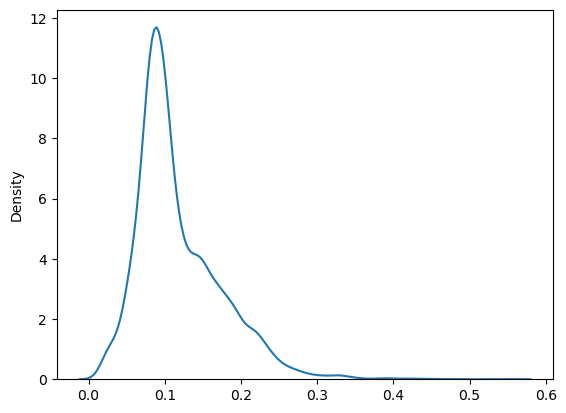

In [56]:
sns.kdeplot(data=rec_errors.numpy())

### kernel breaks down after 489...

In [ ]:
for i in range(400, 800):
    seq = torch.from_numpy(np.array(sequences[i])).type(torch.FloatTensor)
    tim = torch.from_numpy(np.array(timestamps[i])).type(torch.FloatTensor)
    _,_, rec_error = model.predict(seq, tim.unsqueeze(1))
    rec_errors.append(rec_error)
    print(rec_error)
    print(i)

tensor(0.0653, grad_fn=<MseLossBackward0>)
400
tensor(0.0934, grad_fn=<MseLossBackward0>)
401
tensor(0.1845, grad_fn=<MseLossBackward0>)
402
tensor(0.1928, grad_fn=<MseLossBackward0>)
403


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([38, 1, 128])) that is different to the input size (torch.Size([38, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([256, 1, 128])) that is different to the input size (torch.Size([256, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1111, grad_fn=<MseLossBackward0>)
404
tensor(0.1036, grad_fn=<MseLossBackward0>)
405
tensor(0.1332, grad_fn=<MseLossBackward0>)
406
tensor(0.0832, grad_fn=<MseLossBackward0>)
407
tensor(0.0988, grad_fn=<MseLossBackward0>)
408
tensor(0.1091, grad_fn=<MseLossBackward0>)
409
tensor(0.1028, grad_fn=<MseLossBackward0>)
410


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([234, 1, 128])) that is different to the input size (torch.Size([234, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1106, grad_fn=<MseLossBackward0>)
411
tensor(0.1647, grad_fn=<MseLossBackward0>)
412
tensor(0.1527, grad_fn=<MseLossBackward0>)
413


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([468, 1, 128])) that is different to the input size (torch.Size([468, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([266, 1, 128])) that is different to the input size (torch.Size([266, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1187, grad_fn=<MseLossBackward0>)
414
tensor(0.1172, grad_fn=<MseLossBackward0>)
415
tensor(0.1459, grad_fn=<MseLossBackward0>)
416
tensor(0.1118, grad_fn=<MseLossBackward0>)
417
tensor(0.1145, grad_fn=<MseLossBackward0>)
418
tensor(0.1051, grad_fn=<MseLossBackward0>)
419


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([889, 1, 128])) that is different to the input size (torch.Size([889, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1198, grad_fn=<MseLossBackward0>)
420
tensor(0.1112, grad_fn=<MseLossBackward0>)
421
tensor(0.1131, grad_fn=<MseLossBackward0>)
422
tensor(0.1005, grad_fn=<MseLossBackward0>)
423
tensor(0.1089, grad_fn=<MseLossBackward0>)
424


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([93, 1, 128])) that is different to the input size (torch.Size([93, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([217, 1, 128])) that is different to the input size (torch.Size([217, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1094, grad_fn=<MseLossBackward0>)
425
tensor(0.1408, grad_fn=<MseLossBackward0>)
426
tensor(0.0817, grad_fn=<MseLossBackward0>)
427
tensor(0.1371, grad_fn=<MseLossBackward0>)
428


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([321, 1, 128])) that is different to the input size (torch.Size([321, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([489, 1, 128])) that is different to the input size (torch.Size([489, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1158, grad_fn=<MseLossBackward0>)
429


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([345, 1, 128])) that is different to the input size (torch.Size([345, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([271, 1, 128])) that is different to the input size (torch.Size([271, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1788, grad_fn=<MseLossBackward0>)
430
tensor(0.1217, grad_fn=<MseLossBackward0>)
431
tensor(0.1201, grad_fn=<MseLossBackward0>)
432
tensor(0.1430, grad_fn=<MseLossBackward0>)
433
tensor(0.0855, grad_fn=<MseLossBackward0>)
434
tensor(0.1006, grad_fn=<MseLossBackward0>)
435
tensor(0.1095, grad_fn=<MseLossBackward0>)
436
tensor(0.1036, grad_fn=<MseLossBackward0>)
437
tensor(0.2046, grad_fn=<MseLossBackward0>)
438
tensor(0.0899, grad_fn=<MseLossBackward0>)
439


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([53, 1, 128])) that is different to the input size (torch.Size([53, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1475, grad_fn=<MseLossBackward0>)
440
tensor(0.1778, grad_fn=<MseLossBackward0>)
441
tensor(0.1112, grad_fn=<MseLossBackward0>)
442


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([187, 1, 128])) that is different to the input size (torch.Size([187, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([99, 1, 128])) that is different to the input size (torch.Size([99, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1181, grad_fn=<MseLossBackward0>)
443
tensor(0.1117, grad_fn=<MseLossBackward0>)
444
tensor(0.0667, grad_fn=<MseLossBackward0>)
445
tensor(0.3300, grad_fn=<MseLossBackward0>)
446
tensor(0.1012, grad_fn=<MseLossBackward0>)
447
tensor(0.0581, grad_fn=<MseLossBackward0>)
448
tensor(0.1711, grad_fn=<MseLossBackward0>)
449
tensor(0.1219, grad_fn=<MseLossBackward0>)
450
tensor(0.1095, grad_fn=<MseLossBackward0>)
451
tensor(0.1387, grad_fn=<MseLossBackward0>)
452
tensor(0.0742, grad_fn=<MseLossBackward0>)
453
tensor(0.0862, grad_fn=<MseLossBackward0>)
454
tensor(0.1151, grad_fn=<MseLossBackward0>)
455
tensor(0.1202, grad_fn=<MseLossBackward0>)
456
tensor(0.1511, grad_fn=<MseLossBackward0>)
457


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([724, 1, 128])) that is different to the input size (torch.Size([724, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1352, grad_fn=<MseLossBackward0>)
458
tensor(0.1320, grad_fn=<MseLossBackward0>)
459
tensor(0.0839, grad_fn=<MseLossBackward0>)
460
tensor(0.1334, grad_fn=<MseLossBackward0>)
461
tensor(0.2128, grad_fn=<MseLossBackward0>)
462


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([596, 1, 128])) that is different to the input size (torch.Size([596, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1177, grad_fn=<MseLossBackward0>)
463
tensor(0.1536, grad_fn=<MseLossBackward0>)
464
tensor(0.1424, grad_fn=<MseLossBackward0>)
465
tensor(0.1164, grad_fn=<MseLossBackward0>)
466


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([367, 1, 128])) that is different to the input size (torch.Size([367, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([82, 1, 128])) that is different to the input size (torch.Size([82, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([22, 1, 128])) that is different to the input size (torch.Size([22, 128])). This wi

tensor(0.1143, grad_fn=<MseLossBackward0>)
467
tensor(0.1817, grad_fn=<MseLossBackward0>)
468
tensor(0.0309, grad_fn=<MseLossBackward0>)
469
tensor(0.0973, grad_fn=<MseLossBackward0>)
470
tensor(0.1825, grad_fn=<MseLossBackward0>)
471
tensor(0.0778, grad_fn=<MseLossBackward0>)
472
tensor(0.0653, grad_fn=<MseLossBackward0>)
473


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([525, 1, 128])) that is different to the input size (torch.Size([525, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([162, 1, 128])) that is different to the input size (torch.Size([162, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1097, grad_fn=<MseLossBackward0>)
474
tensor(0.0847, grad_fn=<MseLossBackward0>)
475
tensor(0.1200, grad_fn=<MseLossBackward0>)
476
tensor(0.2078, grad_fn=<MseLossBackward0>)
477
tensor(0.1169, grad_fn=<MseLossBackward0>)
478
tensor(0.1277, grad_fn=<MseLossBackward0>)
479
tensor(0.0970, grad_fn=<MseLossBackward0>)
480
tensor(0.1210, grad_fn=<MseLossBackward0>)
481


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([247, 1, 128])) that is different to the input size (torch.Size([247, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.1526, grad_fn=<MseLossBackward0>)
482
tensor(0.2426, grad_fn=<MseLossBackward0>)
483
tensor(0.1142, grad_fn=<MseLossBackward0>)
484
tensor(0.0630, grad_fn=<MseLossBackward0>)
485
tensor(0.1893, grad_fn=<MseLossBackward0>)
486
tensor(0.1038, grad_fn=<MseLossBackward0>)
487
tensor(0.1200, grad_fn=<MseLossBackward0>)
488
tensor(0.0836, grad_fn=<MseLossBackward0>)
489


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4707, 1, 128])) that is different to the input size (torch.Size([4707, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
# distribution plot for rec_errors

# get vip_level array

# get country_code array

# get the clusters

In [ ]:
# TRAIN TEST

# LSTM AUTOENCODER
# 100%|██████████| 500/500 [00:42<00:00, 11.90it/s, loss=0.0091651650]

# TRAINING ACCURACY
# 0.009165165014564991
# 0.09573486833210244

# TESTING MEAN LOSS
# 25.63962173461914
# 5.063558208870432

In [ ]:
# VARIATIONAL AUTOENCODER

# TRAINING
# 100%|██████████| 500/500 [00:43<00:00, 11.39it/s, loss=0.0042354001]
# 100%|██████████| 500/500 [00:43<00:00, 11.36it/s, loss=0.0154977629]
# 100%|██████████| 500/500 [00:43<00:00, 11.41it/s, loss=0.0088684270]

# TESTING
# 100%|██████████| 500/500 [00:42<00:00, 11.87it/s, loss=0.0062272854]
# 100%|██████████| 500/500 [00:42<00:00, 11.81it/s, loss=0.0018926092]
# 100%|██████████| 500/500 [00:42<00:00, 11.84it/s, loss=0.0130772868]

In [ ]:
# REVERSED VS NON-REVERSED => REVERSED WORKS BETTER!
# NON-REVERSED
# 100%|██████████| 500/500 [00:42<00:00, 11.86it/s, loss=0.0000736655]
# 100%|██████████| 500/500 [00:42<00:00, 11.84it/s, loss=0.0000185950]
# 100%|██████████| 500/500 [00:42<00:00, 11.75it/s, loss=0.0000177078]

In [ ]:
print(model.encoder.state_dict())

In [ ]:
print(model.decoder.state_dict())

In [ ]:
loss = model.train_predecoder(torched_windowed_sequences, 
                              torched_windowed_timestamps, 2,
                              n_epochs = 500, batch_size = 5, training_prediction = 'mixed_teacher_forcing', teacher_forcing_ratio = 0.6, learning_rate = 0.01, dynamic_tf = False)
print(math.sqrt(loss[-1]))

In [ ]:
# with freezing
# 100%|██████████| 500/500 [00:09<00:00, 50.44it/s, loss=0.0011930717]
# 100%|██████████| 500/500 [00:10<00:00, 49.09it/s, loss=0.0013867632]

# without freezing
# 

In [ ]:
print(model.encoder.state_dict())
print(model.predictor.state_dict())

In [ ]:
# LSTM
# 100%|██████████| 500/500 [00:45<00:00, 10.88it/s, loss=0.0000253534]
# 100%|██████████| 500/500 [00:43<00:00, 11.58it/s, loss=0.0000157571]

# LSTM w/ Peephole
# 100%|██████████| 500/500 [00:52<00:00,  9.59it/s, loss=0.0000155904]
# 100%|██████████| 500/500 [00:52<00:00,  9.56it/s, loss=0.0001305166]

# LSTM w/ Peephole + Coupled Gates
# 100%|██████████| 500/500 [00:55<00:00,  9.02it/s, loss=0.0005010203]
# 100%|██████████| 500/500 [00:56<00:00,  8.83it/s, loss=0.0051181654]

# TIME-LSTM 1
# 100%|██████████| 500/500 [01:07<00:00,  7.43it/s, loss=0.0060292104]
# 100%|██████████| 500/500 [01:07<00:00,  7.41it/s, loss=0.0104567041]

# TIME-LSTM 2
# 100%|██████████| 500/500 [01:20<00:00,  6.23it/s, loss=0.0013810578]
# 100%|██████████| 500/500 [01:22<00:00,  6.07it/s, loss=0.0025202912]

# TIME-LSTM 3
# 100%|██████████| 500/500 [01:11<00:00,  6.95it/s, loss=0.0001785948]
# 100%|██████████| 500/500 [01:13<00:00,  6.83it/s, loss=0.0001769290]
# 5000 epochs

# CUSTOM TIME
# 100%|██████████| 500/500 [00:52<00:00,  9.57it/s, loss=0.0000210490]

# PHASED-LSTM



# 100%|██████████| 500/500 [00:38<00:00, 12.95it/s, loss=0.0000069499]


### Encoder-Decoder for Time-Series

Using the same encoder model, we encode a window of operations to predict the next window of operations
This is to show that the embeddings are meaningful such that through:
1. The AE Decoder, they contain the historical user behaviour information
2. The Time-Series Decoder, they contain the future user behaviour information:
        1. Retrieve categorical sequences
        2. Each output, categorical layer to assign to operation
        3. Compute accuracy from correct operation category output

100%|██████████| 500/500 [00:38<00:00, 12.95it/s, loss=0.0000069499]

Run a grid search/random search on LSTM layers, latent space dimension, and epochs

Where does the embedding come from?

ASSUME TIME GATE WORKS BETTER THAN NO TIME GATE? because loss seems to be \leq 

(we may use torch.nn.lstm for comparison)

-loss=0.0000102043 on hidden size 15, epochs 500

-loss=0.0000010081 on hidden size 30, epochs 500

In [ ]:
np.set_printoptions(threshold=sys.maxsize)
#torch.set_printoptions(threshold=sys.maxsize) # this will kill the kernel!

print(torched_windowed_timestamps[6][0])

In [ ]:
torched_windowed_timestamps[:,9].unsqueeze(1).shape

In [ ]:
print(torched_windowed_sequences[:,6][-1])
print(torched_windowed_timestamps[:,6][-1])

### Cluster Tests

In [ ]:
input_tensor = torch.tensor([ 7.2859e-02, -5.1723e-02,  1.6887e-01,  9.6478e-03,  2.7092e-01,
         1.4126e-02,  1.2384e-01, -3.9685e-04,  2.2763e-01, -4.0240e-01,
        -1.9798e-01, -3.4064e-01, -2.0647e-01,  1.3255e-01,  6.4034e-03,
        -1.3859e-02,  1.0164e-01,  1.6872e-01, -1.1312e-01, -3.2962e-01,
        -1.0826e-01, -1.7407e-02, -2.5063e-01, -1.6811e-01, -1.6072e-02,
        -3.7014e-02,  8.8129e-02,  5.9020e-02,  1.5442e-01,  1.1737e-01,
        -7.6847e-02,  4.6167e-02,  1.7816e-01,  3.5143e-01, -2.0578e-01,
        -8.1568e-02,  1.6674e-01,  1.3171e-01,  4.0933e-02, -4.2767e-02,
         4.8727e-01,  5.1966e-02, -2.6346e-01,  6.2688e-01,  2.4226e-01,
         1.6288e-02,  1.5292e-01, -3.1451e-01, -4.3505e-02, -1.1195e-01,
         3.7763e-02,  1.8957e-01,  6.5843e-02,  6.7268e-03, -1.6360e-01,
         7.9658e-02,  8.2879e-03, -1.2846e-01,  1.8420e-01, -1.6801e-01,
        -2.2163e-01, -8.7116e-02,  1.8645e-01, -7.0144e-02,  2.9216e-02,
        -2.6450e-02, -3.7200e-02,  3.4123e-02, -1.3855e-01,  1.2327e-01,
         9.6004e-03,  1.6783e-01, -1.9080e-01, -1.8574e-02,  1.3258e-01,
         3.9922e-01,  2.0783e-01,  2.1572e-02, -2.8567e-02, -4.5407e-02,
        -8.5485e-02, -8.9264e-03, -3.4358e-02,  1.5016e-02, -2.4072e-02,
         2.4404e-01, -3.1834e-02, -2.7986e-02,  7.4648e-02, -1.0087e-02,
        -3.1862e-02, -2.3848e-01, -8.0869e-02, -2.0942e-02, -6.9803e-02,
         2.3009e-01,  1.3550e-01, -9.0289e-02,  7.8311e-03, -8.4256e-02,
         1.4535e-01, -1.3228e-01,  1.1738e-03,  1.1044e-01, -9.6383e-02,
        -3.6381e-03, -2.2033e-01,  1.2453e-01, -1.4537e-01, -7.5747e-03,
         5.2217e-01, -3.2780e-01,  6.7146e-02, -1.4363e-01, -1.9472e-01,
        -6.7836e-02,  2.1534e-01, -2.1962e-02,  5.1992e-01,  4.6406e-02,
        -1.7308e-01,  8.7515e-02, -6.2887e-02,  2.3623e-02,  2.3809e-02,
        -2.0818e-01, -2.4797e-02, -7.4244e-09])

seq2 = torch.cat((torched_windowed_sequences[:,6], input_tensor.unsqueeze(0)),0)

In [ ]:
time_tensor = torch.tensor([325235235523.])
time2 = torch.cat((torched_windowed_timestamps[:,6],time_tensor)).unsqueeze(1)
print(torched_windowed_timestamps[:,6].shape)

In [ ]:
prediction, embedding = model.predict(torched_windowed_sequences[:,6], torch.zeros(torched_windowed_sequences[:,6].shape[1]).unsqueeze(1))
embedding = torch.cat(embedding).ravel().detach().numpy()
print(embedding)

In [ ]:
prediction2, embedding2 = model.predict(seq2, time2)
embedding2 = torch.cat(embedding2).ravel().detach().numpy()
print(embedding2)

In [ ]:
np.linalg.norm(embedding2 - embedding)

In [ ]:
### is there any cost/energy associated with training for such a long time?

# set window size
# user sequences > window size -> more than one instance (sequence len - window size number of instances)

# better to truncate based on time gap

# reimplement with time gates

# freedom, accessibility with machine learning models
# random search instead of grid search (more efficient)

## Saving the model (and its checkpoints)

In [ ]:
model.state_dict()

## Embed all Users!

In [ ]:
len(sequences)
len(timestamps)

In [ ]:
sequences1= sequences[:2000]
timestamps1=timestamps[:2000]

In [46]:
uobs = []

In [47]:
print(len(sequences))
print(len(timestamps))

6726
6726


In [60]:
uobs = []

for i in range(len(sequences)):
    seq = torch.from_numpy(np.array(sequences[i])).type(torch.FloatTensor)
    tim = torch.from_numpy(np.array(timestamps[i])).type(torch.FloatTensor)
    _, embed, _ = model.predict(seq, tim.unsqueeze(1))
    uobs.append(torch.cat(embed).ravel().detach().numpy())
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([19, 1, 128])) that is different to the input size (torch.Size([19, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([104, 1, 128])) that is different to the input size (torch.Size([104, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([40, 1, 128])) that is different to the input size (torch.Size([40, 128])). This wi

180
181
182
183
184
185
186


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([116, 1, 128])) that is different to the input size (torch.Size([116, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4, 1, 128])) that is different to the input size (torch.Size([4, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([75, 1, 128])) that is different to the input size (torch.Size([75, 128])). This will

187
188
189
190


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([285, 1, 128])) that is different to the input size (torch.Size([285, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([30, 1, 128])) that is different to the input size (torch.Size([30, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


191
192
193
194


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([377, 1, 128])) that is different to the input size (torch.Size([377, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11, 1, 128])) that is different to the input size (torch.Size([11, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


195
196
197


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([306, 1, 128])) that is different to the input size (torch.Size([306, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([23, 1, 128])) that is different to the input size (torch.Size([23, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([56, 1, 128])) that is different to the input size (torch.Size([56, 128])). This wi

198
199
200
201
202
203


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([112, 1, 128])) that is different to the input size (torch.Size([112, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([67, 1, 128])) that is different to the input size (torch.Size([67, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


204
205
206
207


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([358, 1, 128])) that is different to the input size (torch.Size([358, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


208
209
210
211
212
213


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([387, 1, 128])) that is different to the input size (torch.Size([387, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([231, 1, 128])) that is different to the input size (torch.Size([231, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


214
215
216
217
218


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([750, 1, 128])) that is different to the input size (torch.Size([750, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([68, 1, 128])) that is different to the input size (torch.Size([68, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


219
220
221
222
223
224
225
226
227


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([110, 1, 128])) that is different to the input size (torch.Size([110, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([179, 1, 128])) that is different to the input size (torch.Size([179, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


228
229
230


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([84, 1, 128])) that is different to the input size (torch.Size([84, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([286, 1, 128])) that is different to the input size (torch.Size([286, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


231
232
233
234
235
236
237
238


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([218, 1, 128])) that is different to the input size (torch.Size([218, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([106, 1, 128])) that is different to the input size (torch.Size([106, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


239
240
241
242
243
244
245
246
247
248


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([396, 1, 128])) that is different to the input size (torch.Size([396, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16, 1, 128])) that is different to the input size (torch.Size([16, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([203, 1, 128])) that is different to the input size (torch.Size([203, 128])). This 

249
250
251
252
253
254
255


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([332, 1, 128])) that is different to the input size (torch.Size([332, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


256
257


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([420, 1, 128])) that is different to the input size (torch.Size([420, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


258
259
260
261
262


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([298, 1, 128])) that is different to the input size (torch.Size([298, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([246, 1, 128])) that is different to the input size (torch.Size([246, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


263
264
265
266
267
268
269


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([103, 1, 128])) that is different to the input size (torch.Size([103, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([57, 1, 128])) that is different to the input size (torch.Size([57, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([96, 1, 128])) that is different to the input size (torch.Size([96, 128])). This wi

270
271
272
273
274
275


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([416, 1, 128])) that is different to the input size (torch.Size([416, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([252, 1, 128])) that is different to the input size (torch.Size([252, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


276
277


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([69, 1, 128])) that is different to the input size (torch.Size([69, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([44, 1, 128])) that is different to the input size (torch.Size([44, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([197, 1, 128])) that is different to the input size (torch.Size([197, 128])). This wi

278
279
280


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([87, 1, 128])) that is different to the input size (torch.Size([87, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


281
282


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([374, 1, 128])) that is different to the input size (torch.Size([374, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


283
284
285


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([566, 1, 128])) that is different to the input size (torch.Size([566, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([60, 1, 128])) that is different to the input size (torch.Size([60, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


286
287
288
289
290


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([244, 1, 128])) that is different to the input size (torch.Size([244, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([330, 1, 128])) that is different to the input size (torch.Size([330, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


291
292
293
294
295
296
297
298
299
300
301
302


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([37, 1, 128])) that is different to the input size (torch.Size([37, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([170, 1, 128])) that is different to the input size (torch.Size([170, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


303
304
305
306
307
308
309
310


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([230, 1, 128])) that is different to the input size (torch.Size([230, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([47, 1, 128])) that is different to the input size (torch.Size([47, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([35, 1, 128])) that is different to the input size (torch.Size([35, 128])). This wi

311
312
313
314
315
316
317


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([72, 1, 128])) that is different to the input size (torch.Size([72, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([167, 1, 128])) that is different to the input size (torch.Size([167, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([323, 1, 128])) that is different to the input size (torch.Size([323, 128])). This 

318
319
320
321
322


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([215, 1, 128])) that is different to the input size (torch.Size([215, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([263, 1, 128])) that is different to the input size (torch.Size([263, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


323
324
325
326


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([897, 1, 128])) that is different to the input size (torch.Size([897, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


327
328
329
330
331
332
333


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([105, 1, 128])) that is different to the input size (torch.Size([105, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([276, 1, 128])) that is different to the input size (torch.Size([276, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


334
335
336
337
338
339
340
341
342
343
344


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([33, 1, 128])) that is different to the input size (torch.Size([33, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([318, 1, 128])) that is different to the input size (torch.Size([318, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([59, 1, 128])) that is different to the input size (torch.Size([59, 128])). This wi

345
346
347
348
349
350
351
352
353
354
355


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([74, 1, 128])) that is different to the input size (torch.Size([74, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([126, 1, 128])) that is different to the input size (torch.Size([126, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([92, 1, 128])) that is different to the input size (torch.Size([92, 128])). This wi

356
357
358


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([70, 1, 128])) that is different to the input size (torch.Size([70, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2041, 1, 128])) that is different to the input size (torch.Size([2041, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


359
360
361
362
363
364
365
366
367


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([137, 1, 128])) that is different to the input size (torch.Size([137, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([444, 1, 128])) that is different to the input size (torch.Size([444, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([3, 1, 128])) that is different to the input size (torch.Size([3, 128])). This wi

368
369
370
371
372
373
374
375
376
377
378
379


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([114, 1, 128])) that is different to the input size (torch.Size([114, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([139, 1, 128])) that is different to the input size (torch.Size([139, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([91, 1, 128])) that is different to the input size (torch.Size([91, 128])). This 

380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([38, 1, 128])) that is different to the input size (torch.Size([38, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([256, 1, 128])) that is different to the input size (torch.Size([256, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


403
404
405
406
407
408
409
410
411
412


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([234, 1, 128])) that is different to the input size (torch.Size([234, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


413


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([468, 1, 128])) that is different to the input size (torch.Size([468, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([266, 1, 128])) that is different to the input size (torch.Size([266, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


414
415
416
417
418
419


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([889, 1, 128])) that is different to the input size (torch.Size([889, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([93, 1, 128])) that is different to the input size (torch.Size([93, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


420
421
422
423
424


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([217, 1, 128])) that is different to the input size (torch.Size([217, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([321, 1, 128])) that is different to the input size (torch.Size([321, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


425
426
427
428


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([489, 1, 128])) that is different to the input size (torch.Size([489, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([345, 1, 128])) that is different to the input size (torch.Size([345, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


429
430


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([271, 1, 128])) that is different to the input size (torch.Size([271, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


431
432
433
434
435
436


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([53, 1, 128])) that is different to the input size (torch.Size([53, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


437
438
439
440
441
442
443
444
445
446
447
448
449


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([187, 1, 128])) that is different to the input size (torch.Size([187, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([99, 1, 128])) that is different to the input size (torch.Size([99, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


450
451
452
453
454
455
456
457


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([724, 1, 128])) that is different to the input size (torch.Size([724, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


458
459
460
461
462


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([596, 1, 128])) that is different to the input size (torch.Size([596, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


463
464
465
466


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([367, 1, 128])) that is different to the input size (torch.Size([367, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([82, 1, 128])) that is different to the input size (torch.Size([82, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([22, 1, 128])) that is different to the input size (torch.Size([22, 128])). This wi

467
468
469
470
471
472
473


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([525, 1, 128])) that is different to the input size (torch.Size([525, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([162, 1, 128])) that is different to the input size (torch.Size([162, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


474
475
476
477
478


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([247, 1, 128])) that is different to the input size (torch.Size([247, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


479
480
481
482
483
484
485
486
487
488
489


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4707, 1, 128])) that is different to the input size (torch.Size([4707, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


490
491
492


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([210, 1, 128])) that is different to the input size (torch.Size([210, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([602, 1, 128])) that is different to the input size (torch.Size([602, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


493
494


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([698, 1, 128])) that is different to the input size (torch.Size([698, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([65, 1, 128])) that is different to the input size (torch.Size([65, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([90, 1, 128])) that is different to the input size (torch.Size([90, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


513
514
515


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([239, 1, 128])) that is different to the input size (torch.Size([239, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([533, 1, 128])) that is different to the input size (torch.Size([533, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


516
517
518
519
520
521


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([249, 1, 128])) that is different to the input size (torch.Size([249, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([98, 1, 128])) that is different to the input size (torch.Size([98, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


522
523
524
525
526
527
528
529
530
531
532
533


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([101, 1, 128])) that is different to the input size (torch.Size([101, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1242, 1, 128])) that is different to the input size (torch.Size([1242, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([273, 1, 128])) that is different to the input size (torch.Size([273, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([36, 1, 128])) that is different to the input size (torch.Size([36, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


550
551
552
553
554
555
556


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([424, 1, 128])) that is different to the input size (torch.Size([424, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


557
558
559
560
561
562
563
564
565
566
567
568
569


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([523, 1, 128])) that is different to the input size (torch.Size([523, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([89, 1, 128])) that is different to the input size (torch.Size([89, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


570
571
572
573
574
575
576
577
578


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([177, 1, 128])) that is different to the input size (torch.Size([177, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([191, 1, 128])) that is different to the input size (torch.Size([191, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


579
580
581
582


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([394, 1, 128])) that is different to the input size (torch.Size([394, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


583
584


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([728, 1, 128])) that is different to the input size (torch.Size([728, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([165, 1, 128])) that is different to the input size (torch.Size([165, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([152, 1, 128])) that is different to the input size (torch.Size([152, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


607
608
609
610
611
612
613
614
615
616
617
618
619
620


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([39, 1, 128])) that is different to the input size (torch.Size([39, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([61, 1, 128])) that is different to the input size (torch.Size([61, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([182, 1, 128])) that is different to the input size (torch.Size([182, 128])). This wi

621
622
623
624
625
626
627
628
629
630
631
632


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([287, 1, 128])) that is different to the input size (torch.Size([287, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([391, 1, 128])) that is different to the input size (torch.Size([391, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


649
650
651
652


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([185, 1, 128])) that is different to the input size (torch.Size([185, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([319, 1, 128])) that is different to the input size (torch.Size([319, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


653
654
655
656
657


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([113, 1, 128])) that is different to the input size (torch.Size([113, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([55, 1, 128])) that is different to the input size (torch.Size([55, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


658
659
660
661


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([248, 1, 128])) that is different to the input size (torch.Size([248, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([115, 1, 128])) that is different to the input size (torch.Size([115, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


662
663
664


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([264, 1, 128])) that is different to the input size (torch.Size([264, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


665
666
667
668
669


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([316, 1, 128])) that is different to the input size (torch.Size([316, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([125, 1, 128])) that is different to the input size (torch.Size([125, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


670
671
672
673
674
675
676
677
678


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([506, 1, 128])) that is different to the input size (torch.Size([506, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([142, 1, 128])) that is different to the input size (torch.Size([142, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([138, 1, 128])) that is different to the input size (torch.Size([138, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


714
715
716
717
718
719
720
721
722
723
724


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1303, 1, 128])) that is different to the input size (torch.Size([1303, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


725
726
727
728
729
730


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([88, 1, 128])) that is different to the input size (torch.Size([88, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([455, 1, 128])) that is different to the input size (torch.Size([455, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


731
732
733
734
735
736


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([346, 1, 128])) that is different to the input size (torch.Size([346, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


737
738
739
740
741
742
743


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([143, 1, 128])) that is different to the input size (torch.Size([143, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


744
745
746
747
748
749


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([726, 1, 128])) that is different to the input size (torch.Size([726, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


750
751
752
753
754
755
756
757
758
759
760
761
762
763
764


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([188, 1, 128])) that is different to the input size (torch.Size([188, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


765
766
767
768
769
770
771
772
773
774
775
776
777
778


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([169, 1, 128])) that is different to the input size (torch.Size([169, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([151, 1, 128])) that is different to the input size (torch.Size([151, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


779
780
781
782
783
784
785
786
787
788
789


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([243, 1, 128])) that is different to the input size (torch.Size([243, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([130, 1, 128])) that is different to the input size (torch.Size([130, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([902, 1, 128])) that is different to the input size (torch.Size([902, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


811
812
813
814
815
816
817
818
819


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([212, 1, 128])) that is different to the input size (torch.Size([212, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([194, 1, 128])) that is different to the input size (torch.Size([194, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


820
821
822
823
824
825


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([845, 1, 128])) that is different to the input size (torch.Size([845, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


826
827
828


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([331, 1, 128])) that is different to the input size (torch.Size([331, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


829
830
831
832
833
834
835
836


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([703, 1, 128])) that is different to the input size (torch.Size([703, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


837


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([574, 1, 128])) that is different to the input size (torch.Size([574, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([201, 1, 128])) that is different to the input size (torch.Size([201, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


858
859
860
861
862
863
864
865
866
867
868


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([154, 1, 128])) that is different to the input size (torch.Size([154, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


869
870
871


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([435, 1, 128])) that is different to the input size (torch.Size([435, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([135, 1, 128])) that is different to the input size (torch.Size([135, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


872
873
874
875
876
877
878
879
880
881
882
883
884
885
886


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([453, 1, 128])) that is different to the input size (torch.Size([453, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([156, 1, 128])) that is different to the input size (torch.Size([156, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([131, 1, 128])) that is different to the input size (torch.Size([131, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


911
912
913
914
915
916
917
918
919
920
921
922
923
924
925


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([117, 1, 128])) that is different to the input size (torch.Size([117, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([149, 1, 128])) that is different to the input size (torch.Size([149, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([237, 1, 128])) that is different to the input size (torch.Size([237, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([211, 1, 128])) that is different to the input size (torch.Size([211, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([128, 1, 128])) that is different to the input size (torch.Size([128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([404, 1, 128])) that is different to the input size (torch.Size([404, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1042
1043
1044


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([475, 1, 128])) that is different to the input size (torch.Size([475, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1045
1046
1047
1048


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1718, 1, 128])) that is different to the input size (torch.Size([1718, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([259, 1, 128])) that is different to the input size (torch.Size([259, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([509, 1, 128])) that is different to the input size (torch.Size([509, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1085
1086
1087
1088
1089
1090


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([62, 1, 128])) that is different to the input size (torch.Size([62, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([153, 1, 128])) that is different to the input size (torch.Size([153, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([251, 1, 128])) that is different to the input size (torch.Size([251, 128])). This 

1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([86, 1, 128])) that is different to the input size (torch.Size([86, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([351, 1, 128])) that is different to the input size (torch.Size([351, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
1169
1170
1171


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([301, 1, 128])) that is different to the input size (torch.Size([301, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1172
1173
1174
1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192
1193


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([150, 1, 128])) that is different to the input size (torch.Size([150, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([223, 1, 128])) that is different to the input size (torch.Size([223, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1194
1195


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([457, 1, 128])) that is different to the input size (torch.Size([457, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([870, 1, 128])) that is different to the input size (torch.Size([870, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([97, 1, 128])) that is different to the input size (torch.Size([97, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269
1270
1271
1272
1273
1274
1275
1276
1277


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([73, 1, 128])) that is different to the input size (torch.Size([73, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1278
1279
1280
1281
1282
1283
1284


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([159, 1, 128])) that is different to the input size (torch.Size([159, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320
1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([71, 1, 128])) that is different to the input size (torch.Size([71, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1334
1335
1336
1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([290, 1, 128])) that is different to the input size (torch.Size([290, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1348
1349
1350
1351
1352
1353
1354
1355
1356
1357


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([372, 1, 128])) that is different to the input size (torch.Size([372, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369
1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380
1381
1382
1383
1384


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([76, 1, 128])) that is different to the input size (torch.Size([76, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([224, 1, 128])) that is different to the input size (torch.Size([224, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1385
1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411
1412
1413
1414
1415
1416
1417


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([650, 1, 128])) that is different to the input size (torch.Size([650, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1418
1419
1420
1421
1422


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([227, 1, 128])) that is different to the input size (torch.Size([227, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1423
1424


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([567, 1, 128])) that is different to the input size (torch.Size([567, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1425
1426
1427
1428
1429
1430


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([343, 1, 128])) that is different to the input size (torch.Size([343, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1431
1432
1433
1434
1435
1436
1437
1438
1439
1440
1441
1442


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([292, 1, 128])) that is different to the input size (torch.Size([292, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1443
1444
1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455
1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469
1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497
1498
1499
1500
1501
1502
1503
1504
1505
1506
1507
1508
1509
1510
1511
1512
1513
1514
1515


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([811, 1, 128])) that is different to the input size (torch.Size([811, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1516
1517
1518
1519
1520
1521
1522
1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534
1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552
1553
1554
1555
1556
1557
1558
1559


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([133, 1, 128])) that is different to the input size (torch.Size([133, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([107, 1, 128])) that is different to the input size (torch.Size([107, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1560
1561
1562
1563
1564
1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578
1579
1580
1581
1582
1583
1584
1585
1586
1587
1588
1589


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([233, 1, 128])) that is different to the input size (torch.Size([233, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([102, 1, 128])) that is different to the input size (torch.Size([102, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1590
1591
1592
1593
1594
1595
1596
1597
1598
1599
1600
1601


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([303, 1, 128])) that is different to the input size (torch.Size([303, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1602
1603
1604
1605
1606
1607
1608
1609
1610
1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623
1624
1625
1626
1627


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([443, 1, 128])) that is different to the input size (torch.Size([443, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1628
1629
1630
1631
1632
1633
1634
1635
1636
1637
1638
1639
1640
1641
1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([255, 1, 128])) that is different to the input size (torch.Size([255, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([196, 1, 128])) that is different to the input size (torch.Size([196, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([175, 1, 128])) that is different to the input size (torch.Size([175, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([399, 1, 128])) that is different to the input size (torch.Size([399, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([181, 1, 128])) that is different to the input size (torch.Size([181, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([136, 1, 128])) that is different to the input size (torch.Size([136, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([385, 1, 128])) that is different to the input size (torch.Size([385, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([193, 1, 128])) that is different to the input size (torch.Size([193, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([362, 1, 128])) that is different to the input size (torch.Size([362, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([258, 1, 128])) that is different to the input size (torch.Size([258, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244
2245
2246
2247
2248
2249
2250
2251
2252
2253
2254
2255
2256
2257
2258
2259
2260
2261
2262
2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([222, 1, 128])) that is different to the input size (torch.Size([222, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([393, 1, 128])) that is different to the input size (torch.Size([393, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([232, 1, 128])) that is different to the input size (torch.Size([232, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([157, 1, 128])) that is different to the input size (torch.Size([157, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([206, 1, 128])) that is different to the input size (torch.Size([206, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([315, 1, 128])) that is different to the input size (torch.Size([315, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([439, 1, 128])) that is different to the input size (torch.Size([439, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([507, 1, 128])) that is different to the input size (torch.Size([507, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([140, 1, 128])) that is different to the input size (torch.Size([140, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([118, 1, 128])) that is different to the input size (torch.Size([118, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([467, 1, 128])) that is different to the input size (torch.Size([467, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228
3229
3230
3231
3232
3233
3234
3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246
3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285
3286
3287
3288
3289
3290
3291
3292
3293
3294
3295
3296
3297
3298
3299
3300
3301
3302
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([94, 1, 128])) that is different to the input size (torch.Size([94, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([189, 1, 128])) that is different to the input size (torch.Size([189, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([262, 1, 128])) that is different to the input size (torch.Size([262, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([124, 1, 128])) that is different to the input size (torch.Size([124, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([176, 1, 128])) that is different to the input size (torch.Size([176, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602
4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742
4743


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1098, 1, 128])) that is different to the input size (torch.Size([1098, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


4916
4917
4918
4919
4920
4921
4922
4923
4924
4925
4926
4927
4928
4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940
4941
4942
4943
4944
4945
4946
4947
4948
4949
4950
4951
4952
4953
4954
4955
4956
4957
4958
4959
4960
4961
4962
4963


/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([148, 1, 128])) that is different to the input size (torch.Size([148, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


4964
4965
4966
4967
4968
4969
4970
4971
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163


In [ ]:
print(uobs[0])

In [ ]:
input_tensor = torch.tensor([-4.4352e-02,  1.2201e-02,  1.6216e-01,  1.6379e-01,  3.9218e-01,
        -2.5394e-01, -5.2667e-02, -6.7875e-02,  6.5994e-01, -1.0205e-01,
        -2.6776e-01, -2.0883e-01, -4.1226e-01,  7.7409e-02, -1.0235e-01,
         3.9226e-01, -4.4637e-01, -3.3146e-01, -1.2367e-02, -5.5867e-02,
        -7.0543e-01,  2.5752e-02, -5.8277e-02, -5.1242e-01, -9.3612e-02,
         3.1211e-01,  2.6222e-01, -9.2457e-02,  1.3677e-01,  3.0865e-01,
         2.4187e-01,  3.6984e-01,  6.5900e-01,  5.1530e-01,  1.4048e-02,
        -2.5620e-01,  1.0549e-01,  3.4391e-01, -4.7275e-01,  3.2565e-02,
         4.3158e-01, -1.5974e-01, -3.0765e-01,  5.4733e-01,  5.8574e-01,
        -3.1861e-01,  2.0723e-01, -2.6745e-01, -6.3177e-02,  1.5469e-02,
         5.2354e-02,  1.3191e-01,  2.1890e-01,  2.7721e-04,  3.7968e-02,
        -9.9480e-02, -5.0709e-01,  1.6384e-01,  7.4540e-02,  4.1532e-02,
        -5.4125e-02, -9.9936e-01,  3.2398e-01, -4.7699e-01,  1.5951e-01,
         2.2943e-01, -2.6444e-01,  1.4613e-01, -5.8839e-01, -4.0362e-01,
         1.2432e-01,  3.8341e-01, -2.6790e-01, -9.5816e-02, -2.8904e-01,
         3.6368e-01,  8.3652e-02,  1.7725e-01,  2.7741e-01, -2.8172e-01,
        -7.3207e-02,  4.3167e-01,  5.2676e-01, -2.8241e-01,  2.3268e-01,
         2.0204e-01,  1.8995e-01,  2.2696e-01,  2.2350e-01, -1.2188e-01,
        -3.5101e-02, -5.4444e-01, -4.6613e-01,  2.1541e-01,  2.2307e-01,
        -1.0715e-01,  2.8139e-01,  1.6742e-01,  9.2263e-02,  2.7756e-01,
         8.0698e-02, -1.8247e-01,  2.1044e-01,  2.0641e-01,  8.4537e-02,
         2.7049e-01, -1.9913e-01, -2.0460e-01, -1.5651e-02,  5.7233e-01,
         4.0540e-01, -1.4468e-01, -3.6146e-01, -2.8766e-01, -1.9464e-03,
        -4.5186e-01, -8.1728e-02,  7.6493e-02, -1.9496e-02, -2.9143e-01,
        -1.7943e-01,  4.2151e-01, -2.0292e-01,  5.1099e-01,  2.5352e-02,
        -1.0709e-01,  1.5144e-01,  9.6194e-02])

time_tensor = torch.tensor([34000.])

embedding = uobs[0]

In [ ]:
output = model.test(input_tensor, time_tensor, embedding)

In [ ]:
prediction, embedding = model.test(torched_windowed_sequences[:,6], torched_windowed_timestamps[:,6].unsqueeze(1))
print(len(embedding))

In [61]:
with open('uobs', 'wb') as f:
    pickle.dump(uobs,f)

In [ ]:
out = io.open('uobs.tsv', 'w', encoding='utf-8')

for index, user in enumerate(uobs):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out.write(word + "\n")
out.close()

In [ ]:
pred1, embed1 = model.predict(torch.from_numpy(np.array(sequences[0])).type(torch.FloatTensor), torch.from_numpy(np.array(timestamps[0])).type(torch.FloatTensor).unsqueeze(1))

In [ ]:
print(torch.cat(embed1).ravel().detach().numpy())

### To Do (Low Priority)

Next steps:
(1. Run a random hyperparameter search and re-review the code)
(1. a) Finish the KMeans Operation-Level Embedding Test code)
(2. Modify architecture based on Seq2Seq literature
    - There are various architectures for many-to-many, namely Recursive (feeding), Repeat vectors, etc.
    - Consider using EOS or SOS (currently we have only SOS)
    - Consider delimitating sessions (but how to do it uniformly? does it go hand in hand with time gates?))
2. Sanity check closest pairs
3. Add time gates next, only after optimizing w/o
4. Proceed with Transformers


# Flagging Model

In [ ]:
print(model.parameters())

In [ ]:
i=1
for param in model.parameters():
    print(i)
    print(param.data)
    print(param.data.shape)
    i+=1

# K-Means Clustering + Operation-Level Flagging

### To Do Later: DBScan Clustering, Variational Inference

In order for there to be operation-level flagging, the user must be considered non-anomalous

In other words, the next/latest operation must be anomalous enough for it to cause the hidden state to diverge

Steps:
1. Time-LSTM Autoencoder yields UOBS embeddings (encoder hidden states)
2. UOBS embeddings are clustered to form user segmentations (or variational inference later...)
3. Get hidden vector
4. For each operation, calculate the bounds of time elapsed in which the operation keeps the user "safe"

Such bounds are the "flagging rules". Alternatively, we may perform this on the cluster center to approximate a "user profile" based on fully-safe operations and safe bounds per non-fully-safe operations for some sort of user profiling that we can understand/imagine.

In [ ]:
# find optimal kmeans cluster (ensemble, repeated trainings)
# we want to maximize the Dunn index = min(intra cluster distance)/max (inter cluster distance)

#https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/ for KMeans ++

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(X)
kmeans.cluster_centers_


## Rough Analysis of User Level Embeddings

### Roughly check similarities between 10-20 pairs of users and get back on this, then proceed to time gates

In [ ]:
# how to do this with a windowed dataset? 
# as there is a different number of windows/instances generated per user

OUT_path_pairs = 's3://tk-dev-datalake2/risk/jerry.zhu/UBS_Embedding/Op_Log_masked_20221121_20221129.parquet'
data = pd.read_parquet(OUT_path_pairs)

In [ ]:
data.head()
# filter out 1-operation users (non-sequential data)

user_counts = data['user_id'].value_counts().reset_index()
bottom_users = user_counts[user_counts['user_id']<=1]
bottom_users = bottom_users['index'].tolist()
data = data[~data['user_id'].isin(bottom_users)] 
print("Dataframe shape after filtering out singular operations is " + str(data.shape))

In [ ]:
users = data['user_id'].unique()

print(len(users))
print(users)

def findIndex(name, users):
    for i, user in enumerate(users):
        if user==name:
            return i

In [ ]:
print(len(sequences))
twentiesIndex = [i for i in range(len(sequences)) if len(sequences[i])==20]
twentiesUsers = [users[i] for i in twentiesIndex]
print(len(twentiesIndex))
#print(twentiesUsers)

So we have 6726 users (and therefore sequences) with more than one operation in the last week of November;
109 users with exactly 20 operations, so we're only going to compare across these users

In [ ]:
embTest = []
predTest = []
#twenties = w2vembedding(twenties, weights)
for i in twentiesIndex:
    prediction, embedding = model.predict(torched_windowed_sequences[:,i], torched_windowed_timestamps[:,i].unsqueeze(1))
    embTest.append(torch.cat(embedding).ravel())
    predTest.append(prediction)

In [ ]:
embTest = [emb.detach().numpy() for emb in embTest]
X = embTest

In [ ]:
print(kmeans.labels_)
print(set(kmeans.labels_))

#kmeans.predict(X)
#kmeans.cluster_centers_

'''
[ 6  7  6 10  7  7  6  6 14  4  6  9  2  6  0 10  9  6  6  3 11  9  7  1
  1  1 11  5  7  0  4 12  2  0  6 11  6 11  0  3  6  3  2 12 10  0  6 11
  1  3 12  1  1  0 12  6  2  9  4  3  9 10  0  8  0  3  0 10 11  5  8  1
  1  1  1  7  1  1  1  1  1  6  6 10  4  6  2  9  9 11 10  4 14 10 12  2
  4  6  7  9 10  0 10  6 13 13  6 10  7]
'''

In [ ]:
out_v = io.open('embTest.tsv', 'w', encoding='utf-8')
out_m = io.open('userTest.tsv', 'w', encoding='utf-8')
out_o = io.open('indexTest.tsv', 'w', encoding='utf-8')


for index, user in enumerate(twentiesUsers):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = embTest[index]
    
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(user + "\n")
    out_o.write(str(index) + "\n")
out_v.close()
out_m.close()
out_o.close()


In [ ]:
print(len(twentiesUsers))
print(len(embTest))

In [ ]:
print(embTest[37])
print(twentiesUsers[37])
print(embTest[35])
print(twentiesUsers[35])
print(embTest[81])
print(twentiesUsers[81])

#### Empirical check: 

79e2cebcc6e9cc225183b4b337ff2c95694de30f5fe61809ab06d0a6a20f5a42 AND 

67a4091d373bcf3fb471eaa42296c5d317b732f8525f583ae736fea4d4656be9

are similar, while

3eb626670ff5a334a4d88d7ec94a7b1af5ee611a7f04010ebfb278403707f279

is different from both

In [ ]:
print(originalSeqs[findIndex(twentiesUsers[36], users)])
print(originalSeqs[findIndex(twentiesUsers[46], users)])

In [ ]:
print(originalSeqs[findIndex(twentiesUsers[48], users)])
print(originalSeqs[findIndex(twentiesUsers[52], users)])

Comments: in this scenario, some sequences are similar, yielding similar user-level vectors, but the significance of difference is not apparent. 

So, we try to find pairs with similar vectors, but apparently different sequences:
- 36 and 46: 
    - c08db24027925633ced80abe9a69c7b728f800f3baeb9e8ca68f9e57a7b36628
    - cb8ca9c313ecc4eee300d6da678cd84baa1ce10630689aa1ca1ed32acec4ccdc
    - [17, 154, 154, 154, 53, 9, 47, 230, 47, 62, 154, 62, 92, 160, 187, 80, 202, 33, 138, 17]
    - [243, 145, 116, 131, 144, 144, 37, 121, 13, 13, 164, 230, 206, 62, 160, 230, 80, 187, 202, 36]
- 35 and 68:
    - cedef2cf30f55063102ec7e27c6893533deb615211bc32c0fc2dd2a3317941c8
    - 6af0230119b758863087fbf3a50ef1b796d52b0ab436c044a3dc739bc174f805
    - [144, 144, 154, 230, 183, 17, 36, 144, 144, 62, 160, 80, 187, 202, 154, 230, 183, 154, 230, 183]
    - [13, 13, 14, 180, 14, 180, 18, 109, 109, 18, 17, 14, 53, 230, 110, 230, 68, 154, 230, 183]
- 38 and 33:
     - 4cbd3ddf4ec5cfd1a85c36aa639ecd4980b48554544ea23d39a87131d8e08c00
     - d2395776de5f71dc61f8d4c41c5bccd7f7ad02fc26d239d17aa1ccdbcf10f1eb
     - [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 97, 17, 75, 13, 13, 13, 13, 13, 13]
     - [144, 144, 154, 230, 183, 144, 144, 154, 230, 183, 154, 230, 183, 144, 144, 154, 230, 183, 144, 144]
- 56 and 32:
    - c00b9995dea99fa81237e13d6f3cb21c794de6976890c0ab4152695e0eaaa9af
    - ca9f36790380cd38078c1199bfc2490b607838869ec74a0615e64fad0ca5dae7
    - [17, 154, 53, 9, 47, 230, 230, 53, 230, 53, 9, 47, 230, 53, 53, 230, 53, 9, 47, 47]
    - [17, 11, 154, 36, 53, 9, 47, 230, 47, 53, 9, 47, 230, 47, 53, 53, 53, 47, 230, 47]
- 108 and 4:
    - 5742754f10dc16310b3b14ecc038092749285e49c80286f9e495a453df65a072
    - 55588e044f1fbafabe0f845fadcc1e5755720c6b02af9786988204f05b90749e
    - [243, 145, 131, 158, 131, 158, 116, 131, 131, 109, 109, 82, 30, 144, 144, 27, 144, 144, 148, 7]
    - [223, 223, 144, 144, 223, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 75, 144, 144]
- 58 and 96:
    - 7db44715a40576ad4d3d3d7e363827ef0071ab29e957d75d6d60e01e6f60221b
    - 48ba4b829beababb63b988f3d4d6fd4a05d8239debaba79bd4ffe00aec34b2a7
    - [144, 144, 39, 131, 39, 248, 184, 201, 39, 39, 39, 167, 167, 242, 242, 242, 53, 53, 190, 111]
    - [144, 144, 144, 75, 202, 205, 154, 149, 53, 149, 53, 149, 53, 9, 47, 230, 47, 149, 53, 36]
- 31 and 50:
    - 3eb626670ff5a334a4d88d7ec94a7b1af5ee611a7f04010ebfb278403707f279
    - 5a74be87c7c4e9dd50bf3d89467d8c3ace953bff712b92c966f0d9ea14960132
    - [14, 17, 154, 230, 230, 183, 154, 230, 230, 183, 96, 154, 230, 230, 183, 53, 9, 47, 230, 47]
    - [17, 154, 53, 9, 47, 230, 47, 154, 53, 9, 47, 230, 47, 17, 154, 53, 47, 9, 230, 47]
- 60 and 88:
    - 22f352771d9fe706e3b22d6c189fe44519618910c7fb75d712443cffdfa838d9
    - f4e57bb45ae5bbdc08c0766a28e9255b95db8e9483ada25d1b0637e493ecfb2c
    - [94, 94, 94, 94, 235, 130, 235, 235, 235, 11, 53, 149, 47, 47, 53, 149, 36, 17, 173, 173]
    - [144, 27, 156, 100, 156, 100, 75, 156, 100, 133, 157, 157, 157, 157, 157, 156, 100, 156, 100, 14]
- 27 and 69:
    - 57178cbf6694f828ca46611392a1685c9b6ea8edbee4c4ff82a856c2df37ff3f
    - 2559d6c8cf9a1b627f400fb17d09270149372c02dbcac83e9c7080c33d2e6235
    - [53, 47, 9, 230, 230, 47, 230, 110, 154, 230, 183, 17, 230, 68, 154, 230, 183, 154, 230, 183]
    - [154, 154, 230, 230, 230, 183, 154, 154, 154, 230, 230, 183, 154, 154, 230, 230, 230, 230, 230, 183]
- 48 and 52:
    - 8b38c4db3f3523c15217f6e627e30c0e4b707e61b855cc53f81c080ed25c1e65
    - fc6e57b07995733da9f81dadb22d5dffa53df091ade6dab66d188a175608b6f0
    - [154, 154, 154, 154, 154, 154, 183, 154, 154, 183, 154, 154, 154, 154, 154, 183, 154, 183, 154, 183]
    - [154, 154, 154, 183, 154, 154, 154, 154, 154, 154, 183, 154, 154, 183, 154, 183, 154, 154, 154, 183]
    
Check vector similarity between operations of different categories

In [ ]:
print(twentiesUsers[48])
print(twentiesUsers[52])

Observations at a first glance:
- More often than not, pairs of user-level vectors match at the end 
    - This can be explained by the encoding of the cell-state (short-term memory), as the model encoding gives equal weighting (concatenates along the 0 axis) to the cell-state. 
    - An easy fix would be to discard the cell-state, keeping only the hidden-state prior to decoding (and using a default blank cell-state). Look into this?
- Several pairs of user-level vector have similar frequency of a certain operation (154, 230, 144, etc), "drowning out" the other potentially important operations in the sequence
    - 154, 230, and 144 correspond respectively to: 
        - '97a874321e4d1572fbfed141041b6c451751df55d0a1e78826a6c8dd446123ec'
        - 'e55e4e5125823bcf5c3dd21a5b9bddeb35dc30cbae3aed81ccad1609d587310d'
        - '8e2eef2e7c9028e26094ee1420f0507a976ca9e6b0fd04ef7b8b75d161f4046d'

# Variational Auto Encoder Component

In [ ]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F

class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        x_hat = vae.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

## CNN Encoder-Decoder

In [ ]:
! pip install -v theano==0.9.0
! pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip
#! pip install -v pandas==0.18.1

In [ ]:
! pip install torch
! pip install torchvision

In [ ]:
!source cuda11.1
# To see Cuda version in use
!nvcc -V
!pip3 install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip list

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
tensor_transform = transforms.ToTensor()
dataset = datasets.MNIST(root = "./data",
                       train = True,
                       download = True,
                       transform = tensor_transform)
loader = torch.utils.data.DataLoader(dataset = dataset,
                                    batch_size = 32,
                                    shuffle = True)

In [ ]:
class autoencoder(torch.nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28*28,128), 
            torch.nn.ReLU(True), #what does true do?
            torch.nn.Linear(128,64),
            torch.nn.ReLU(True),
            torch.nn.Linear(64,36),
            torch.nn.ReLU(True),
            torch.nn.Linear(36,18),
            torch.nn.ReLU(True),
            torch.nn.Linear(18,9)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9,18),
            torch.nn.ReLU(True),
            torch.nn.Linear(18,36),
            torch.nn.ReLU(True),
            torch.nn.Linear(36,64),
            torch.nn.ReLU(True),
            torch.nn.Linear(64,128),
            torch.nn.ReLU(True),
            torch.nn.Linear(128,28*28),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = autoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3, 
                             weight_decay = 1e-5)

In [ ]:
epochs = 3
outputs = []
losses = []
for epoch in range(epochs):
    for (image, _) in loader:
        image = image.reshape(-1,28*28)
        reconstructed = model(image)
        loss = criterion(reconstructed, image)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss)
    outputs.append((epochs, image, reconstructed))

plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses[-100:])

In [ ]:
print(len(losses))

In [ ]:
print(reconstructed.size())

In [ ]:
item = image[31].reshape(-1,28,28)
plt.imshow(item[0])

In [ ]:
item = reconstructed[31].reshape(-1,28,28)
item = item.detach().numpy()
plt.imshow(item[0])